In [1]:
import fsspec
import scvi
import scanpy as sc
import h5py
import numpy as np
import networkx
import desc 
import matplotlib
import matplotlib.pyplot as plt
import umap
import scvelo as scv
import pandas as pd
import igraph
import networkx
import anndata as AnnData
import svae
import os
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
import cellrank as cr
import seaborn as sns
import scanpy as sc
import os
import scanpy as sc
import scrublet as scr
from scipy.stats import chi2_contingency
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(4, 4))
np.random.seed(42)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument i

# Reading in OS384 perturb-seq data

In [2]:
# Reading in the filtered adata object
adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/filtered_feature_bc_matrix.h5')


# Reading in the macthed cell barcodes and guides that were generated in wynton
guide_cell_barcodes = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_guide_cell_barcode_matches_counts.txt', delimiter='\t', index_col=0, header=None) 


# Adding the '-1' string to the guide cell barcodes read in
guide_cell_barcodes.index = [str(idx) + '-1' for idx in guide_cell_barcodes.index]

# Shifting the index to an actual column
guide_cell_barcodes = guide_cell_barcodes.reset_index()


# Renaming the column names
guide_cell_barcodes = guide_cell_barcodes.rename(columns={guide_cell_barcodes.columns[0]: 'cell_barcode', 
                                                          guide_cell_barcodes.columns[1]: 'guide',
                                                          guide_cell_barcodes.columns[2]: 'count'})

reading /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
guide_cell_barcodes

cell_barcode                 guide  count
0    AAAGTGACAAGATGTA-1  GGGATCGGGAGAAGCGAAGA     14
1    AAAGTGAGTAGATGTA-1  GGAGAGCGAGATCCGGAGTT     13
2    AAAGTGAGTAGATGTA-1  GGCGGGGAGGCAGCAGGCGC     30
3    AAAGTGAGTAGATGTA-1  GGCTCCGGGTGGCCTCGGTT     67
4    AAATGGAAGACCTTAT-1  GGATGCTGCCCTGCCACTGG    799
..                  ...                   ...    ...
956  TTTCATGTCCCAAGTG-1  GGCGGGGAGGCAGCAGGCGC  27893
957  TTTCATGTCCCAAGTG-1  GGCTCCGGGTGGCCTCGGTT      5
958  TTTCATGTCCCAAGTG-1  GGGATCGGGAGAAGCGAAGA     14
959  TTTCATGTCCCAAGTG-1  GTGTGGCTGAAGCAGCGAGG      2
960  TTTGGTTAGTGTCCGT-1  GGCGGGGAGGCAGCAGGCGC     19

[961 rows x 3 columns]

In [5]:
# Keeping the cell_barcode/guide pair that has the highest count to move forward with the rest of the analysis
result_df = guide_cell_barcodes.loc[guide_cell_barcodes.groupby('cell_barcode')['count'].idxmax()].reset_index(drop=True)

result_df

cell_barcode                 guide  count
0    AAAGTGACAAGATGTA-1  GGGATCGGGAGAAGCGAAGA     14
1    AAAGTGAGTAGATGTA-1  GGCTCCGGGTGGCCTCGGTT     67
2    AAATGGAAGACCTTAT-1  GTGTGGCTGAAGCAGCGAGG   2020
3    AAATGGACAATAATGG-1  GGCTCCGGGTGGCCTCGGTT   8423
4    AAATGGACACGTTGCG-1  GGGATCGGGAGAAGCGAAGA   4206
..                  ...                   ...    ...
310  TTGTTTGGTGAGATGC-1  GGCGGGGAGGCAGCAGGCGC     27
311  TTTACTGAGCCAAGCA-1  GGGATCGGGAGAAGCGAAGA      9
312  TTTACTGCAAGTGATA-1  GGCGGGGAGGCAGCAGGCGC   7996
313  TTTCATGTCCCAAGTG-1  GGCGGGGAGGCAGCAGGCGC  27893
314  TTTGGTTAGTGTCCGT-1  GGCGGGGAGGCAGCAGGCGC     19

[315 rows x 3 columns]

In [6]:
# creating a new column in the adata.obs object for the actual cell barcode
adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)


In [7]:
adata.obs 

cell_barcode
AAACCCAAGCATTTCG-1  AAACCCAAGCATTTCG-1
AAACCCAAGGTCGTGA-1  AAACCCAAGGTCGTGA-1
AAACCCAAGTCACTCA-1  AAACCCAAGTCACTCA-1
AAACCCACATGTAACC-1  AAACCCACATGTAACC-1
AAACCCAGTACGCTTA-1  AAACCCAGTACGCTTA-1
...                                ...
TTTGGTTCAAATAAGC-1  TTTGGTTCAAATAAGC-1
TTTGGTTCACCGTCGA-1  TTTGGTTCACCGTCGA-1
TTTGGTTTCGGTCTAA-1  TTTGGTTTCGGTCTAA-1
TTTGGTTTCTGTCCGT-1  TTTGGTTTCTGTCCGT-1
TTTGTTGAGTGACACG-1  TTTGTTGAGTGACACG-1

[4752 rows x 1 columns]

In [8]:

# Creating a dataframe for the adata.obs object
adata_obs_df = adata.obs

In [10]:
# Perform an inner join on the 'cell_barcode' column
matched_df = adata_obs_df.merge(result_df, on='cell_barcode', how='inner')

# Now matched_df contains only the rows where the cell_barcode values matched in both DataFrames


In [12]:
matched_df

cell_barcode                 guide  count
0    AAAGTGACAAGATGTA-1  GGGATCGGGAGAAGCGAAGA     14
1    AAAGTGAGTAGATGTA-1  GGCTCCGGGTGGCCTCGGTT     67
2    AAATGGAAGACCTTAT-1  GTGTGGCTGAAGCAGCGAGG   2020
3    AAATGGACAATAATGG-1  GGCTCCGGGTGGCCTCGGTT   8423
4    AAATGGACACGTTGCG-1  GGGATCGGGAGAAGCGAAGA   4206
..                  ...                   ...    ...
310  TTGTTTGGTGAGATGC-1  GGCGGGGAGGCAGCAGGCGC     27
311  TTTACTGAGCCAAGCA-1  GGGATCGGGAGAAGCGAAGA      9
312  TTTACTGCAAGTGATA-1  GGCGGGGAGGCAGCAGGCGC   7996
313  TTTCATGTCCCAAGTG-1  GGCGGGGAGGCAGCAGGCGC  27893
314  TTTGGTTAGTGTCCGT-1  GGCGGGGAGGCAGCAGGCGC     19

[315 rows x 3 columns]

In [13]:
matched_df_unique = matched_df.drop_duplicates(subset=['cell_barcode'], keep='first')

print(matched_df_unique)

           cell_barcode                 guide  count
0    AAAGTGACAAGATGTA-1  GGGATCGGGAGAAGCGAAGA     14
1    AAAGTGAGTAGATGTA-1  GGCTCCGGGTGGCCTCGGTT     67
2    AAATGGAAGACCTTAT-1  GTGTGGCTGAAGCAGCGAGG   2020
3    AAATGGACAATAATGG-1  GGCTCCGGGTGGCCTCGGTT   8423
4    AAATGGACACGTTGCG-1  GGGATCGGGAGAAGCGAAGA   4206
..                  ...                   ...    ...
310  TTGTTTGGTGAGATGC-1  GGCGGGGAGGCAGCAGGCGC     27
311  TTTACTGAGCCAAGCA-1  GGGATCGGGAGAAGCGAAGA      9
312  TTTACTGCAAGTGATA-1  GGCGGGGAGGCAGCAGGCGC   7996
313  TTTCATGTCCCAAGTG-1  GGCGGGGAGGCAGCAGGCGC  27893
314  TTTGGTTAGTGTCCGT-1  GGCGGGGAGGCAGCAGGCGC     19

[315 rows x 3 columns]


In [14]:
# Reading in the guide key
Gene_guide_key = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/Perturb_osteo_whitelist_guides .csv')

Gene_guide_key = Gene_guide_key.iloc[:, [1, 2]]

# Rename the columns
Gene_guide_key.columns = ['guide', 'Gene']

In [15]:
matched_df_unique = matched_df_unique.merge(Gene_guide_key, on='guide', how='left')

# Dropping the guide column
matched_df_unique = matched_df_unique.drop('guide', axis=1)


matched_df_unique = matched_df_unique.drop('count', axis=1)

In [16]:

matched_df_unique = matched_df_unique.drop_duplicates()

In [17]:
matched_df_unique = matched_df_unique.set_index('cell_barcode')

In [18]:
matched_df_unique

Gene
cell_barcode              
AAAGTGACAAGATGTA-1  NFE2L3
AAAGTGAGTAGATGTA-1    IRF1
AAATGGAAGACCTTAT-1     JUN
AAATGGACAATAATGG-1    IRF1
AAATGGACACGTTGCG-1  NFE2L3
...                    ...
TTGTTTGGTGAGATGC-1    TCF4
TTTACTGAGCCAAGCA-1  NFE2L3
TTTACTGCAAGTGATA-1    TCF4
TTTCATGTCCCAAGTG-1    TCF4
TTTGGTTAGTGTCCGT-1    TCF4

[315 rows x 1 columns]

In [19]:
for barcode in matched_df_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = matched_df_unique.loc[barcode, 'Gene']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'control'

In [20]:
adata.obs['Gene'] = adata.obs['Gene'].fillna('control')

In [21]:
adata.obs

cell_barcode     Gene
AAACCCAAGCATTTCG-1  AAACCCAAGCATTTCG-1  control
AAACCCAAGGTCGTGA-1  AAACCCAAGGTCGTGA-1  control
AAACCCAAGTCACTCA-1  AAACCCAAGTCACTCA-1  control
AAACCCACATGTAACC-1  AAACCCACATGTAACC-1  control
AAACCCAGTACGCTTA-1  AAACCCAGTACGCTTA-1  control
...                                ...      ...
TTTGGTTCAAATAAGC-1  TTTGGTTCAAATAAGC-1  control
TTTGGTTCACCGTCGA-1  TTTGGTTCACCGTCGA-1  control
TTTGGTTTCGGTCTAA-1  TTTGGTTTCGGTCTAA-1  control
TTTGGTTTCTGTCCGT-1  TTTGGTTTCTGTCCGT-1  control
TTTGTTGAGTGACACG-1  TTTGTTGAGTGACACG-1  control

[4752 rows x 2 columns]

In [22]:
adata.obs.iloc[:, 1].unique()

array(['control', 'NFE2L3', 'IRF1', 'JUN', 'NR0B1', 'TCF4', 'STAT1',
       'NFKB2', 'KLF12', 'ZNF22', 'JUNB', 'FOS'], dtype=object)

In [25]:
adata.var_names_make_unique()

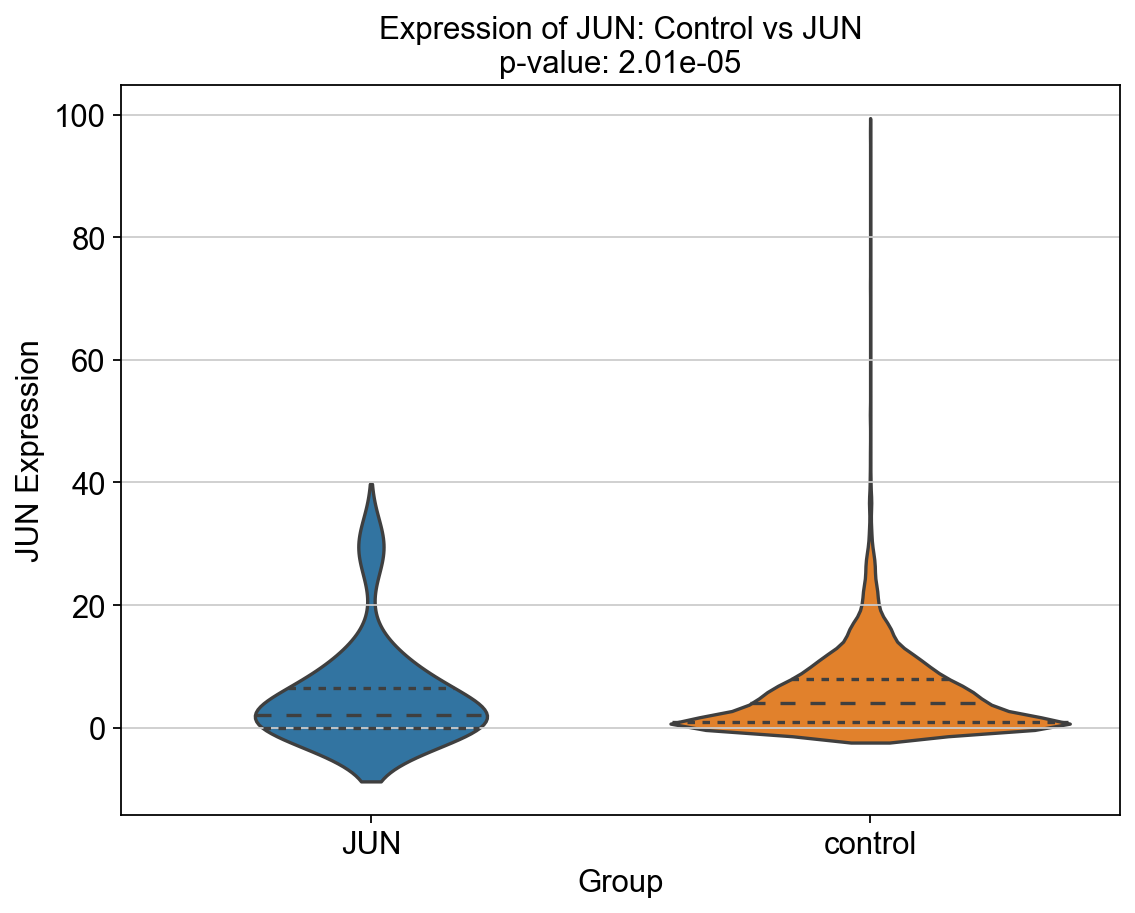

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

# Assuming 'adata' is your Anndata object

# Filter the Anndata object to include only 'control' and 'JUN' cells
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'JUN'])]

# Calculate the expression of 'JUN' gene
jun_expression = adata_filtered[:, adata_filtered.var_names == 'JUN'].X

# Convert the sparse matrix to a dense array if necessary
if isinstance(jun_expression, np.ndarray):
    dense_jun_expression = jun_expression
else:
    dense_jun_expression = jun_expression.toarray()

# Split the expression data into 'control' and 'JUN' groups based on the 'Gene' category
control_expression = dense_jun_expression[adata_filtered.obs['Gene'] == 'control'].flatten()
jun_expression = dense_jun_expression[adata_filtered.obs['Gene'] == 'JUN'].flatten()

# Perform a t-test between the two groups
t_stat, p_value = ttest_ind(control_expression, jun_expression, equal_var=False)  # Assuming unequal variance

# Plotting the expression levels of 'JUN' for 'control' vs 'JUN' groups
plt.figure(figsize=(8, 6))
sns.violinplot(x=adata_filtered.obs['Gene'], y=np.concatenate([control_expression, jun_expression]), inner="quartile")
plt.title(f"Expression of JUN: Control vs JUN\np-value: {p_value:.2e}")
plt.ylabel('JUN Expression')
plt.xlabel('Group')

plt.show()


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


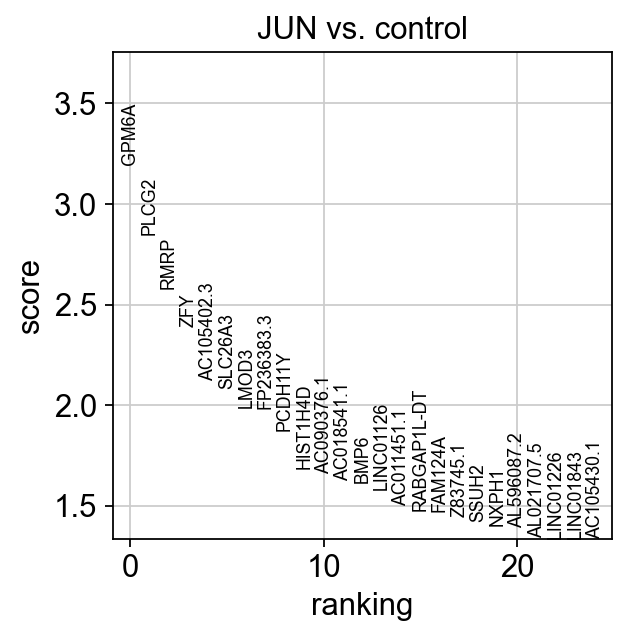

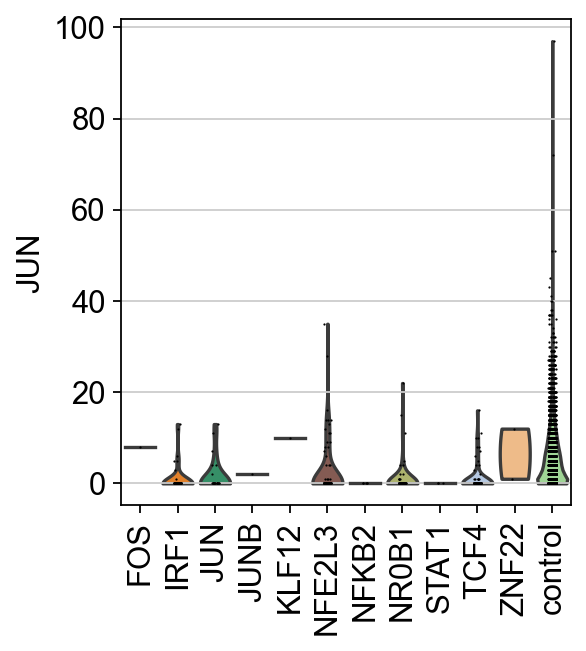

In [26]:
import scanpy as sc

# Assuming 'adata' is your Anndata object

# Set the 'Gene' column as the cell grouping for differential expression analysis
adata.obs['groups'] = adata.obs['Gene']

# Run differential expression analysis
# Comparing 'JUN' labeled cells vs 'control'
sc.tl.rank_genes_groups(adata, groupby='groups', groups=['JUN'], reference='control')

# Plotting the differential expression results
sc.pl.rank_genes_groups(adata, groups=['JUN'], n_genes=25, sharey=False)

# To specifically look at the 'JUN' gene expression comparison, you can extract the p-value, fold change, etc., from the result
de_result = adata.uns['rank_genes_groups']
gene_names = de_result['names']['JUN']
p_values = de_result['pvals']['JUN']
logfoldchanges = de_result['logfoldchanges']['JUN']

# If you specifically want to visualize 'JUN' expression, you can use the following:
# Note: This step assumes 'JUN' is significantly differentially expressed and you want to visualize it
if 'JUN' in gene_names:
    sc.pl.violin(adata, keys='JUN', groupby='groups', rotation=90)


# Filtering data based on QC parameters

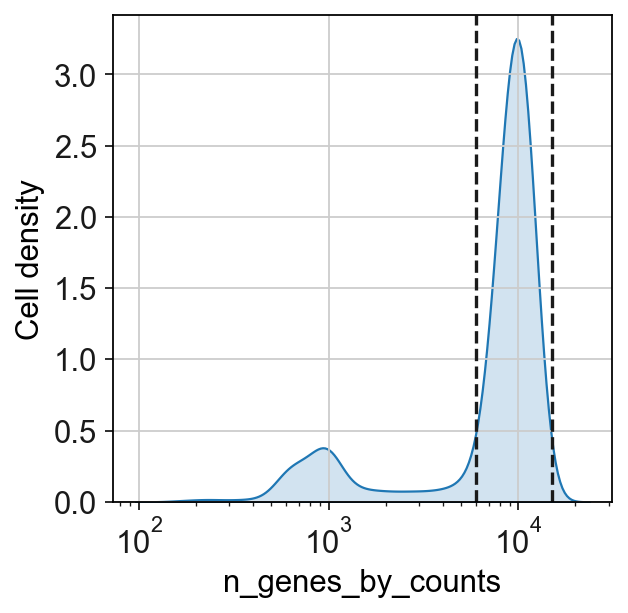

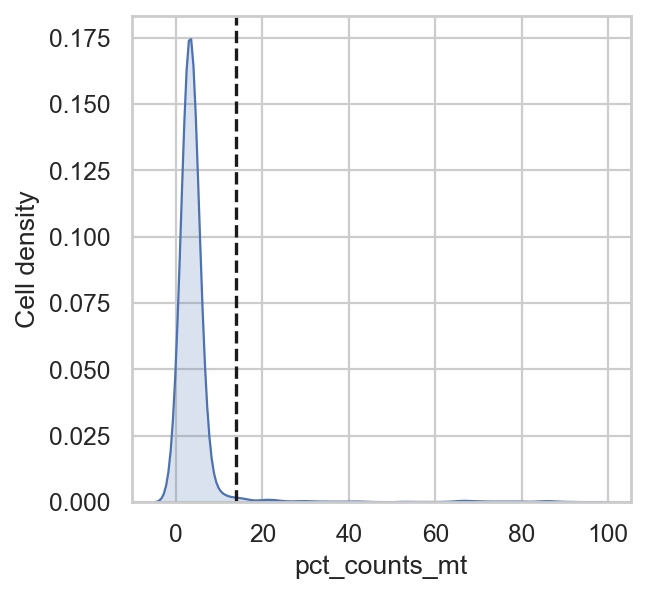

In [25]:
# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=6000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

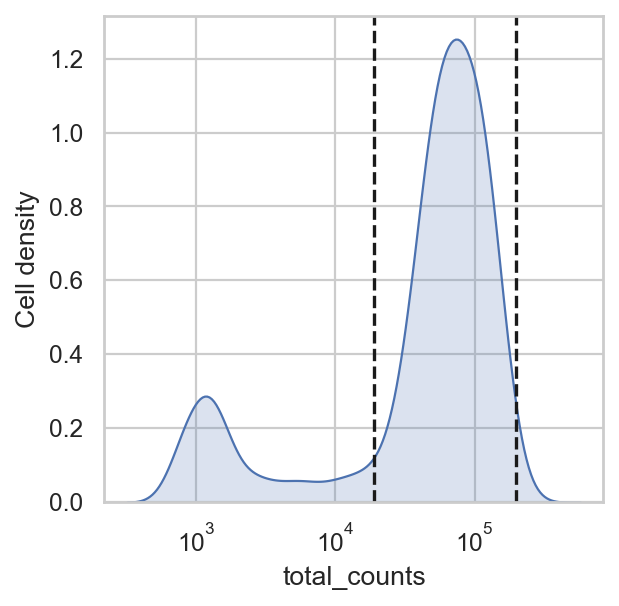

In [26]:
plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=19000, color='k', linestyle='--')
plt.axvline(x=200000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

In [27]:
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 19000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 6000) &
                        (adata.obs['n_genes_by_counts'] < 15000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
#scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)

# making the adata copy below might have to go before the log transformation

# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:650: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [28]:
# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

97
35
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    128 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    191 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [29]:
adata

AnnData object with n_obs × n_vars = 3816 × 1500
    obs: 'cell_barcode', 'Gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'initial_size', 'S_score', 'G2M_score', 'phase', 'ccdifference'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'hvg'
    layers: 'counts'

# Normalization and Dim Reduction

In [38]:
# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


# Filtering for contorl cells after normalization

In [39]:
adata_control = adata[adata.obs['Gene'] == 'control'].copy()

In [42]:
adata_control

AnnData object with n_obs × n_vars = 3746 × 1500
    obs: 'cell_barcode', 'Gene', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'initial_size', 'S_score', 'G2M_score', 'phase', 'ccdifference'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [30]:
adata_perturbed = adata[adata.obs['Gene'] != 'control'].copy()

In [31]:
adata_perturbed.obs

cell_barcode    Gene  n_genes_by_counts  \
AAAGTGACAAGATGTA-1  AAAGTGACAAGATGTA-1  NFE2L3              11048   
ACGTACATCATCCTGC-1  ACGTACATCATCCTGC-1  NFE2L3              11996   
AGAAGTAGTTAAGGGC-1  AGAAGTAGTTAAGGGC-1     JUN               8864   
AGACACTGTGAAGCTG-1  AGACACTGTGAAGCTG-1    IRF1              11193   
AGAGCAGAGTTCTACG-1  AGAGCAGAGTTCTACG-1     JUN              10098   
...                                ...     ...                ...   
TTACAGGGTATCACGT-1  TTACAGGGTATCACGT-1  NFE2L3               8756   
TTACTGTAGCGAGTCA-1  TTACTGTAGCGAGTCA-1    TCF4               8066   
TTATTGCCACGCAAAG-1  TTATTGCCACGCAAAG-1    TCF4              10969   
TTGGGCGCATGGTACT-1  TTGGGCGCATGGTACT-1    TCF4              10915   
TTTACTGAGCCAAGCA-1  TTTACTGAGCCAAGCA-1  NFE2L3              11954   

                    total_counts  total_counts_mt  pct_counts_mt  n_counts  \
AAAGTGACAAGATGTA-1      126652.0           4207.0       3.321701  126652.0   
ACGTACATCATCCTGC-1      141542.0           4943.0       3.492249  141542.0   
AGAAGTAGTTAAGGGC-1       62546.0           4394.0       7.025229   62546.0   
AGACACTGTGAAGCTG-1      117218.0           3101.0       2.645498  117218.0   
AGAGCAGAGTTCTACG-1       76656.0           2095.0       2.732989   76656.0   
...                          ...              ...            ...       ...   
TTACAGGGTATCACGT-1       47578.0            964.0       2.026146   47578.0   
TTACTGTAGCGAGTCA-1       42045.0            510.0       1.212986   42045.0   
TTATTGCCACGCAAAG-1      110411.0           3407.0       3.085743  110411.0   
TTGGGCGCATGGTACT-1       74620.0           3242.0       4.344680   74620.0   
TTTACTGAGCCAAGCA-1      135930.0           5597.0       4.117560  135930.0   

                    initial_size   S_score  G2M_score phase  ccdifference  
AAAGTGACAAGATGTA-1      126652.0 -0.634084   0.521034   G2M     -1.155117  
ACGTACATCATCCTGC-1      141542.0 -0.564748  -0.013875    G1     -0.550873  
AGAAGTAGTTAAGGGC-1       62546.0  1.214205   0.100340     S      1.113865  
AGACACTGTGAAGCTG-1      117218.0 -0.496063  -1.294650    G1      0.798587  
AGAGCAGAGTTCTACG-1       76656.0  1.020871  -0.226525     S      1.247396  
...                          ...       ...        ...   ...           ...  
TTACAGGGTATCACGT-1       47578.0  0.206418   0.859844   G2M     -0.653427  
TTACTGTAGCGAGTCA-1       42045.0 -0.306472   0.460168   G2M     -0.766639  
TTATTGCCACGCAAAG-1      110411.0 -0.187284  -0.037397    G1     -0.149887  
TTGGGCGCATGGTACT-1       74620.0 -0.415962  -1.130403    G1      0.714441  
TTTACTGAGCCAAGCA-1      135930.0 -0.799656   0.601198   G2M     -1.400855  

[70 rows x 12 columns]

In [44]:
adata_control.obs

cell_barcode     Gene  n_genes_by_counts  \
AAACCCAAGCATTTCG-1  AAACCCAAGCATTTCG-1  control               9349   
AAACCCAAGGTCGTGA-1  AAACCCAAGGTCGTGA-1  control              10853   
AAACCCAAGTCACTCA-1  AAACCCAAGTCACTCA-1  control               8370   
AAACCCACATGTAACC-1  AAACCCACATGTAACC-1  control               8904   
AAACCCAGTACGCTTA-1  AAACCCAGTACGCTTA-1  control               9422   
...                                ...      ...                ...   
TTTGGAGTCTTGATTC-1  TTTGGAGTCTTGATTC-1  control               8416   
TTTGGTTCAAATAAGC-1  TTTGGTTCAAATAAGC-1  control               7937   
TTTGGTTCACCGTCGA-1  TTTGGTTCACCGTCGA-1  control               8985   
TTTGGTTTCGGTCTAA-1  TTTGGTTTCGGTCTAA-1  control               8325   
TTTGTTGAGTGACACG-1  TTTGTTGAGTGACACG-1  control               7916   

                    total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAAGCATTTCG-1       57096.0           2748.0       4.812946   
AAACCCAAGGTCGTGA-1      112646.0           3906.0       3.467500   
AAACCCAAGTCACTCA-1       61728.0           1725.0       2.794518   
AAACCCACATGTAACC-1       64271.0           1895.0       2.948453   
AAACCCAGTACGCTTA-1       65600.0           1717.0       2.617378   
...                          ...              ...            ...   
TTTGGAGTCTTGATTC-1       46738.0           1342.0       2.871325   
TTTGGTTCAAATAAGC-1       42908.0           1606.0       3.742892   
TTTGGTTCACCGTCGA-1       56420.0           1643.0       2.912088   
TTTGGTTTCGGTCTAA-1       47443.0           1246.0       2.626310   
TTTGTTGAGTGACACG-1       46602.0           1680.0       3.604995   

                    initial_size  n_counts   S_score  G2M_score phase  \
AAACCCAAGCATTTCG-1       57096.0   57096.0 -0.036789   0.983448   G2M   
AAACCCAAGGTCGTGA-1      112646.0  112646.0 -0.469615   0.262668   G2M   
AAACCCAAGTCACTCA-1       61728.0   61728.0 -0.340296  -0.453622    G1   
AAACCCACATGTAACC-1       64271.0   64271.0  0.026636   0.968272   G2M   
AAACCCAGTACGCTTA-1       65600.0   65600.0  0.424476  -0.449721     S   
...                          ...       ...       ...        ...   ...   
TTTGGAGTCTTGATTC-1       46738.0   46738.0  0.130824  -0.768306     S   
TTTGGTTCAAATAAGC-1       42908.0   42908.0 -0.111028   0.153038   G2M   
TTTGGTTCACCGTCGA-1       56420.0   56420.0 -0.054084   0.457294   G2M   
TTTGGTTTCGGTCTAA-1       47443.0   47443.0 -0.140259  -0.262978    G1   
TTTGTTGAGTGACACG-1       46602.0   46602.0 -0.692786  -0.887649    G1   

                    ccdifference leiden  
AAACCCAAGCATTTCG-1     -1.020237      0  
AAACCCAAGGTCGTGA-1     -0.732283      2  
AAACCCAAGTCACTCA-1      0.113326      0  
AAACCCACATGTAACC-1     -0.941636      2  
AAACCCAGTACGCTTA-1      0.874198      0  
...                          ...    ...  
TTTGGAGTCTTGATTC-1      0.899130      2  
TTTGGTTCAAATAAGC-1     -0.264067      1  
TTTGGTTCACCGTCGA-1     -0.511378      1  
TTTGGTTTCGGTCTAA-1      0.122719      2  
TTTGTTGAGTGACACG-1      0.194862      2  

[3795 rows x 13 columns]

In [50]:
adata.obs

cell_barcode     Gene  n_genes_by_counts  \
AAACCCAAGCATTTCG-1  AAACCCAAGCATTTCG-1  control               9349   
AAACCCAAGGTCGTGA-1  AAACCCAAGGTCGTGA-1  control              10853   
AAACCCAAGTCACTCA-1  AAACCCAAGTCACTCA-1  control               8370   
AAACCCACATGTAACC-1  AAACCCACATGTAACC-1  control               8904   
AAACCCAGTACGCTTA-1  AAACCCAGTACGCTTA-1  control               9422   
...                                ...      ...                ...   
TTTGGAGTCTTGATTC-1  TTTGGAGTCTTGATTC-1  control               8416   
TTTGGTTCAAATAAGC-1  TTTGGTTCAAATAAGC-1  control               7937   
TTTGGTTCACCGTCGA-1  TTTGGTTCACCGTCGA-1  control               8985   
TTTGGTTTCGGTCTAA-1  TTTGGTTTCGGTCTAA-1  control               8325   
TTTGTTGAGTGACACG-1  TTTGTTGAGTGACACG-1  control               7916   

                    total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAAGCATTTCG-1       57096.0           2748.0       4.812946   
AAACCCAAGGTCGTGA-1      112646.0           3906.0       3.467500   
AAACCCAAGTCACTCA-1       61728.0           1725.0       2.794518   
AAACCCACATGTAACC-1       64271.0           1895.0       2.948453   
AAACCCAGTACGCTTA-1       65600.0           1717.0       2.617378   
...                          ...              ...            ...   
TTTGGAGTCTTGATTC-1       46738.0           1342.0       2.871325   
TTTGGTTCAAATAAGC-1       42908.0           1606.0       3.742892   
TTTGGTTCACCGTCGA-1       56420.0           1643.0       2.912088   
TTTGGTTTCGGTCTAA-1       47443.0           1246.0       2.626310   
TTTGTTGAGTGACACG-1       46602.0           1680.0       3.604995   

                    initial_size  n_counts   S_score  G2M_score phase  \
AAACCCAAGCATTTCG-1       57096.0   57096.0 -0.036789   0.983448   G2M   
AAACCCAAGGTCGTGA-1      112646.0  112646.0 -0.469615   0.262668   G2M   
AAACCCAAGTCACTCA-1       61728.0   61728.0 -0.340296  -0.453622    G1   
AAACCCACATGTAACC-1       64271.0   64271.0  0.026636   0.968272   G2M   
AAACCCAGTACGCTTA-1       65600.0   65600.0  0.424476  -0.449721     S   
...                          ...       ...       ...        ...   ...   
TTTGGAGTCTTGATTC-1       46738.0   46738.0  0.130824  -0.768306     S   
TTTGGTTCAAATAAGC-1       42908.0   42908.0 -0.111028   0.153038   G2M   
TTTGGTTCACCGTCGA-1       56420.0   56420.0 -0.054084   0.457294   G2M   
TTTGGTTTCGGTCTAA-1       47443.0   47443.0 -0.140259  -0.262978    G1   
TTTGTTGAGTGACACG-1       46602.0   46602.0 -0.692786  -0.887649    G1   

                    ccdifference leiden  
AAACCCAAGCATTTCG-1     -1.020237      0  
AAACCCAAGGTCGTGA-1     -0.732283      2  
AAACCCAAGTCACTCA-1      0.113326      0  
AAACCCACATGTAACC-1     -0.941636      2  
AAACCCAGTACGCTTA-1      0.874198      0  
...                          ...    ...  
TTTGGAGTCTTGATTC-1      0.899130      2  
TTTGGTTCAAATAAGC-1     -0.264067      1  
TTTGGTTCACCGTCGA-1     -0.511378      1  
TTTGGTTTCGGTCTAA-1      0.122719      2  
TTTGTTGAGTGACACG-1      0.194862      2  

[3816 rows x 13 columns]

In [44]:
sc.tl.leiden(adata_control, resolution = 0.4)


running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


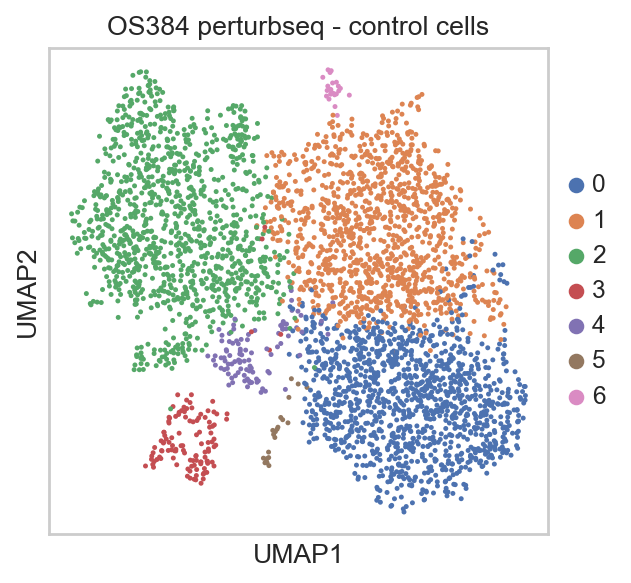

In [45]:


sc.pl.umap(
    adata_control,
    color=["leiden"],
    frameon= True,
    title = "OS384 perturbseq - control cells",
    size = 20
)

# Chisquared analysis

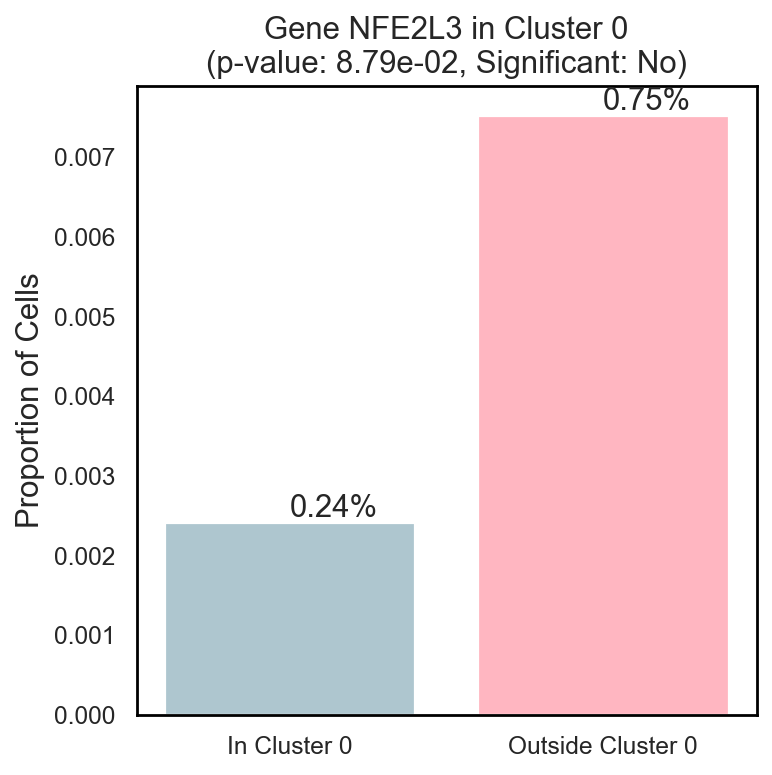

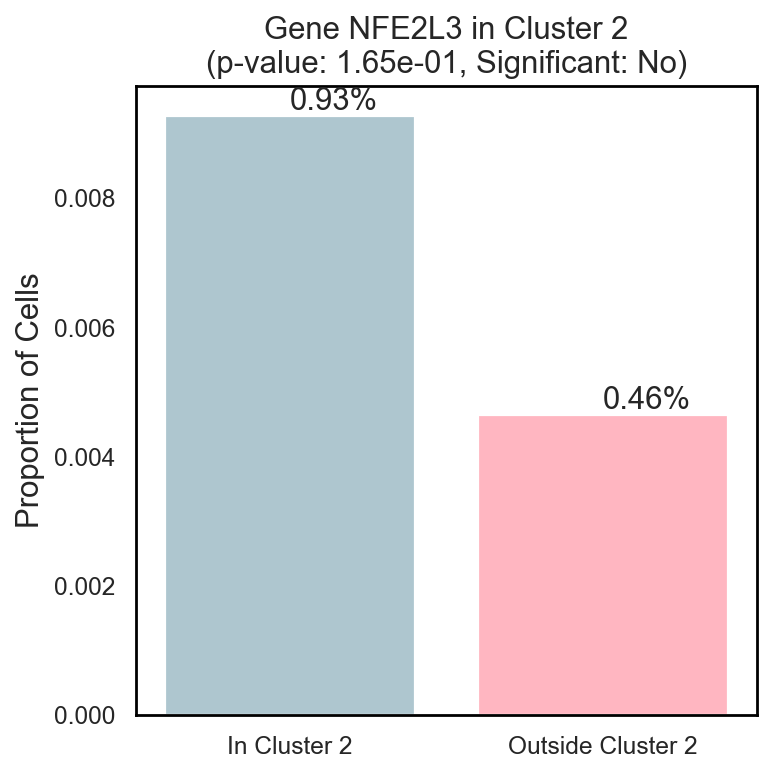

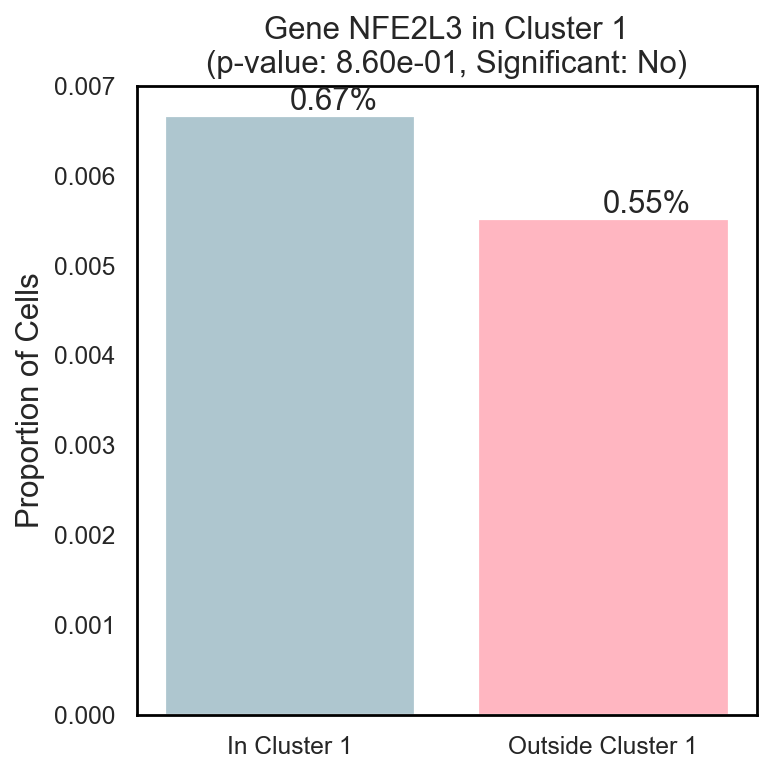

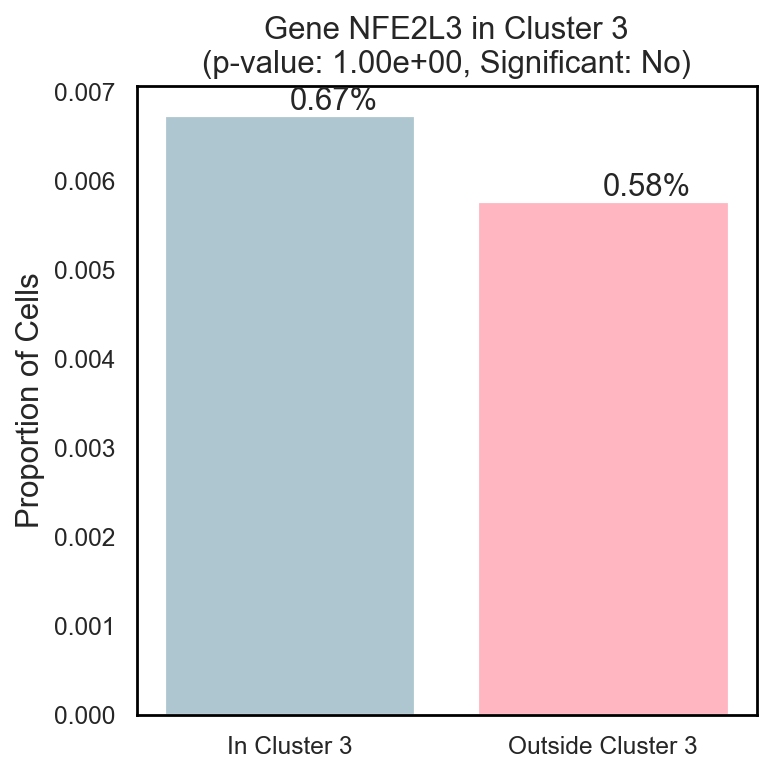

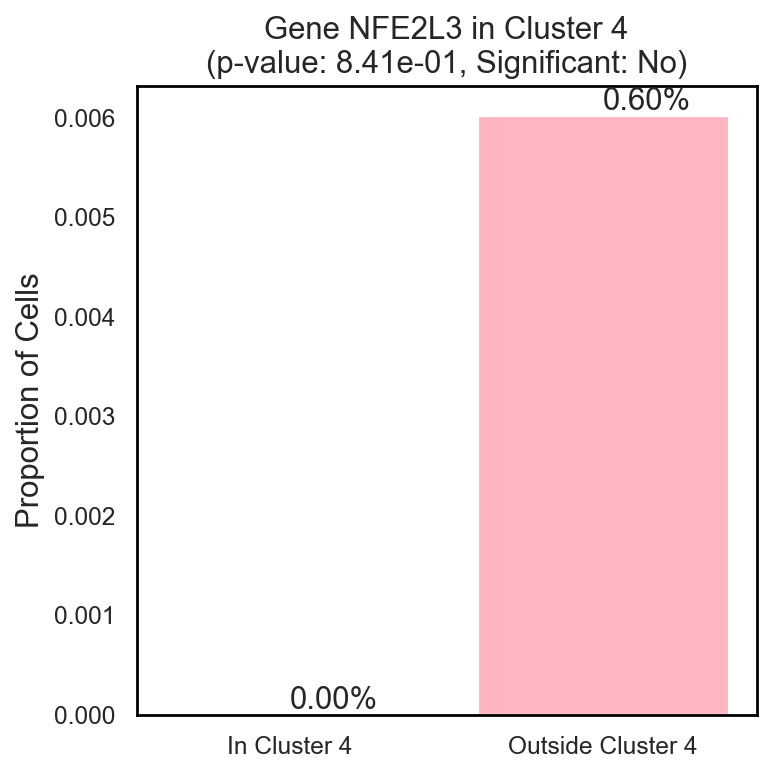

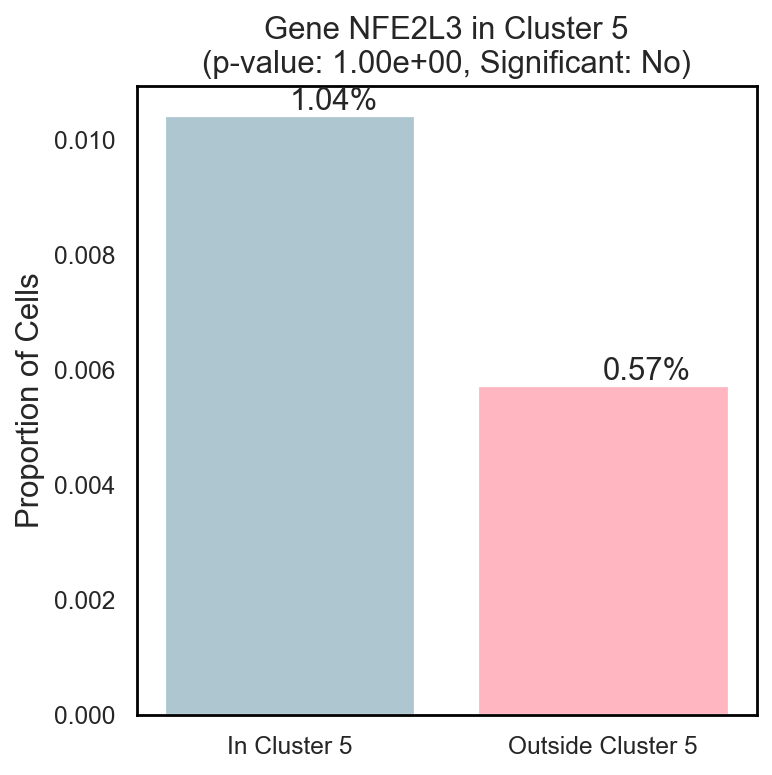

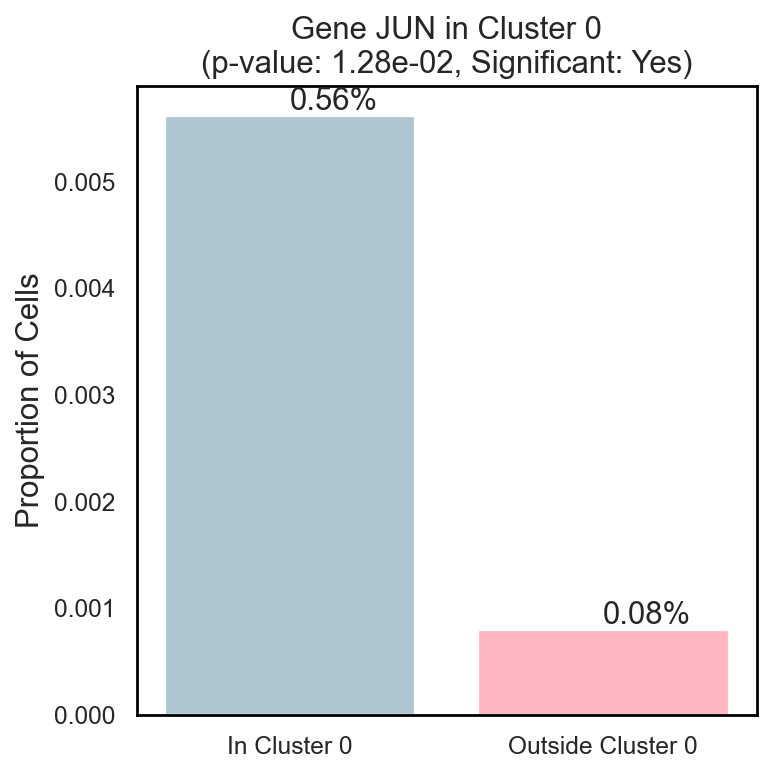

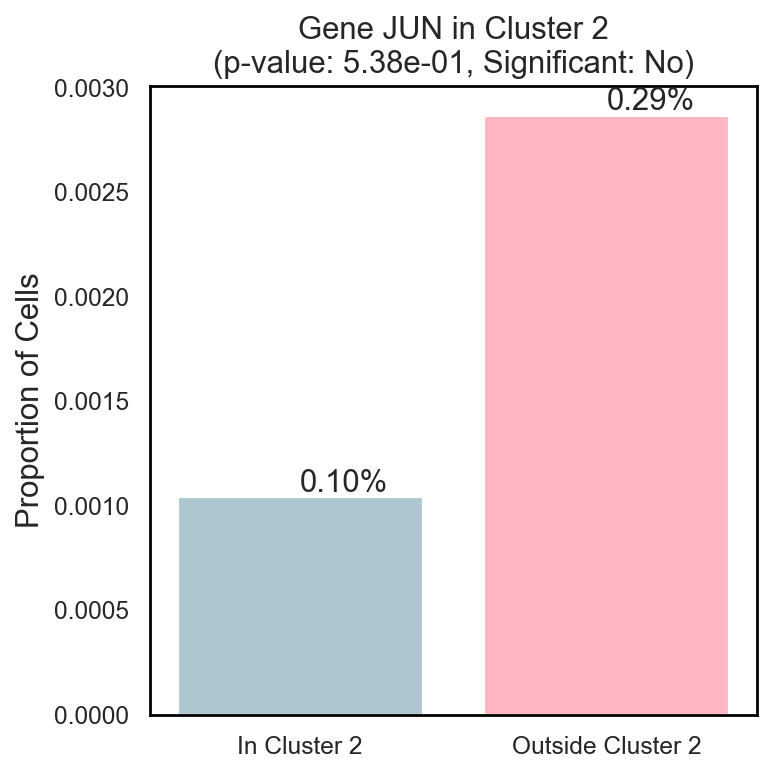

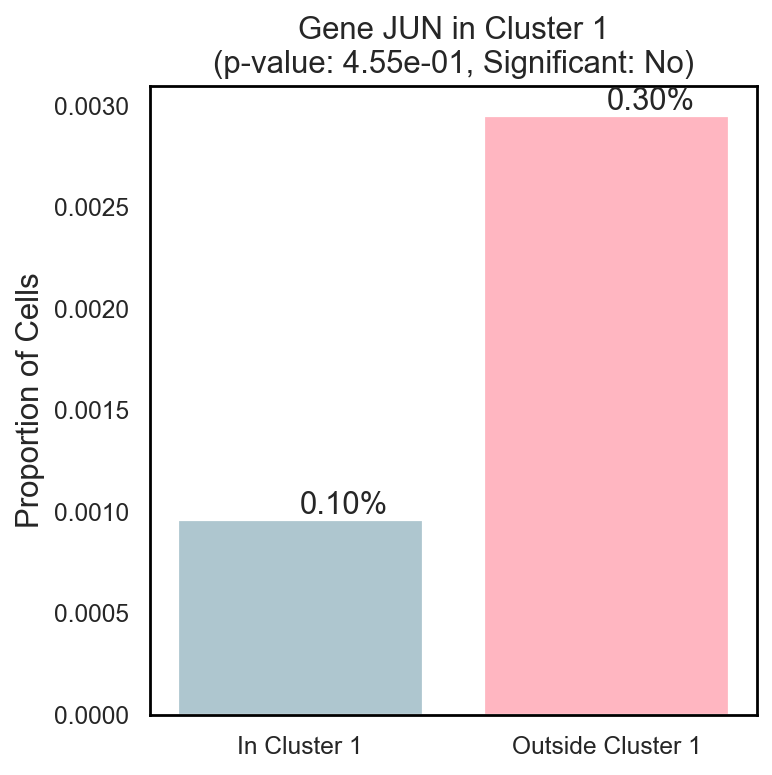

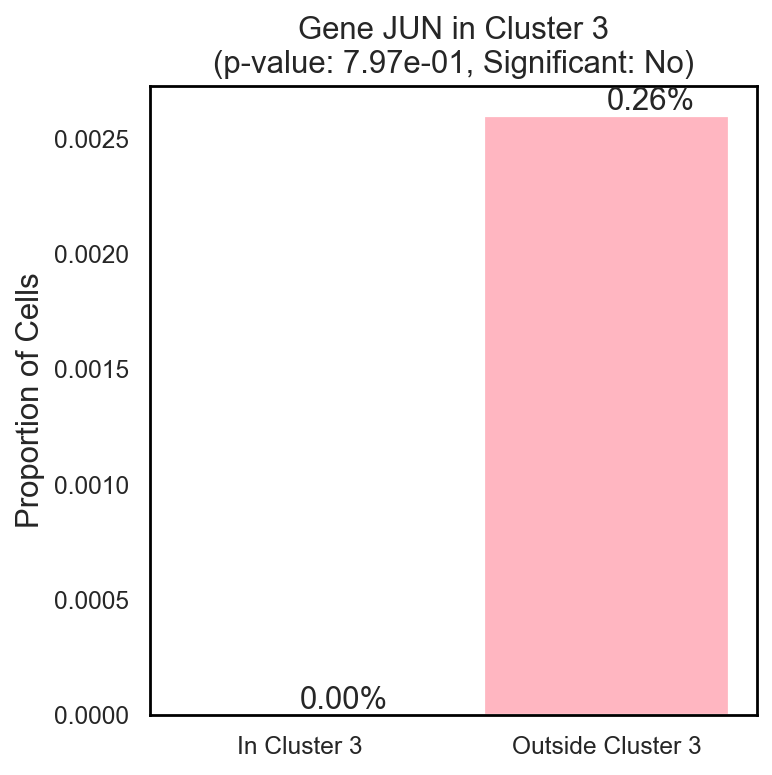

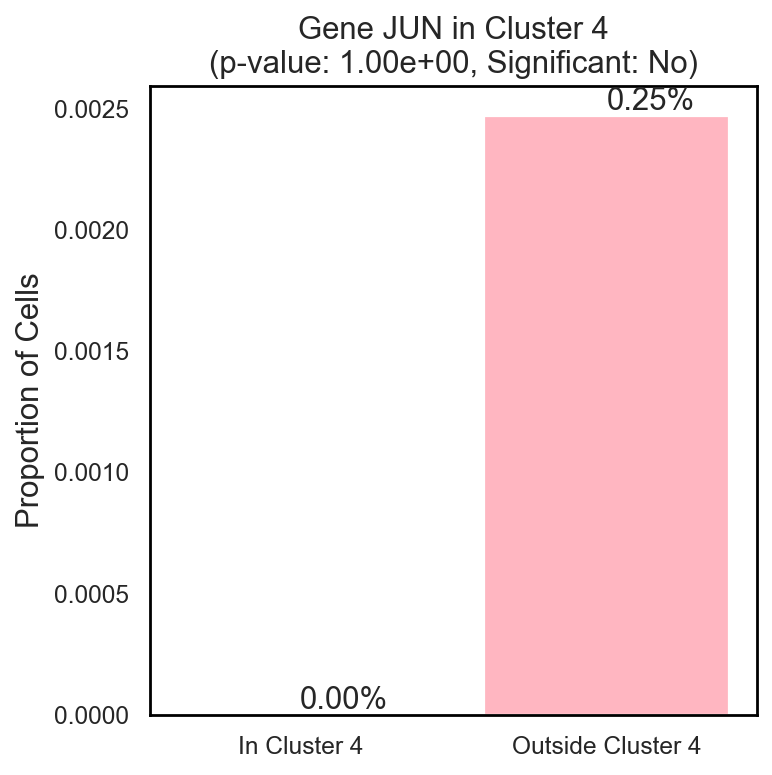

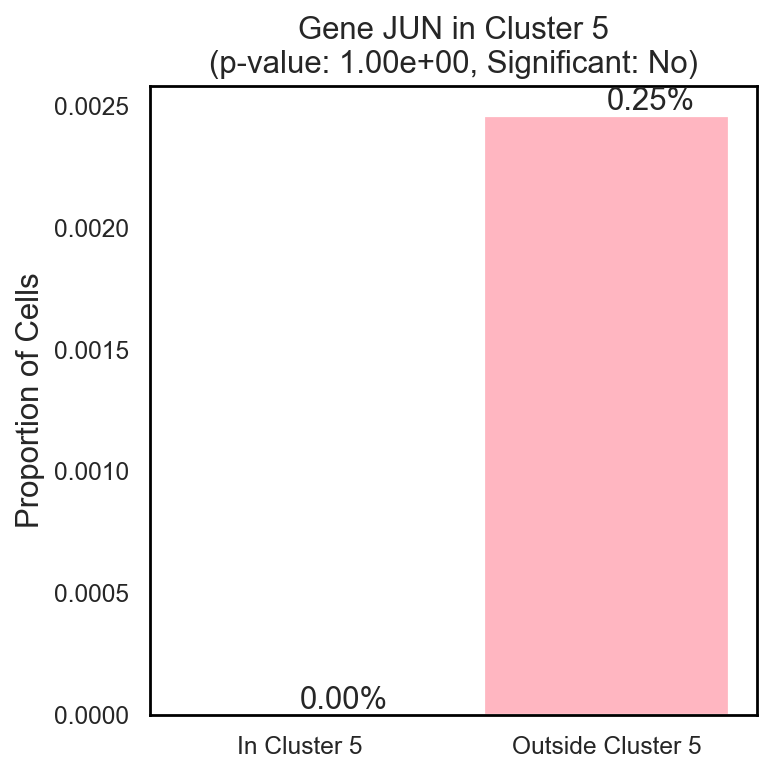

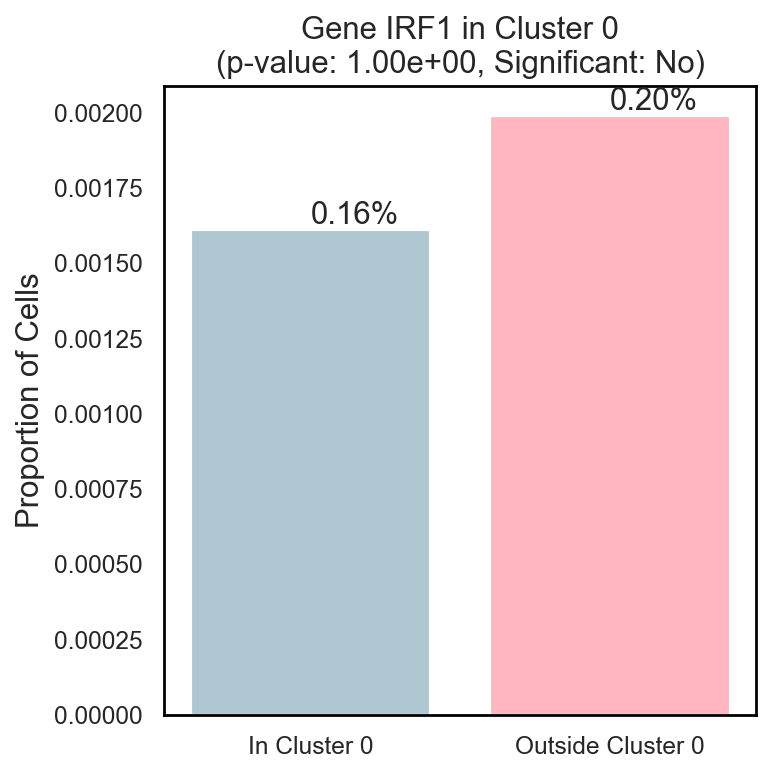

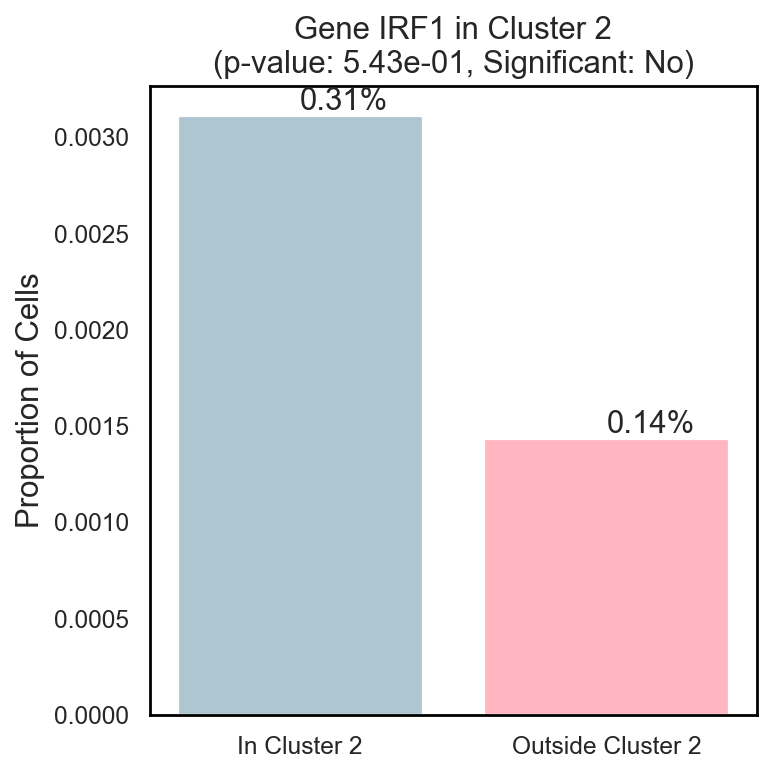

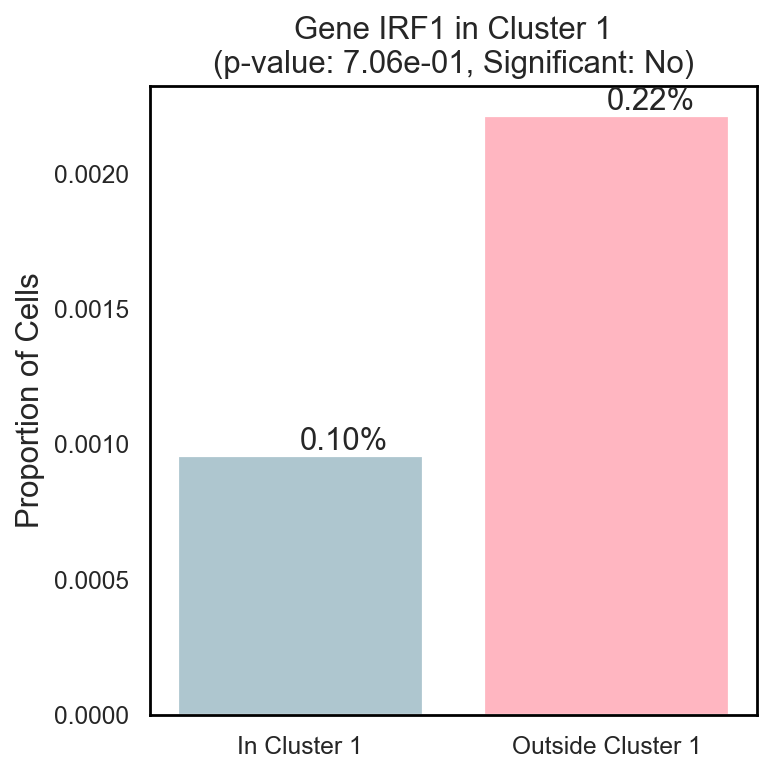

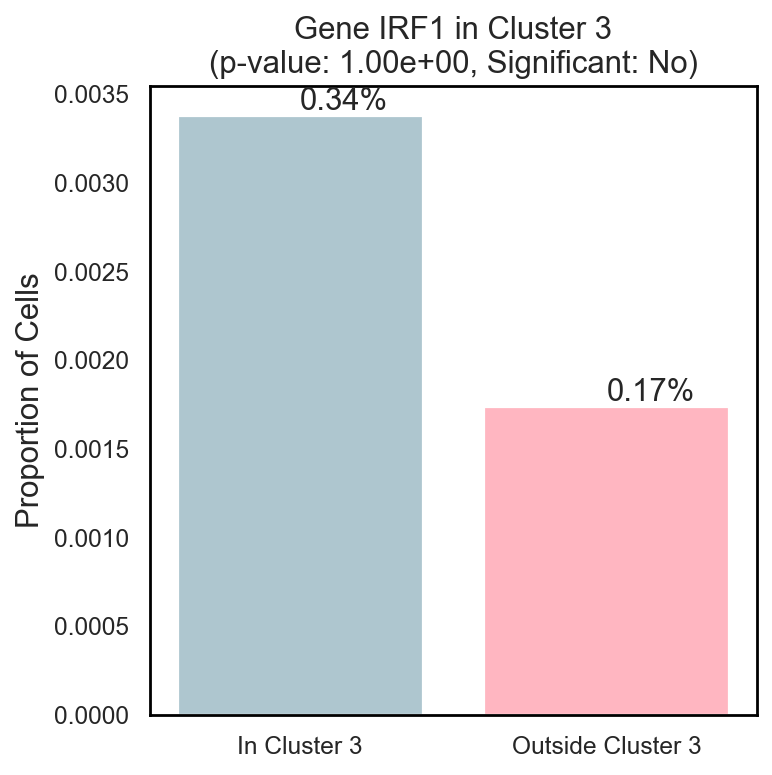

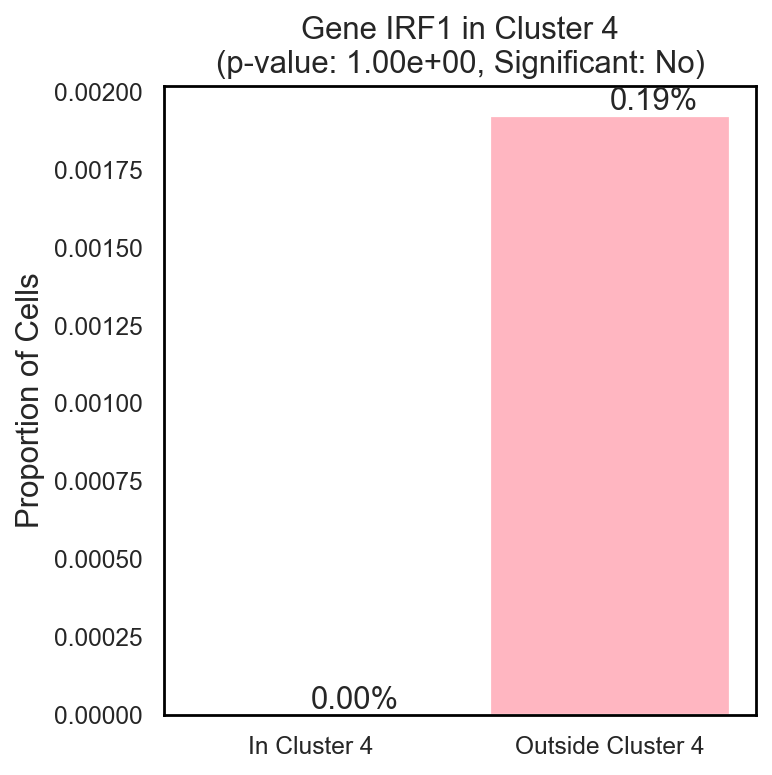

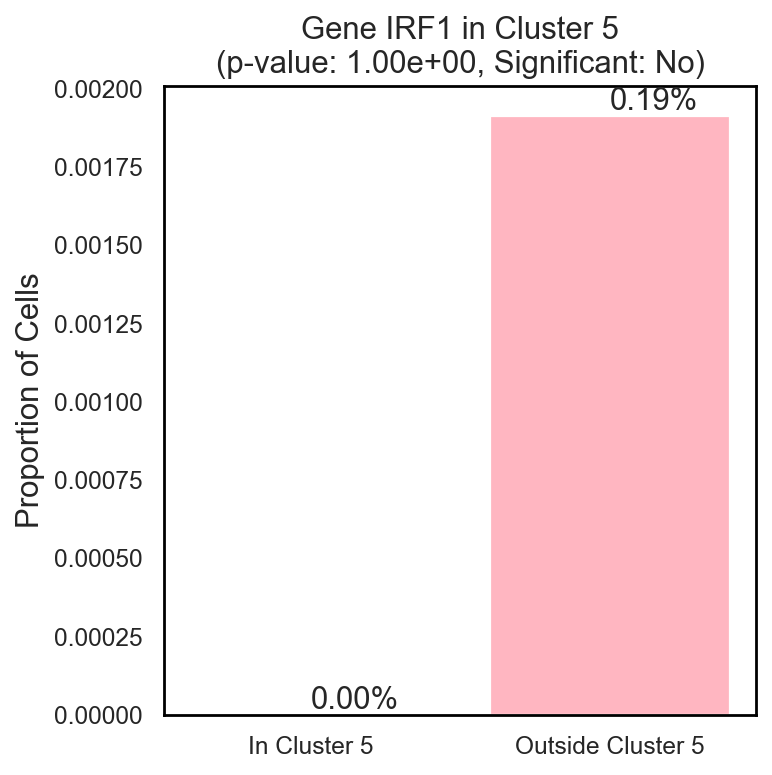

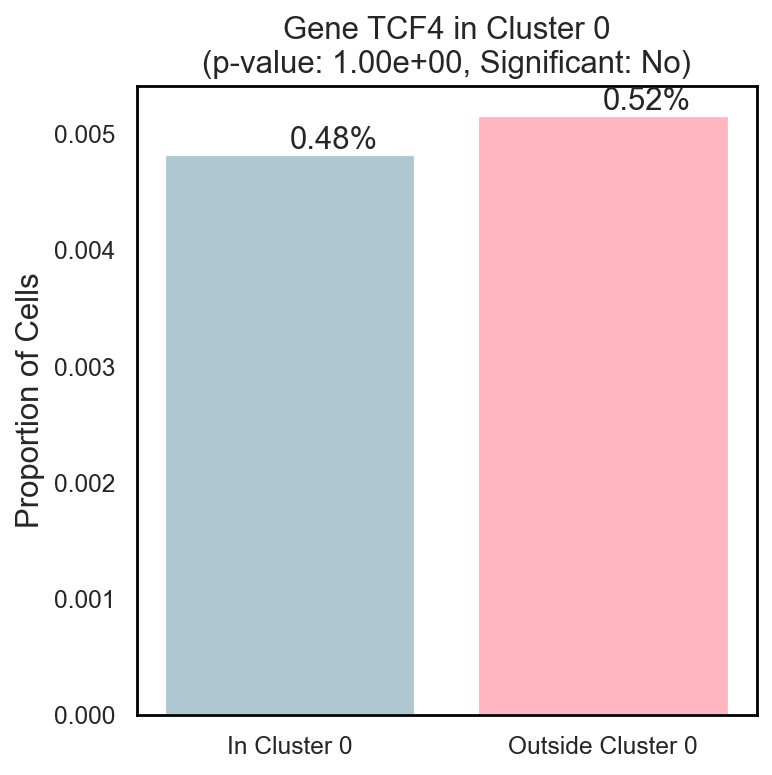

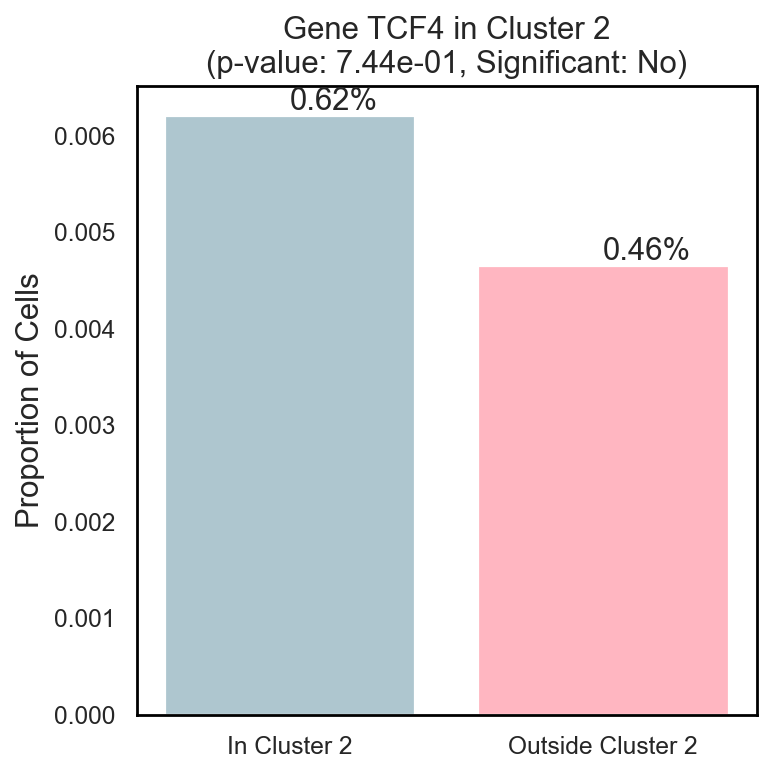

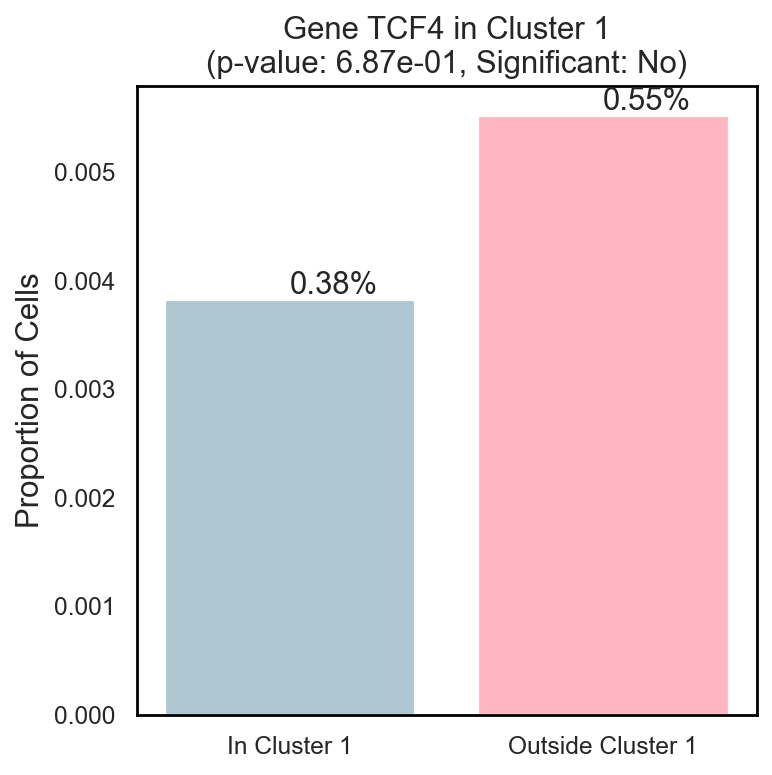

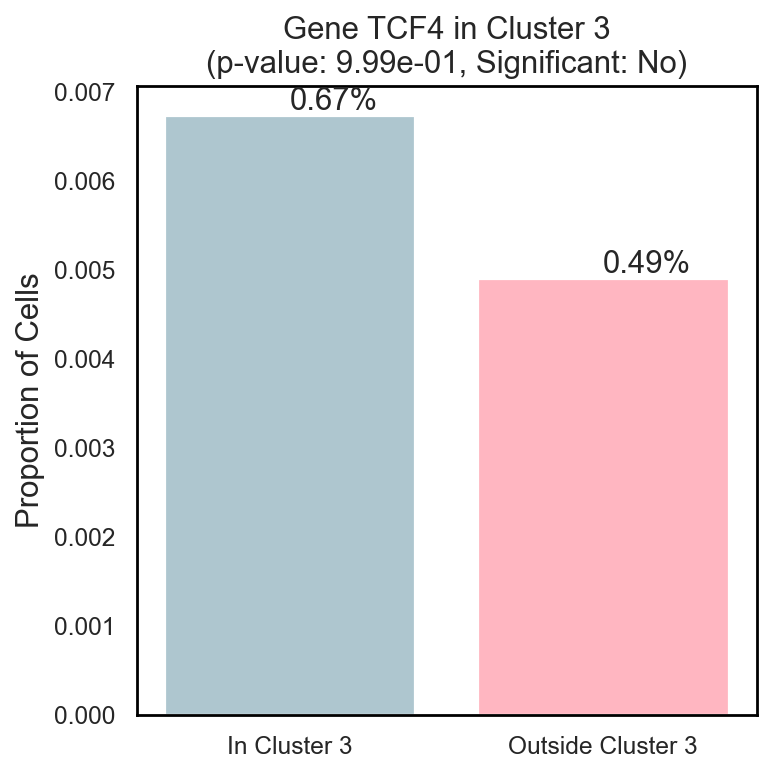

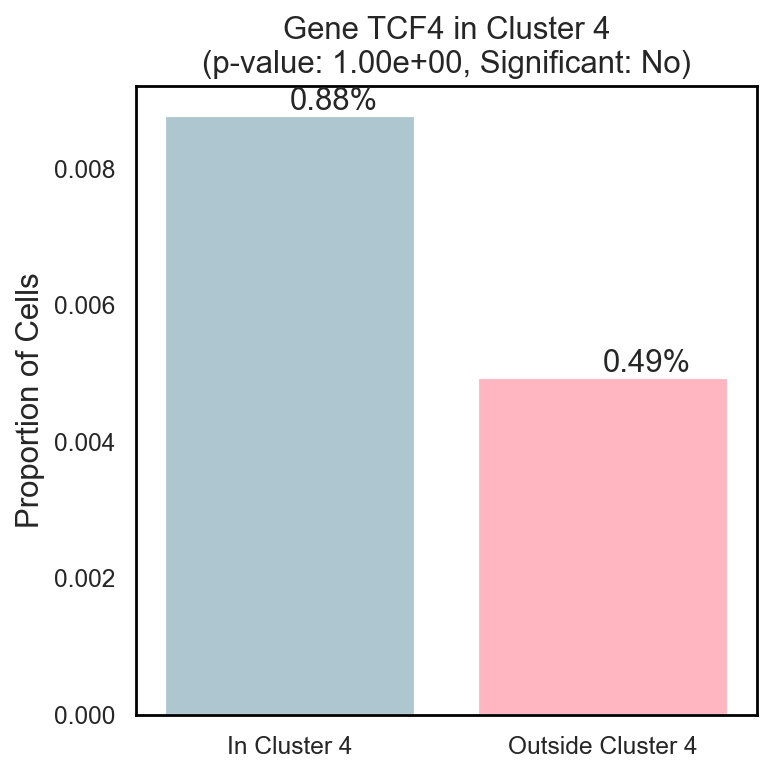

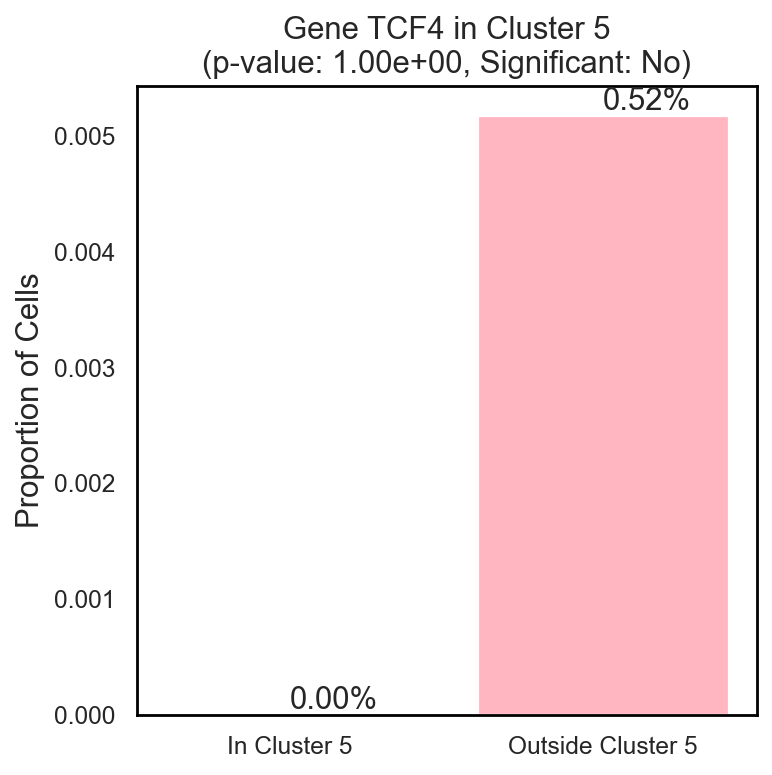

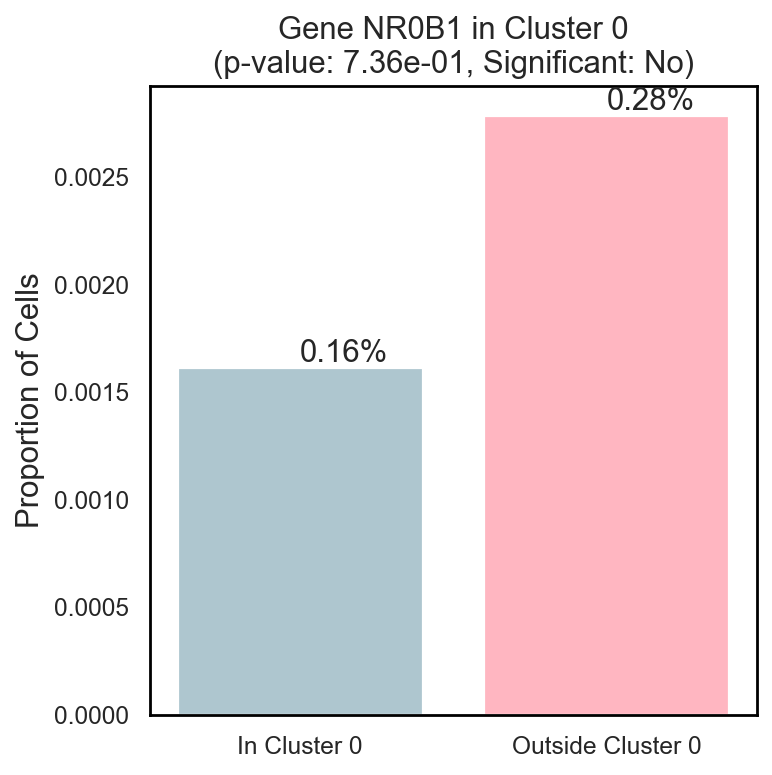

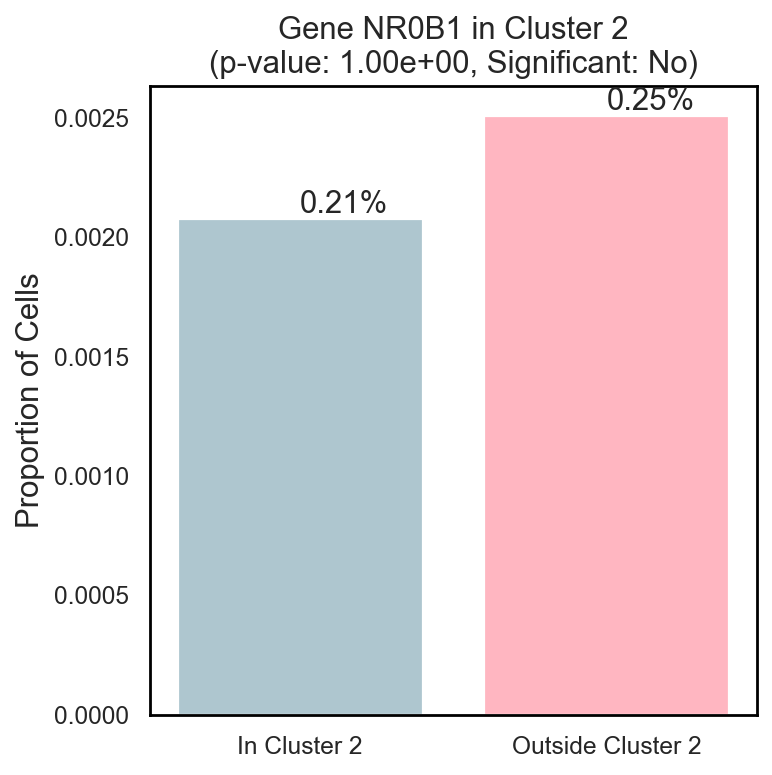

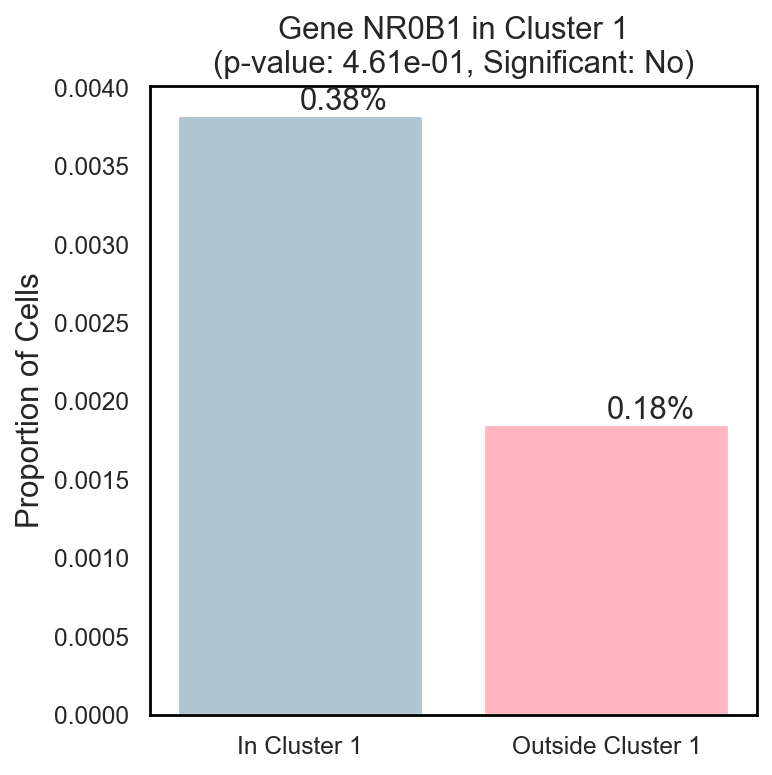

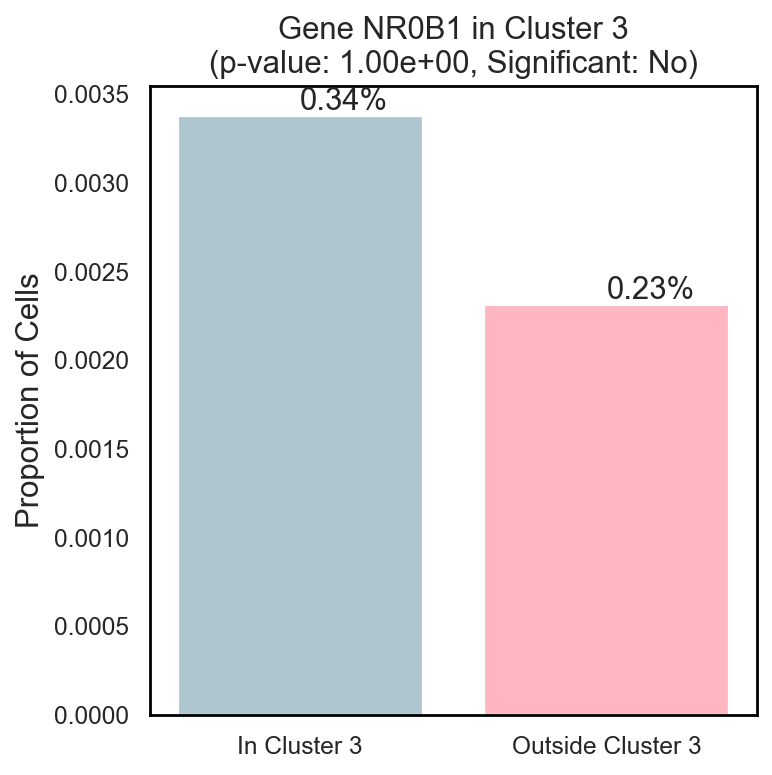

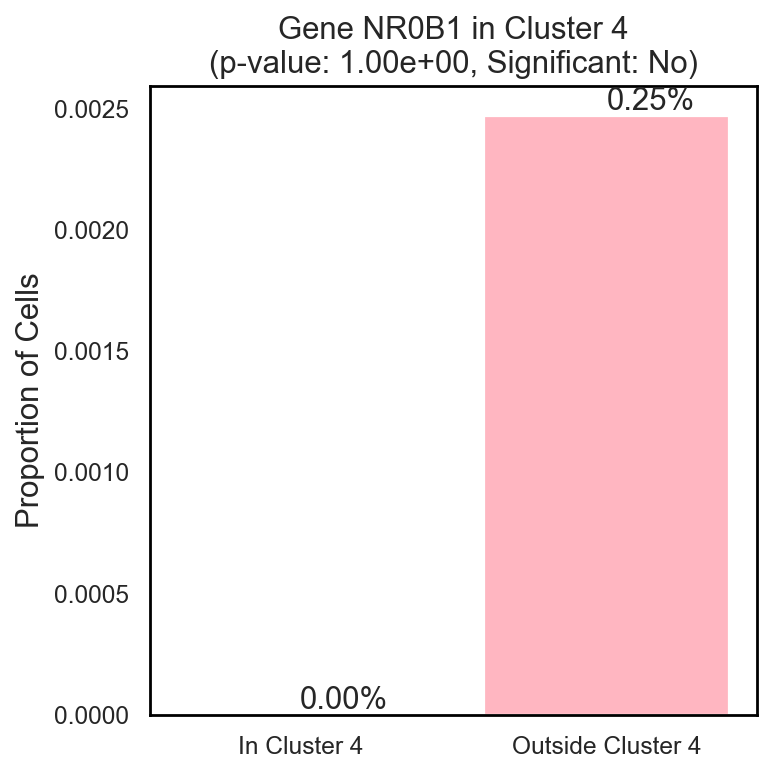

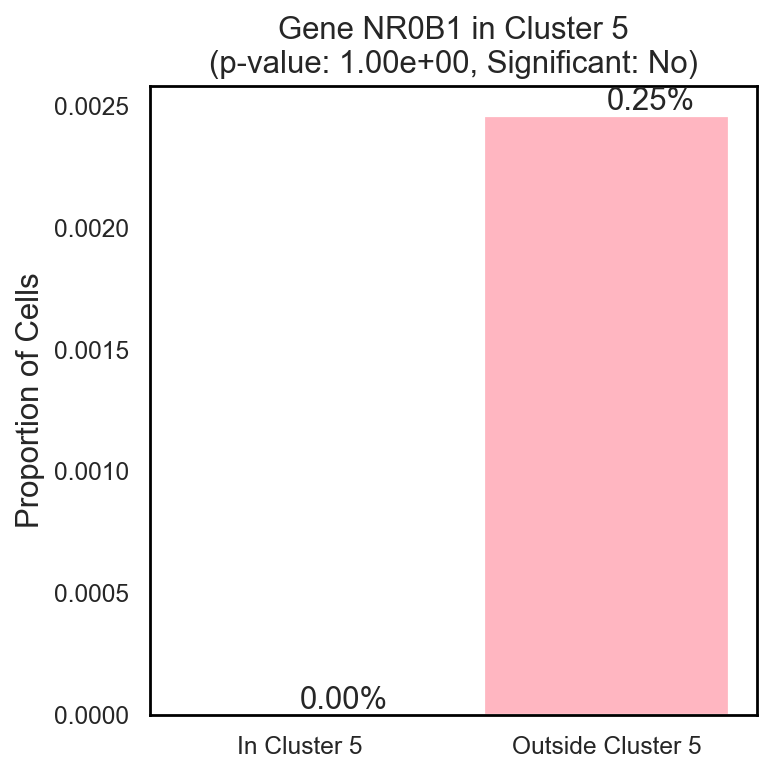

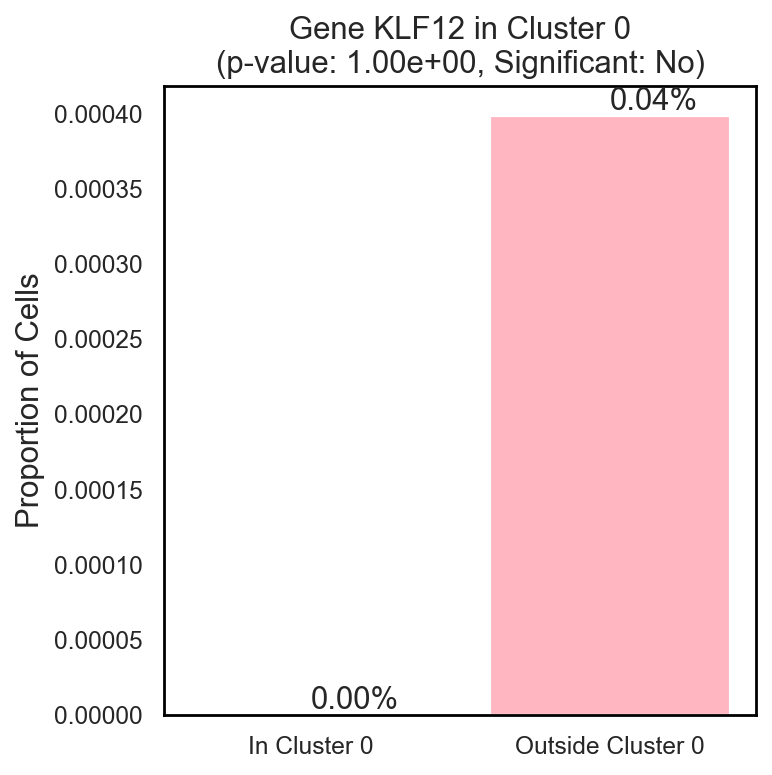

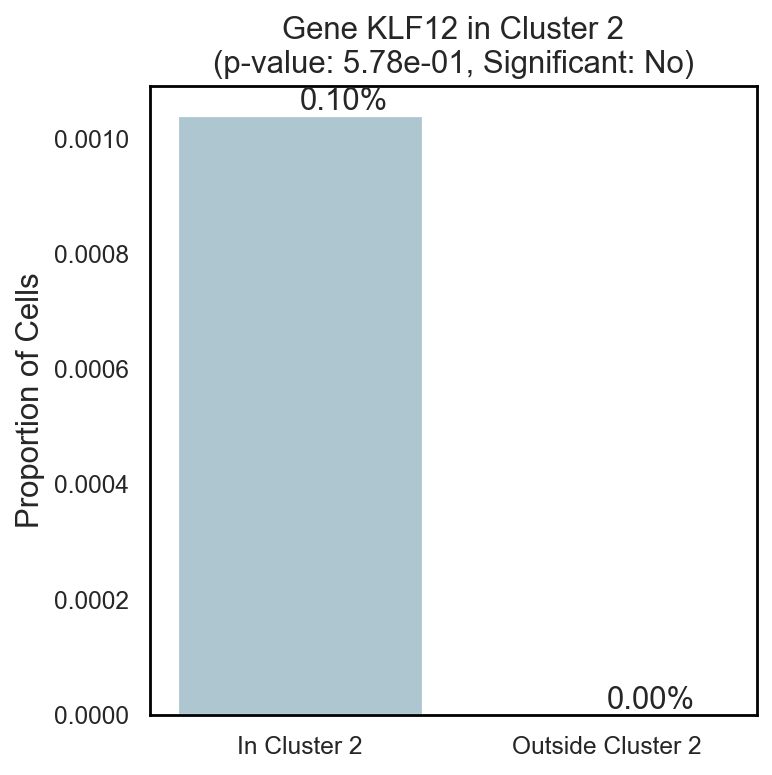

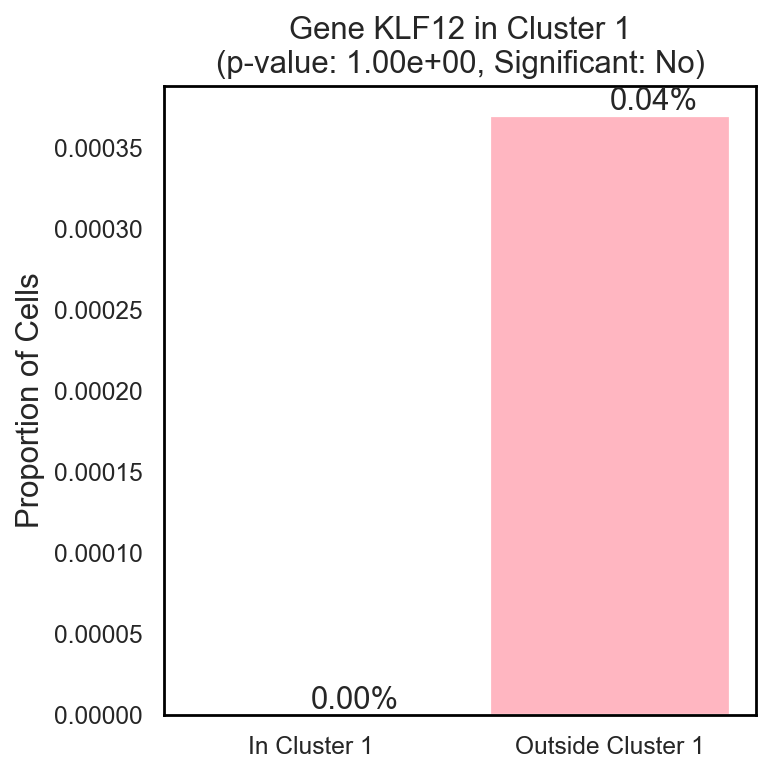

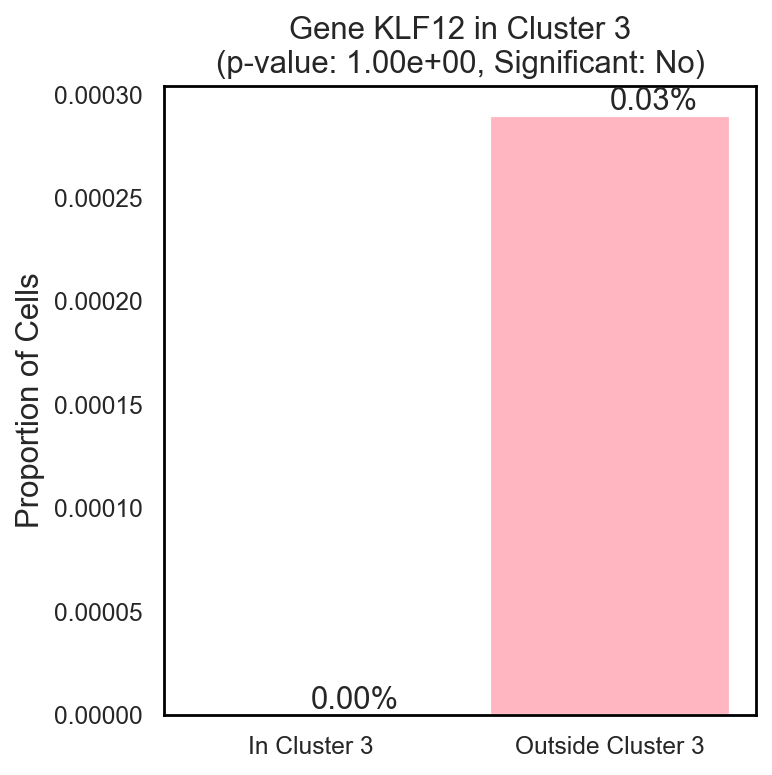

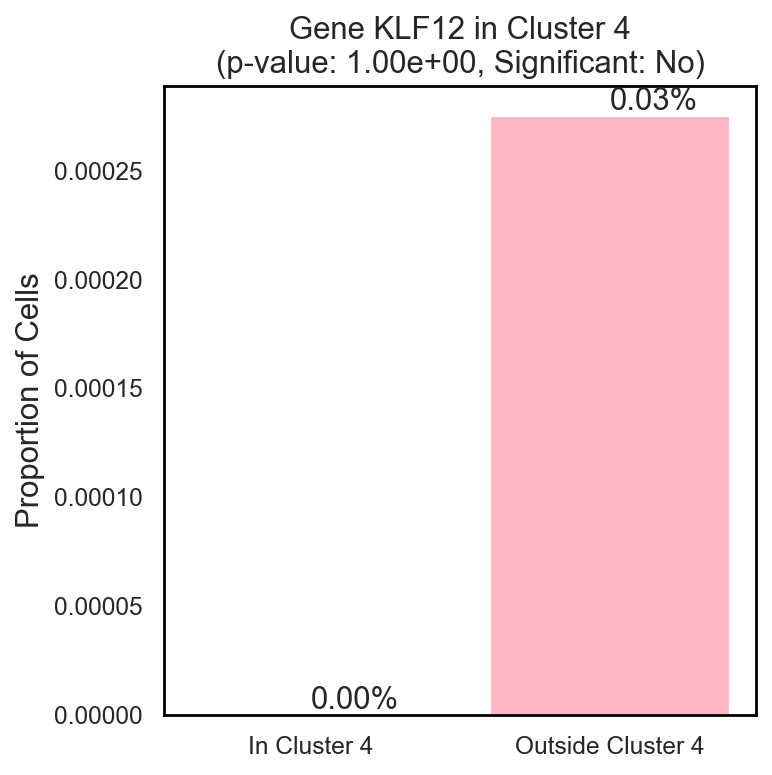

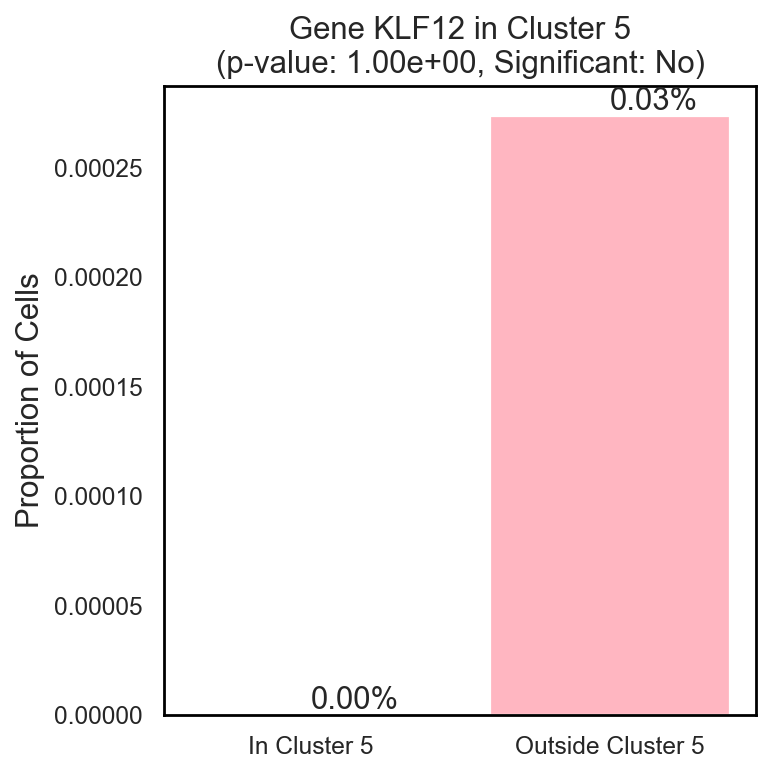

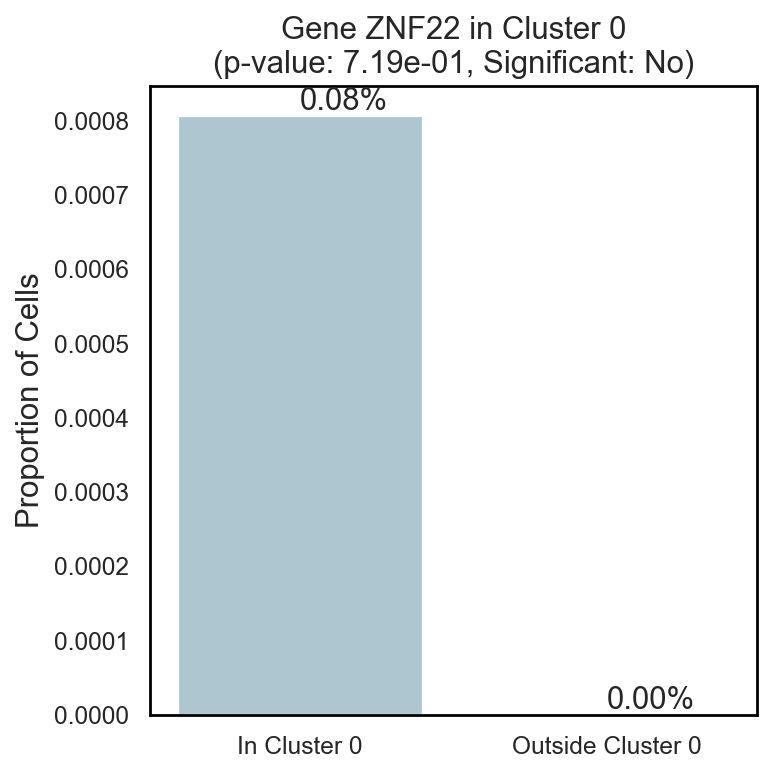

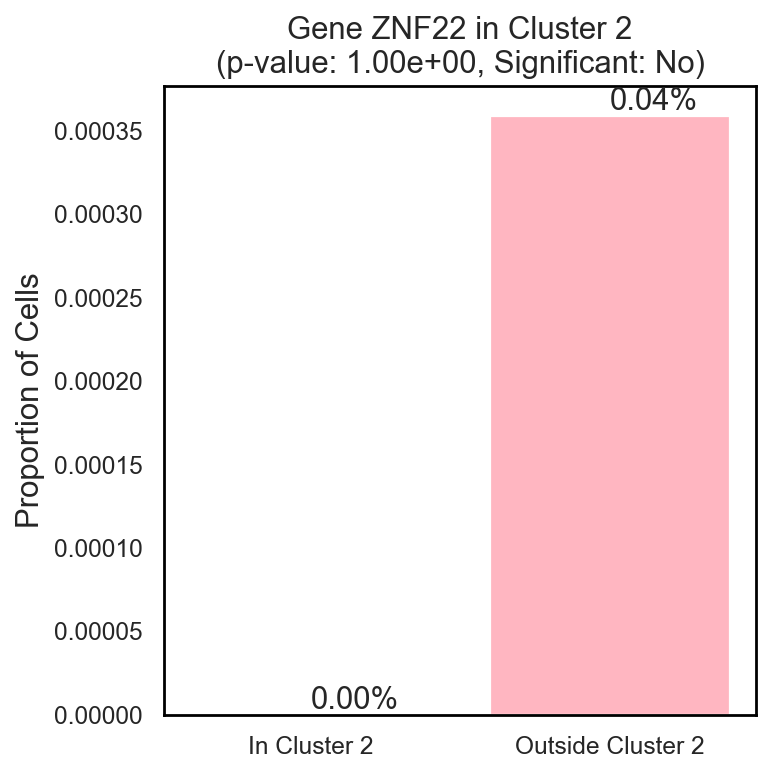

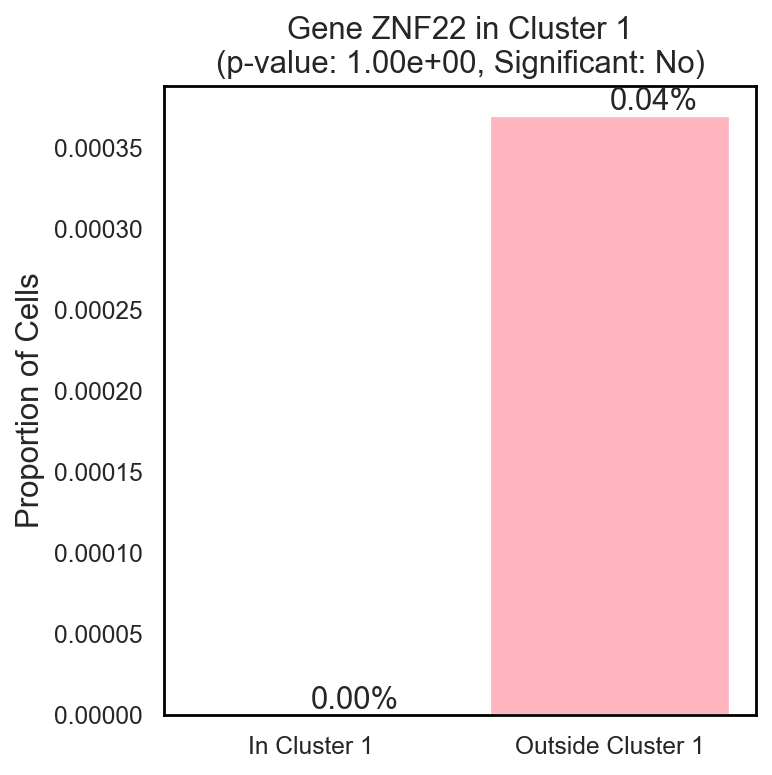

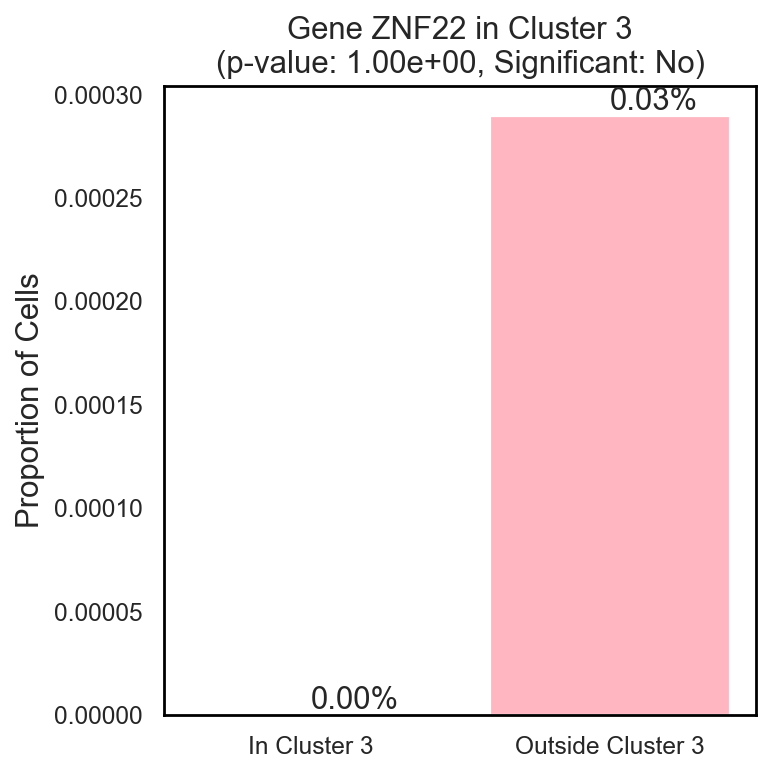

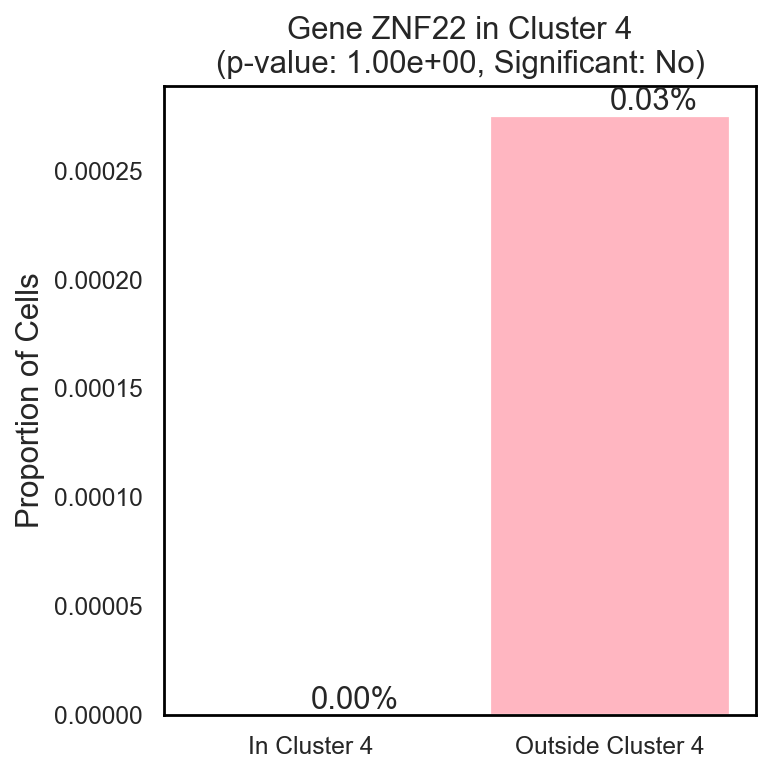

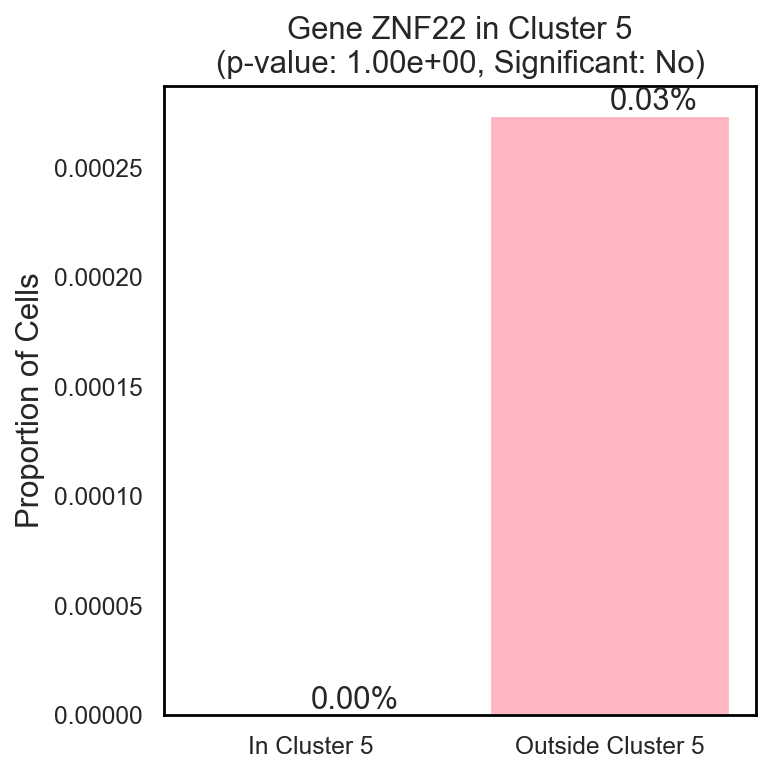

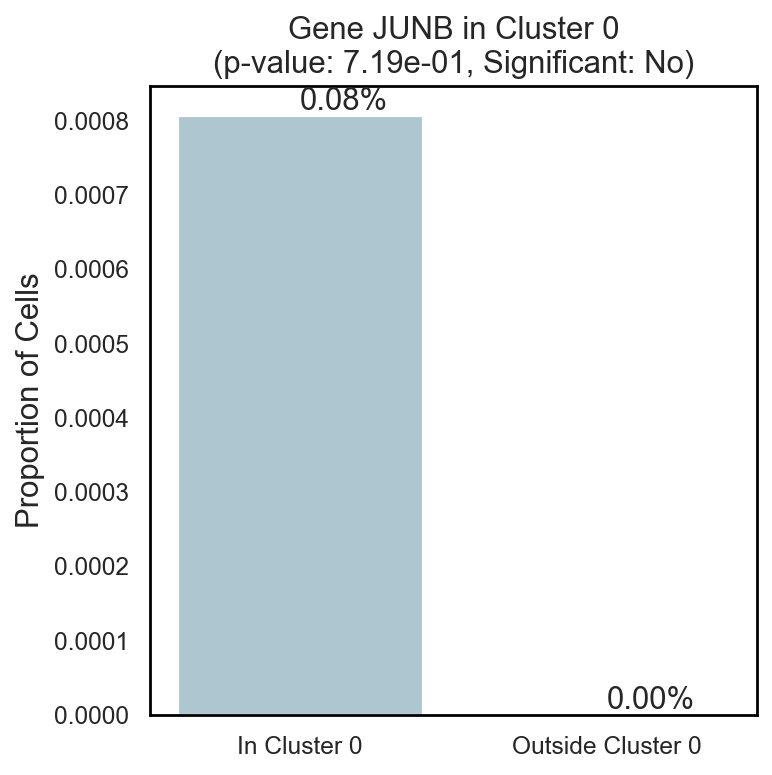

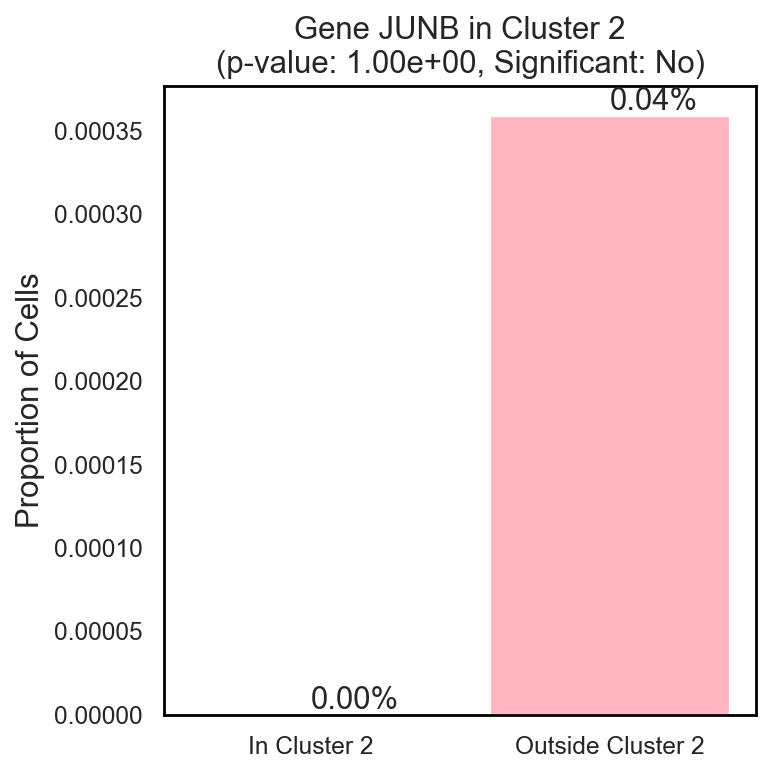

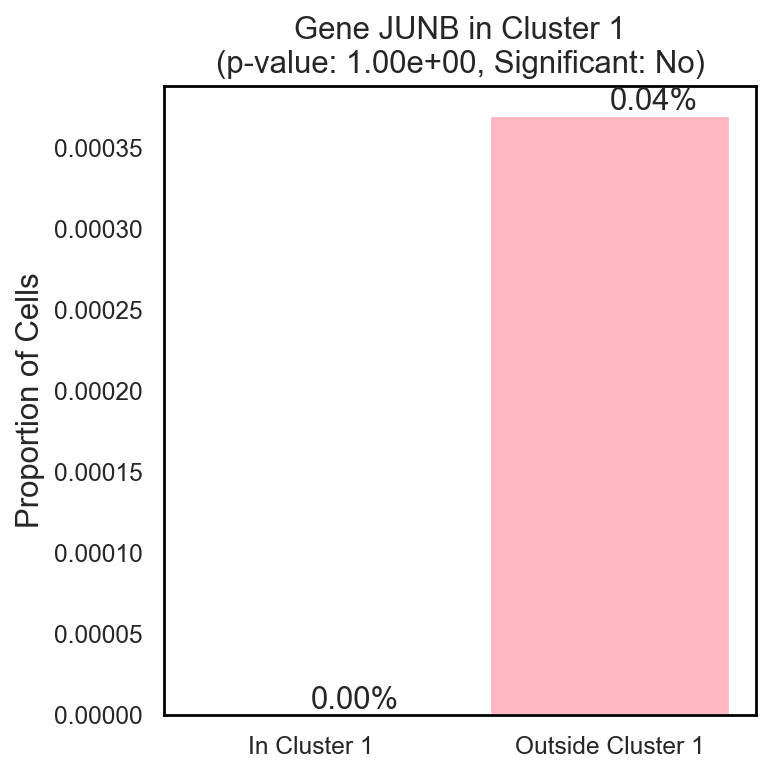

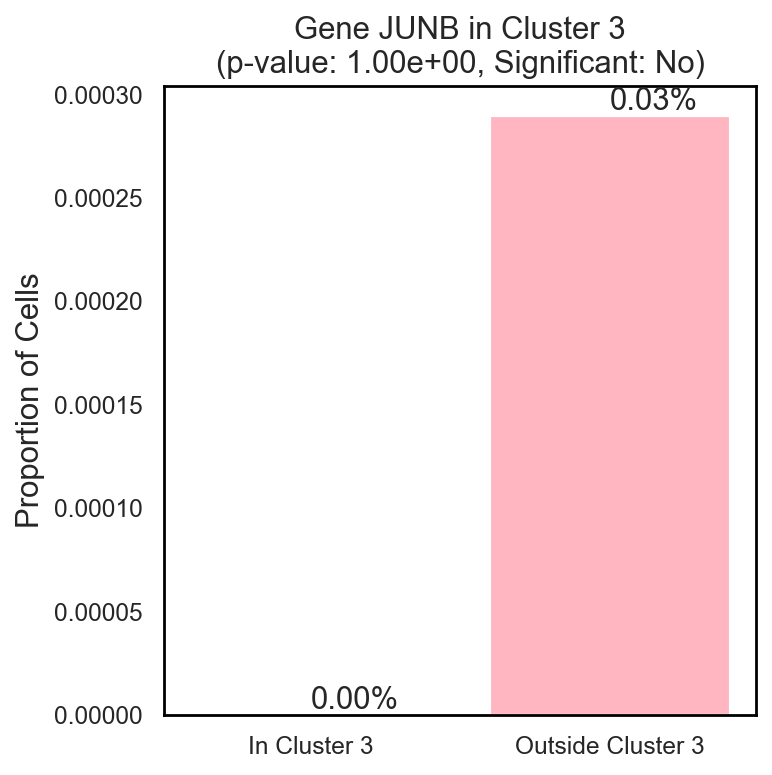

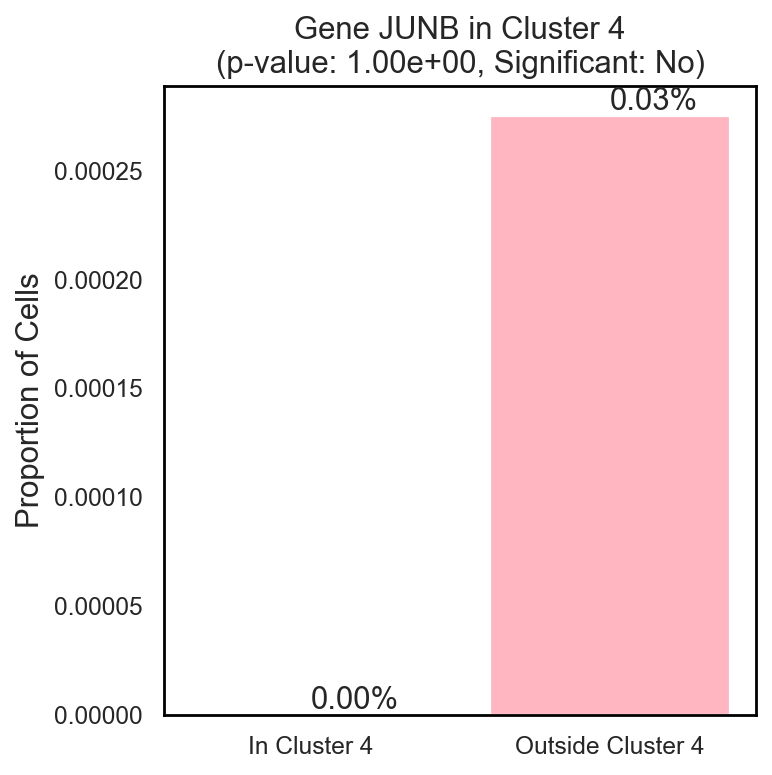

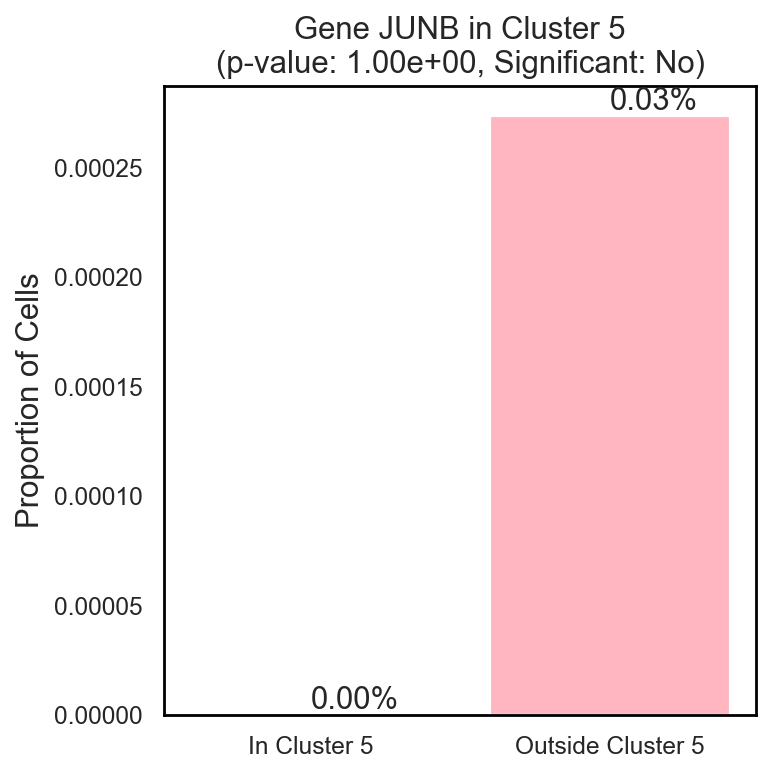

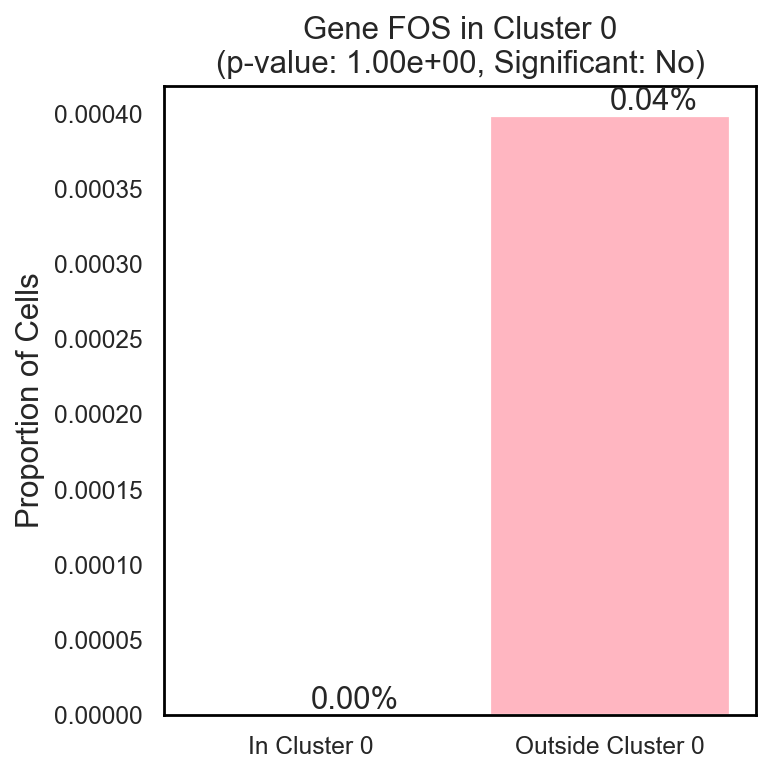

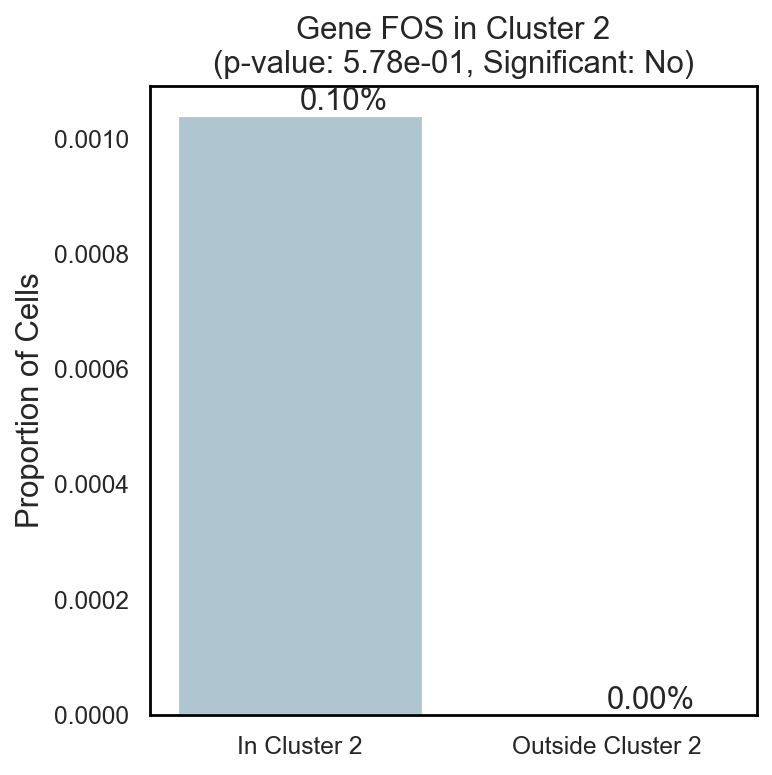

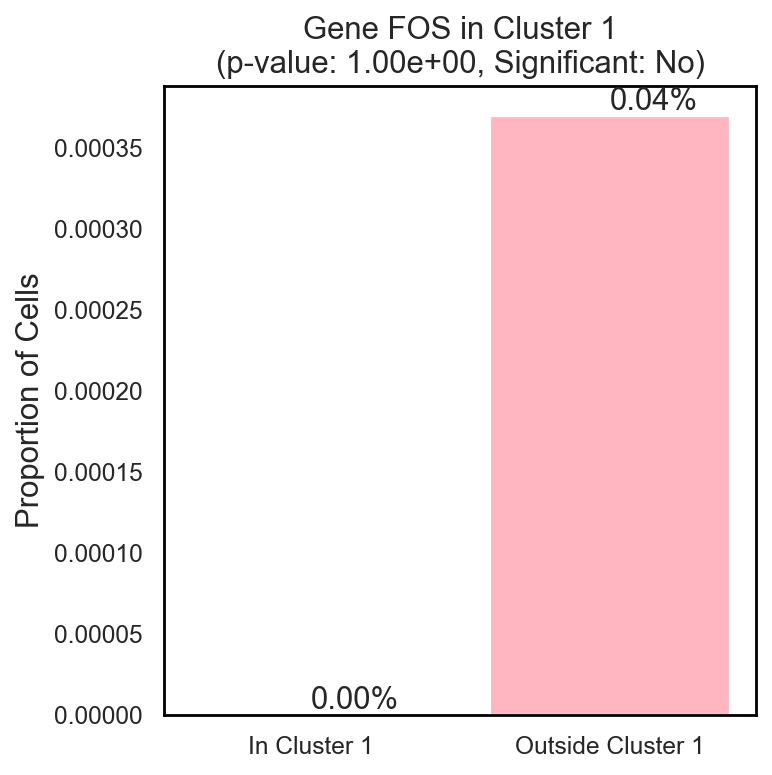

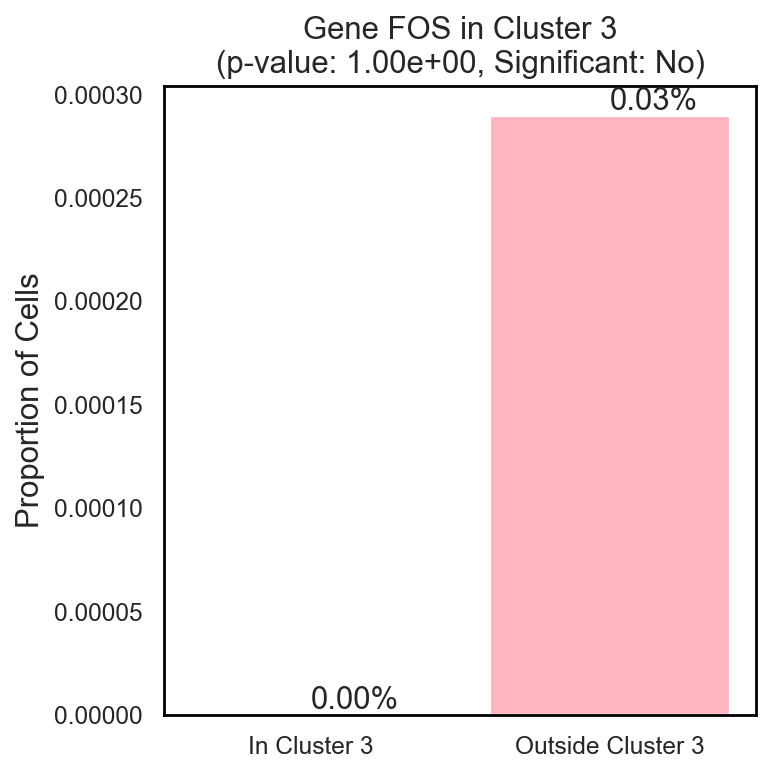

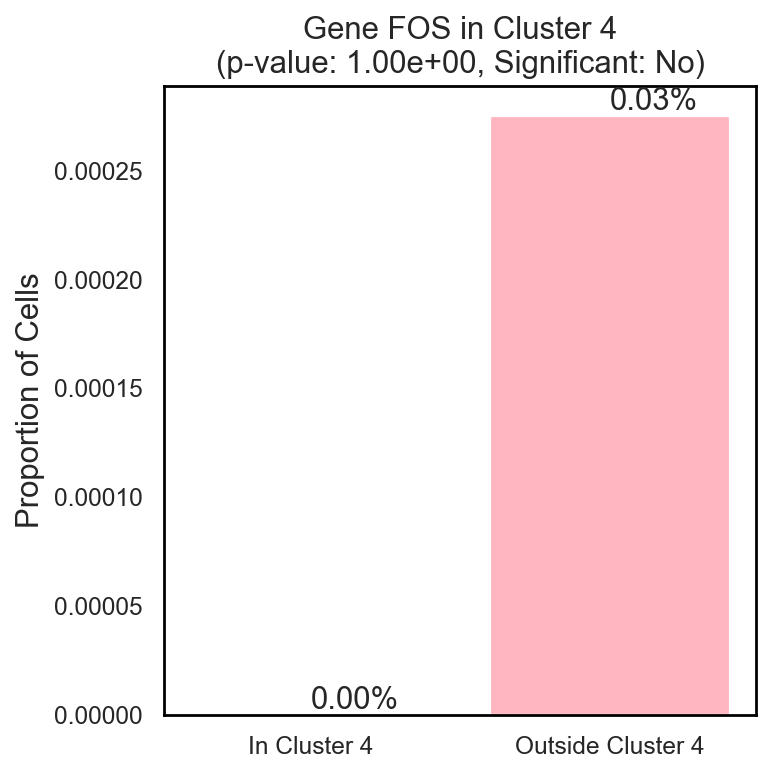

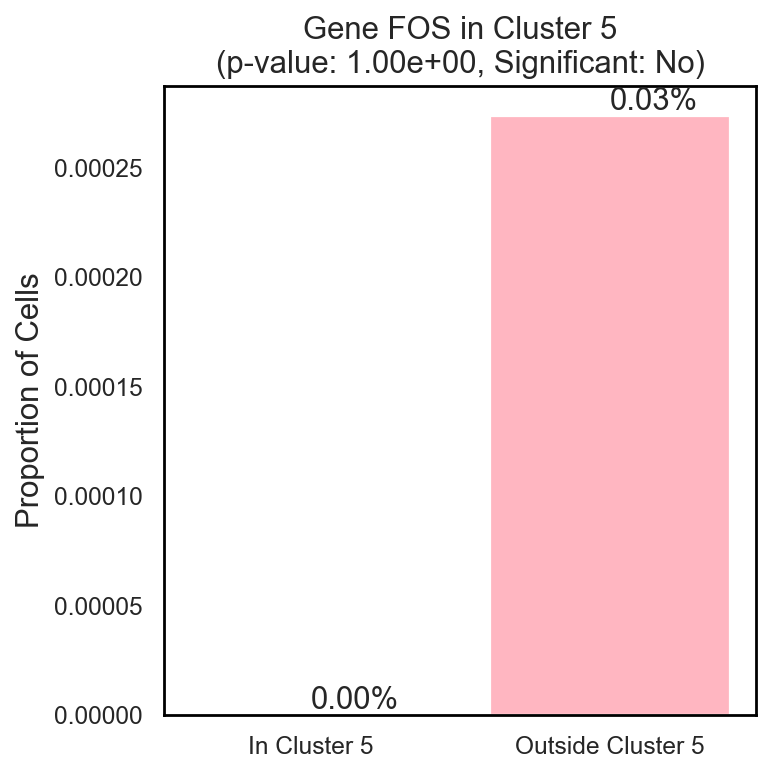

In [48]:


# Set a significance threshold
significance_threshold = 0.05

# Unique genes excluding 'control'
unique_genes = adata.obs['Gene'].unique()
unique_genes = unique_genes[unique_genes != 'control']

# Iterate over each unique gene
for gene in unique_genes:
    # Iterate over each cluster
    for cluster in adata.obs['leiden'].unique():
        # Construct a contingency table
        contingency_table = pd.DataFrame(
            [
                # Cells with current gene in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] != cluster)).sum(),
                ],
                # Control cells in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] != cluster)).sum(),
                ],
            ],
            index=[f"{gene}", "Control"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )

        # Adjust for zeros if necessary
        epsilon = 1e-10
        contingency_table += epsilon

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold

        # Calculate proportions for visualization
        prop_gene_in_cluster = contingency_table.iloc[0, 0] / (contingency_table.iloc[0, 0] + contingency_table.iloc[1, 0])
        prop_gene_outside_cluster = contingency_table.iloc[0, 1] / (contingency_table.iloc[0, 1] + contingency_table.iloc[1, 1])

        # Data for plotting
        categories = [f'In Cluster {cluster}', f'Outside Cluster {cluster}']
        proportions = [prop_gene_in_cluster, prop_gene_outside_cluster]

        # Create bar chart
        plt.figure(figsize=(5, 5))
        bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])

        # Add a border and remove gridlines
        for spine in plt.gca().spines.values():
            spine.set_visible(True)
            spine.set_color('black')
        plt.grid(False)

        # Add labels and title
        plt.ylabel('Proportion of Cells', fontsize=14)
        plt.title(f'Gene {gene} in Cluster {cluster}\n(p-value: {p:.2e}, Significant: {"Yes" if is_significant else "No"})', fontsize=14)

        # Add value labels on each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=14)

        plt.tight_layout()
        plt.show()

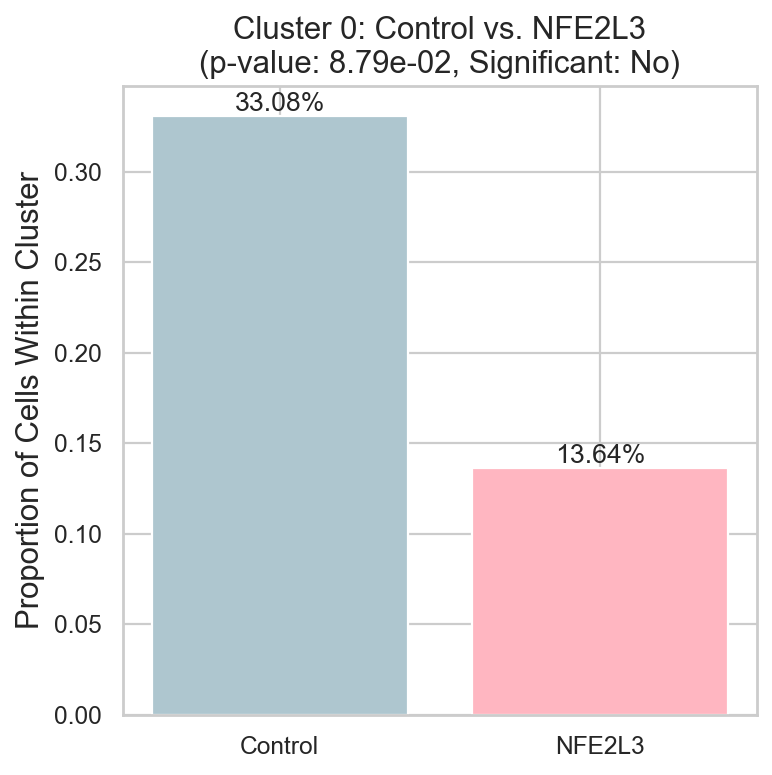

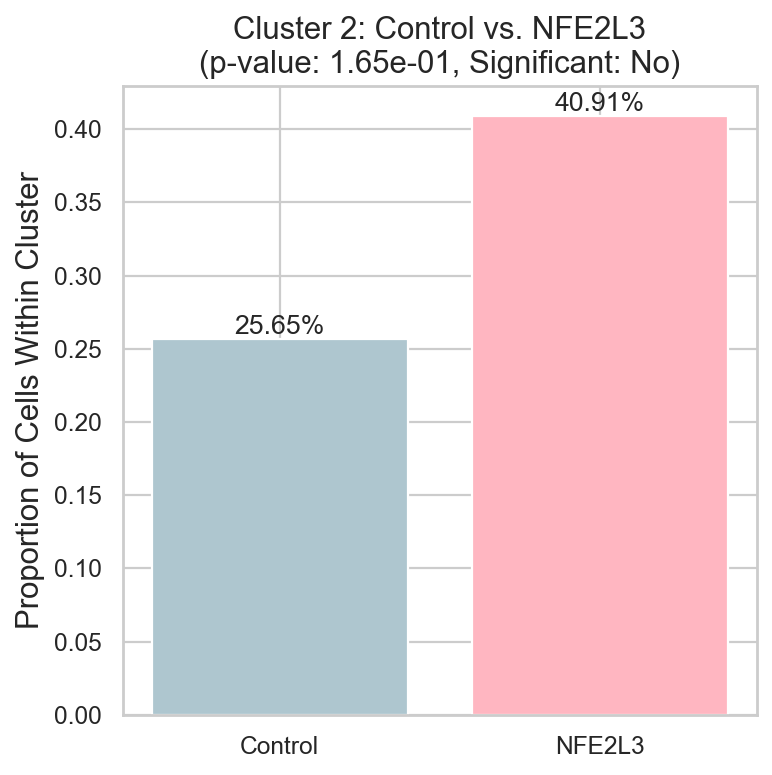

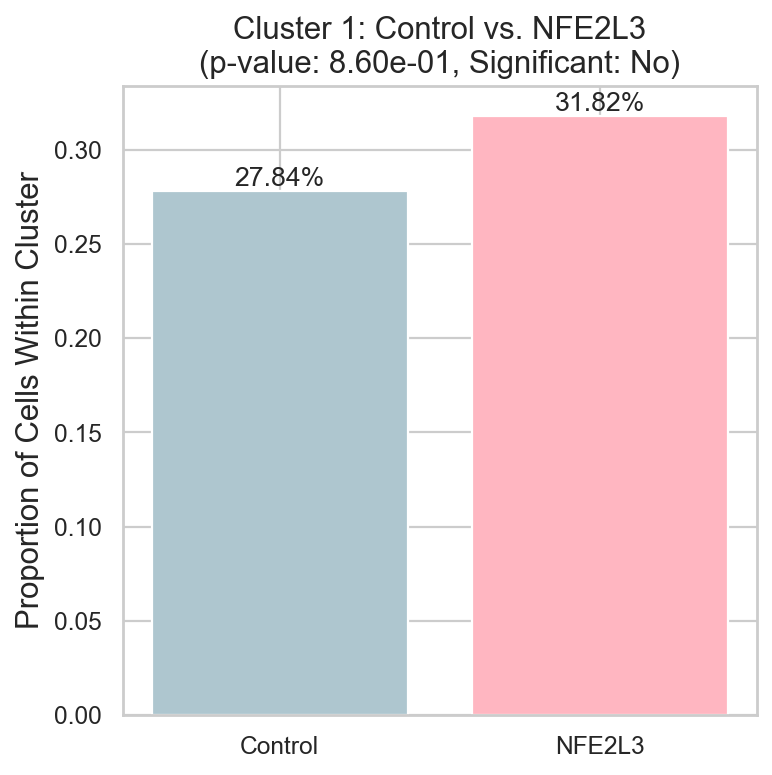

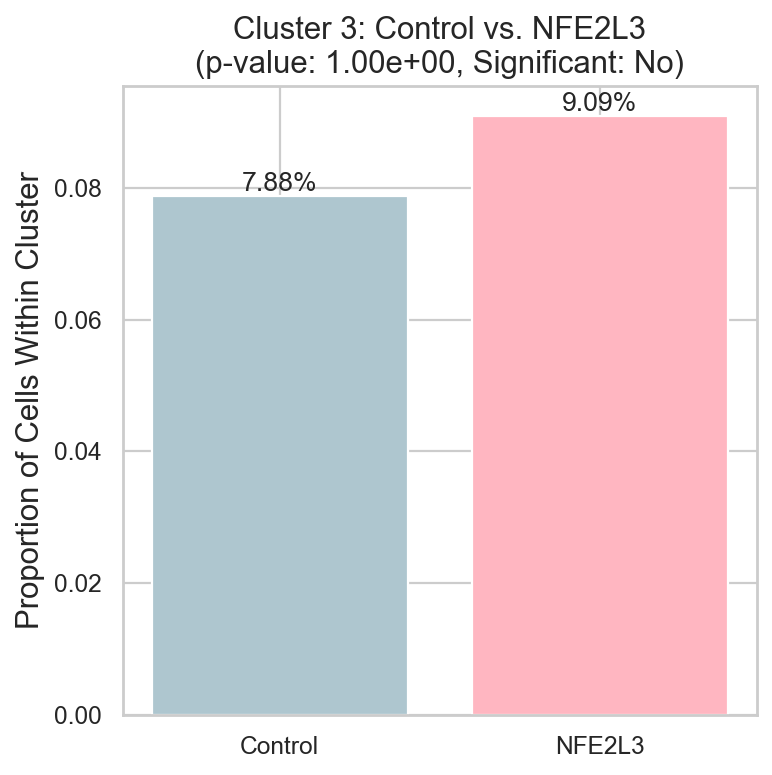

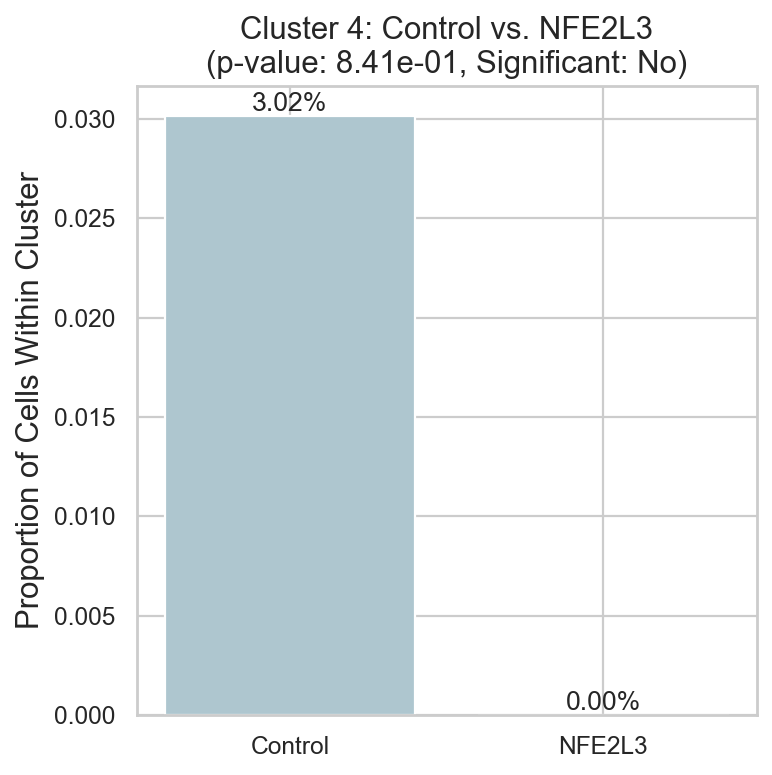

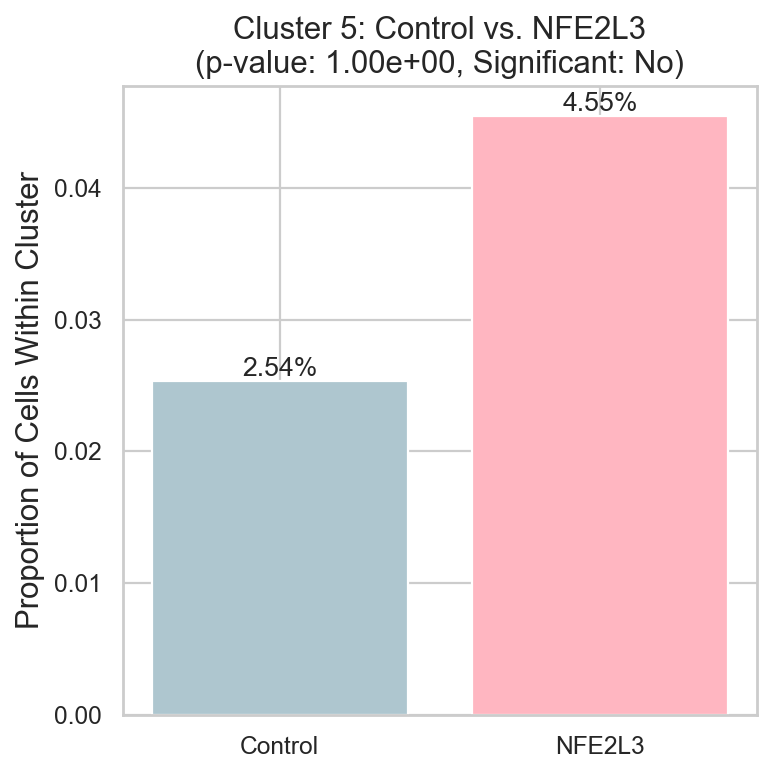

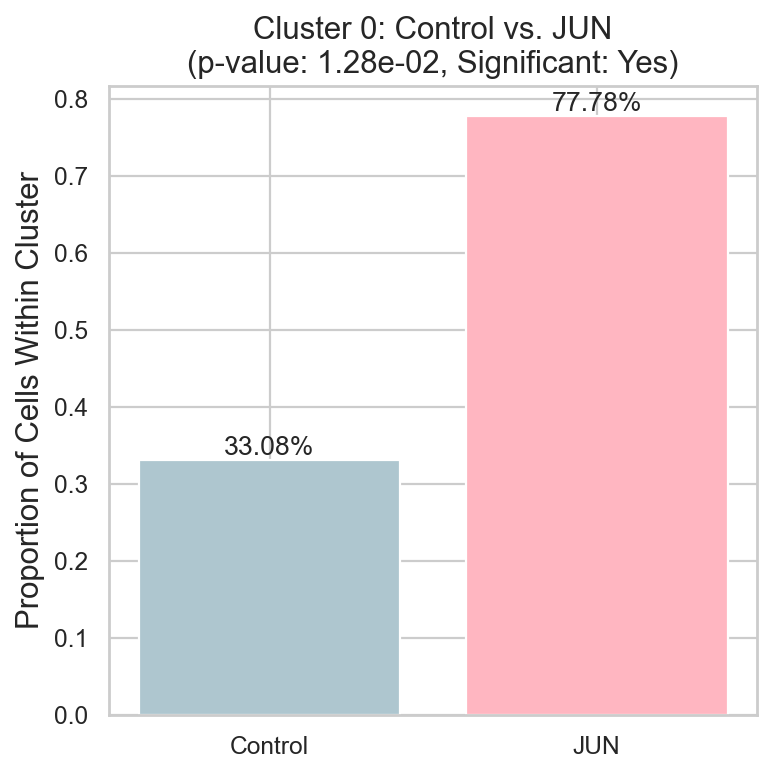

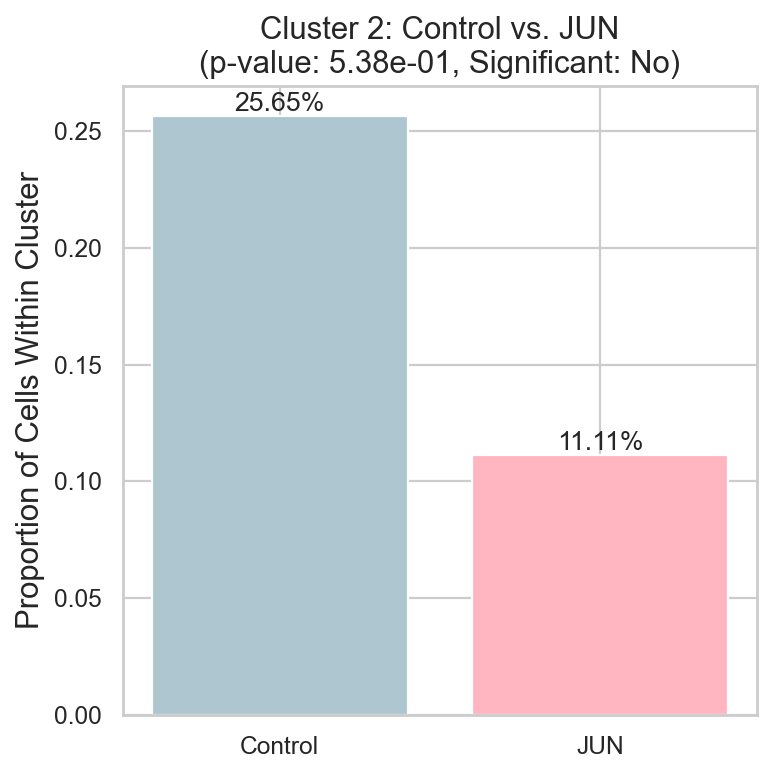

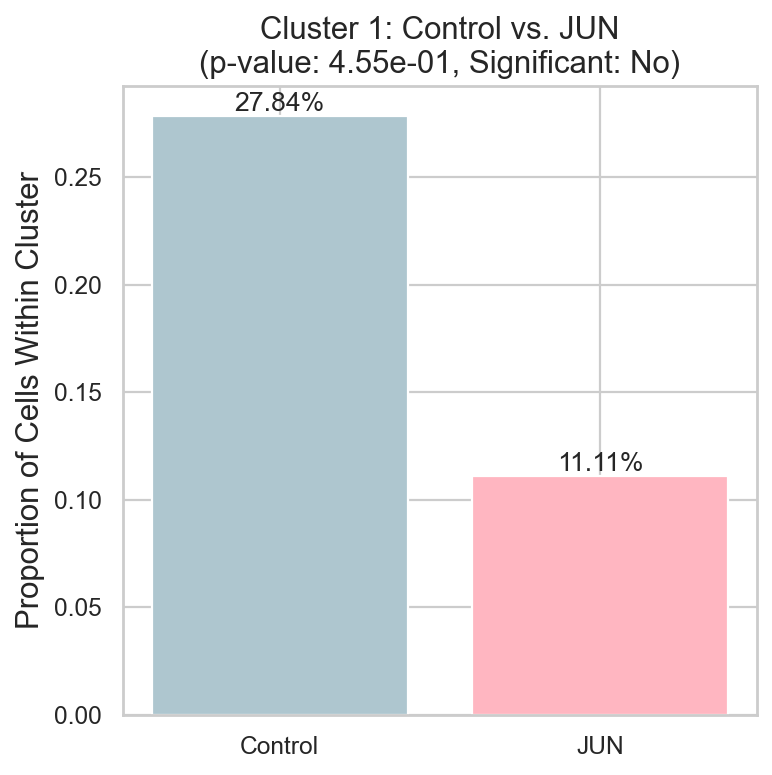

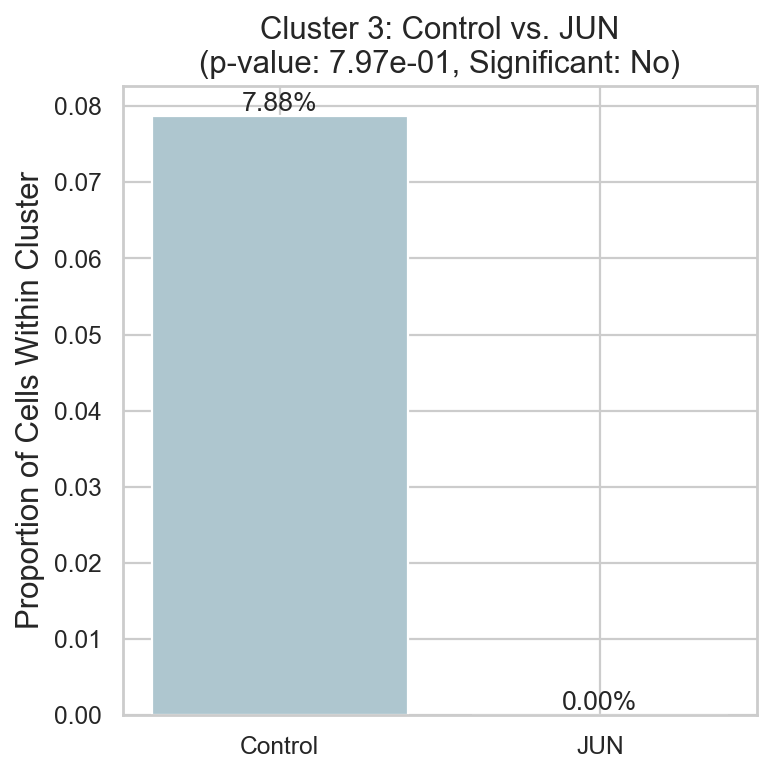

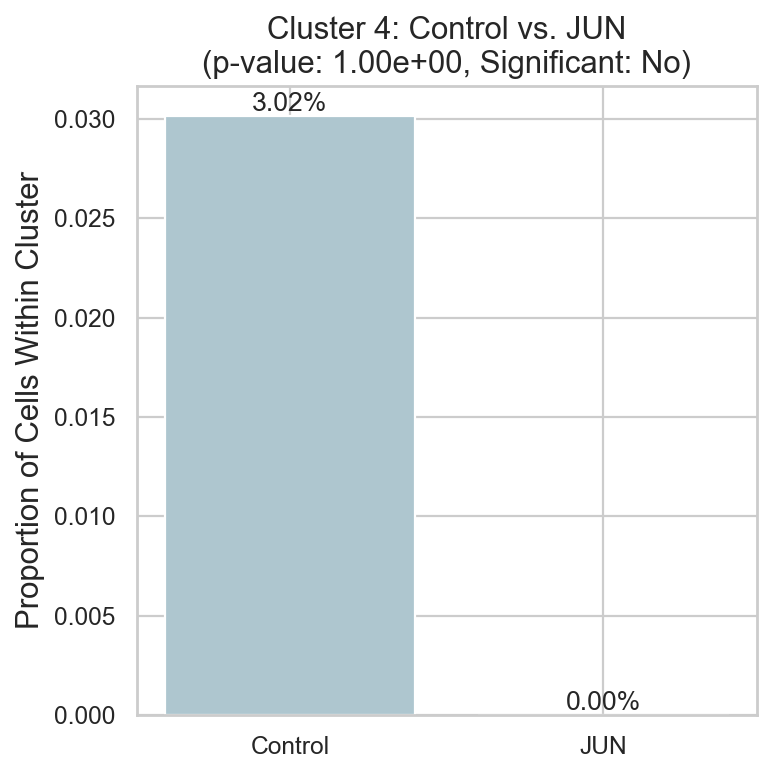

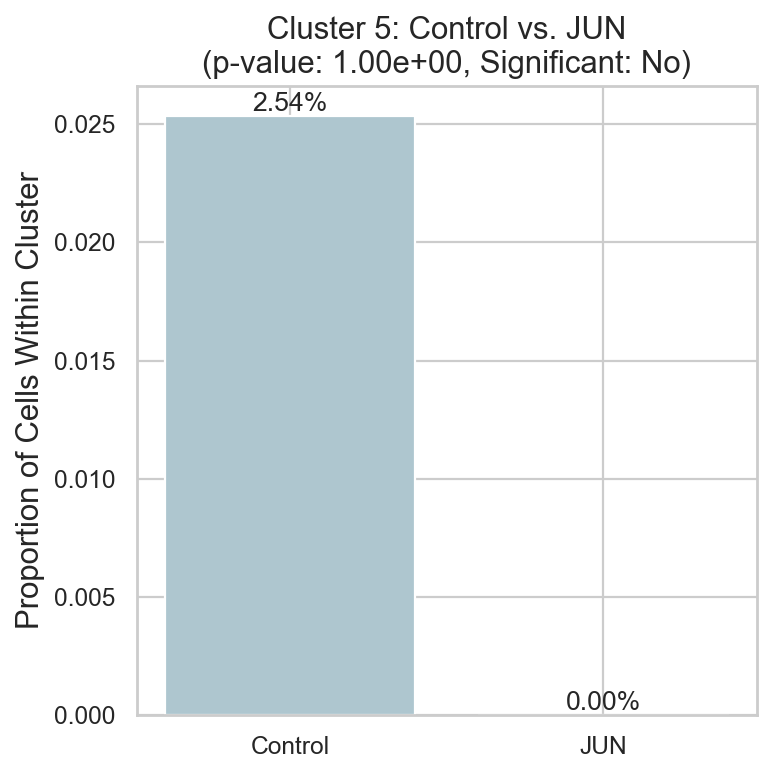

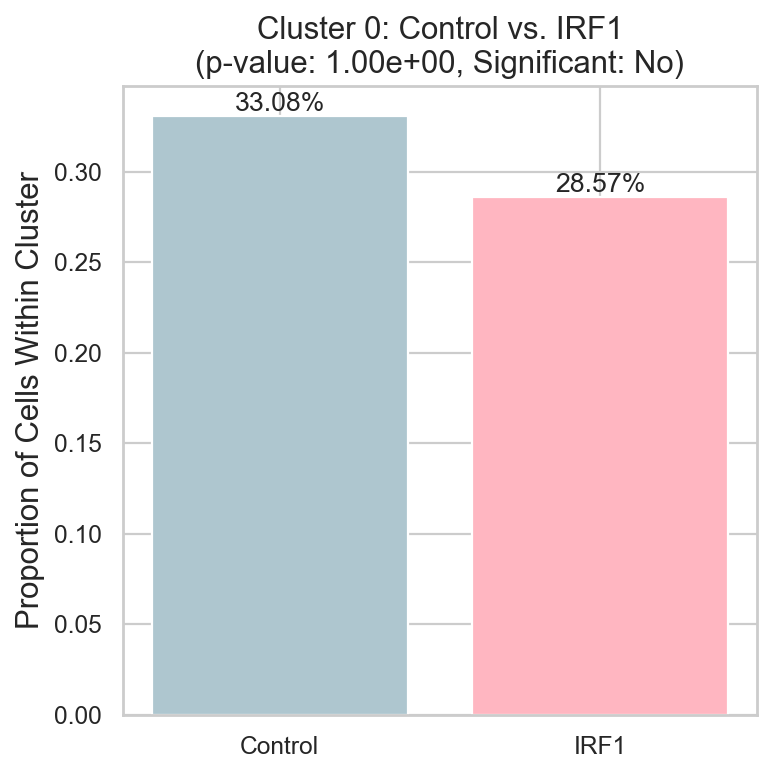

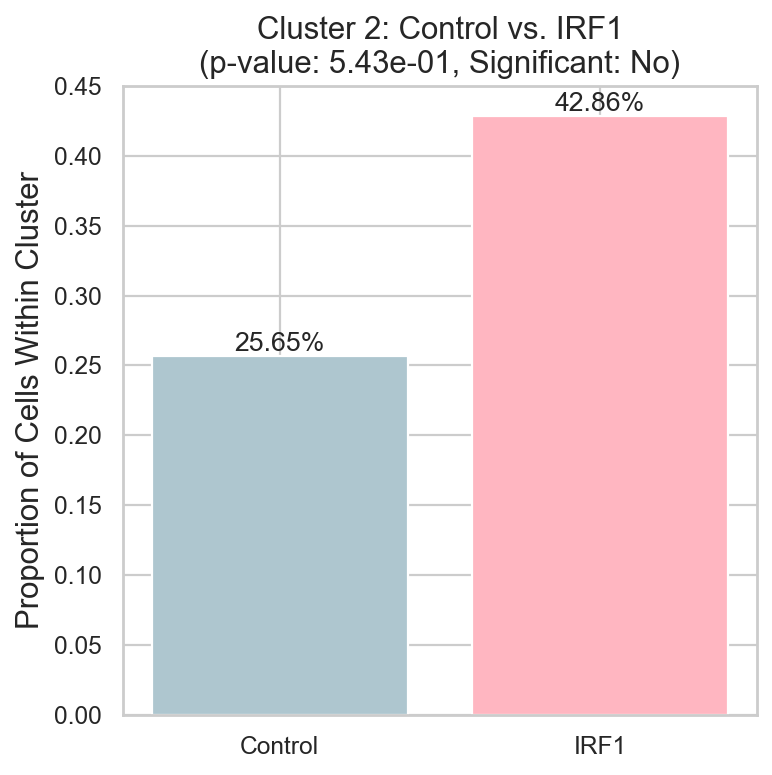

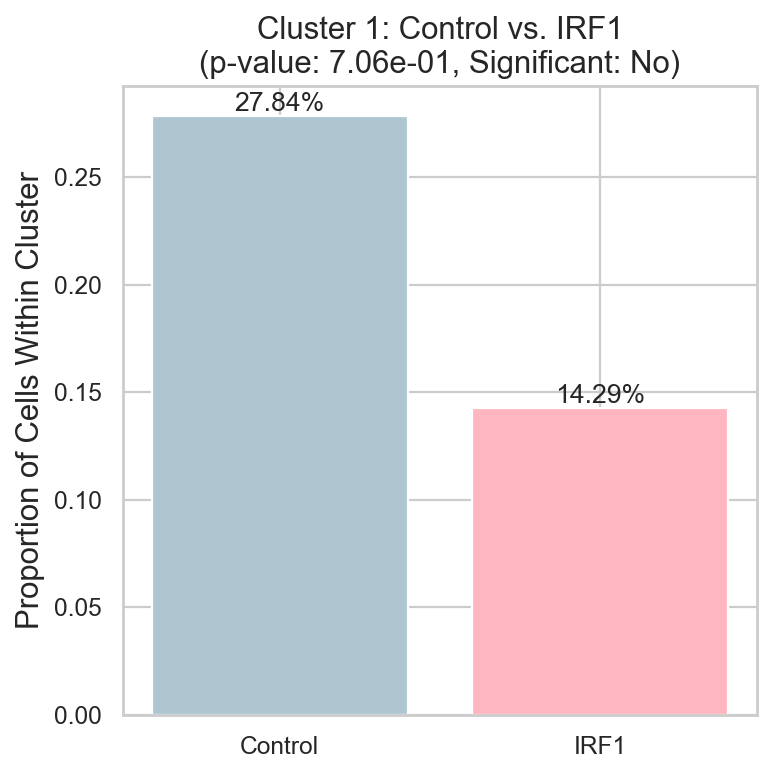

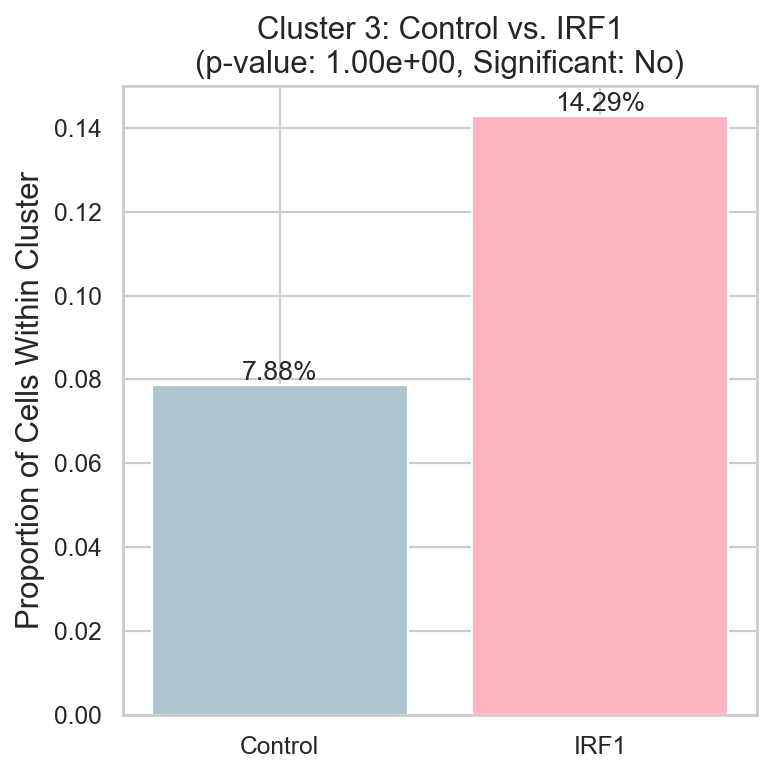

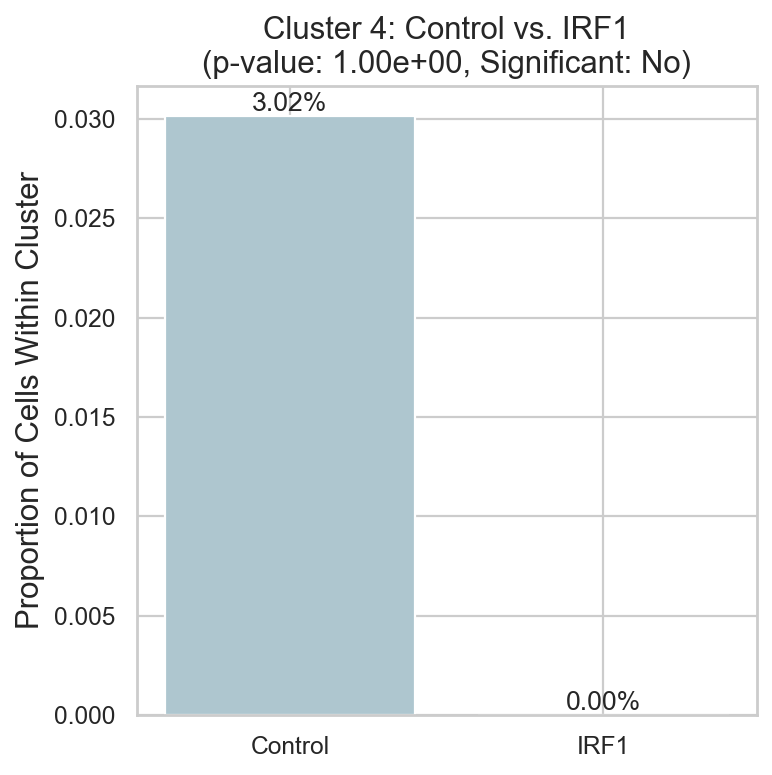

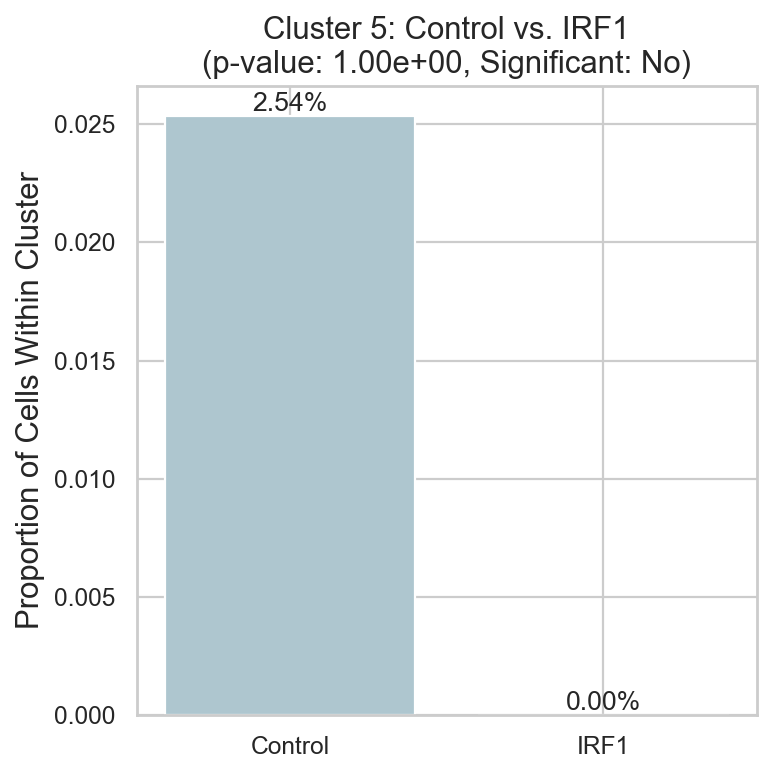

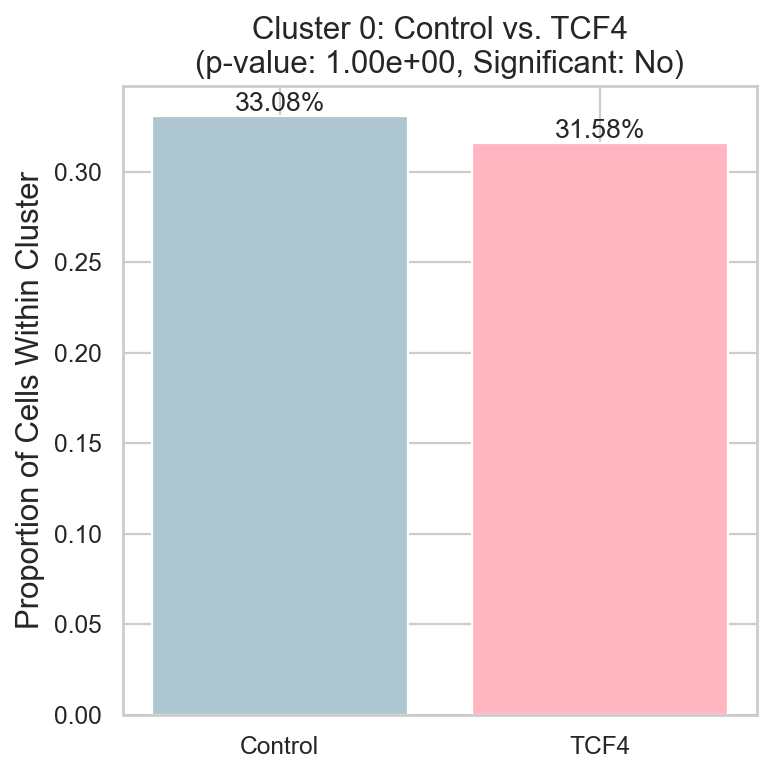

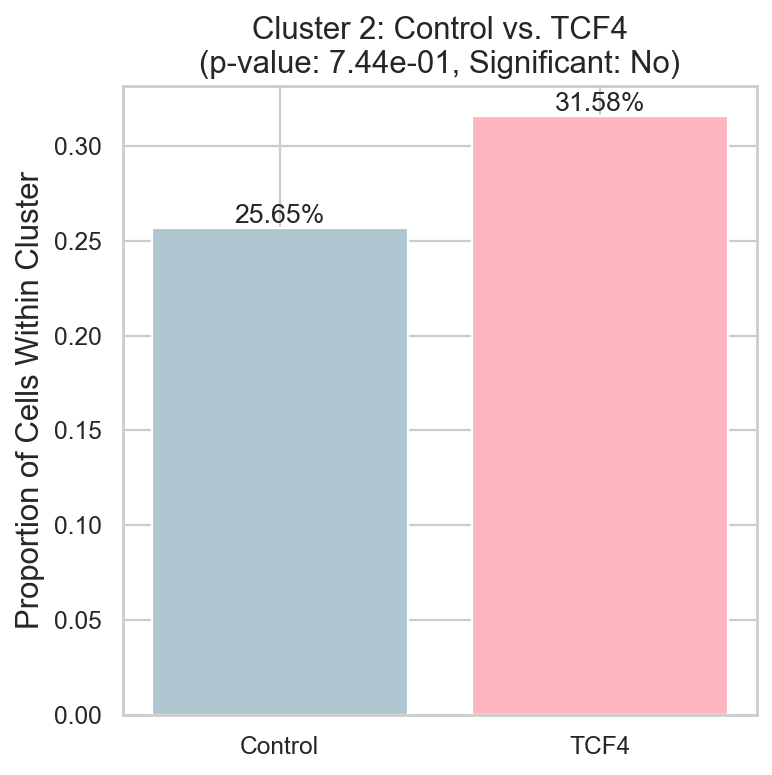

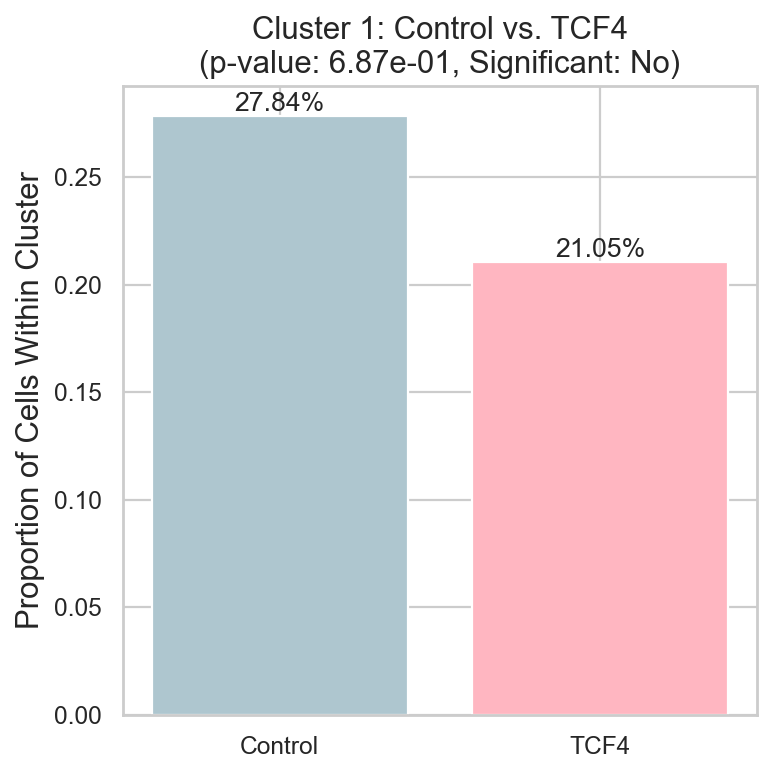

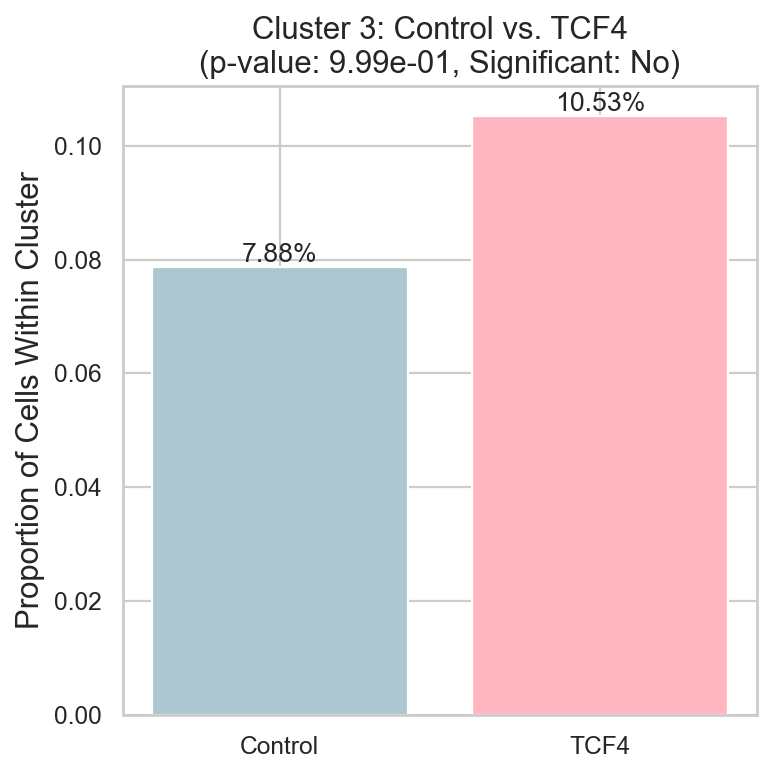

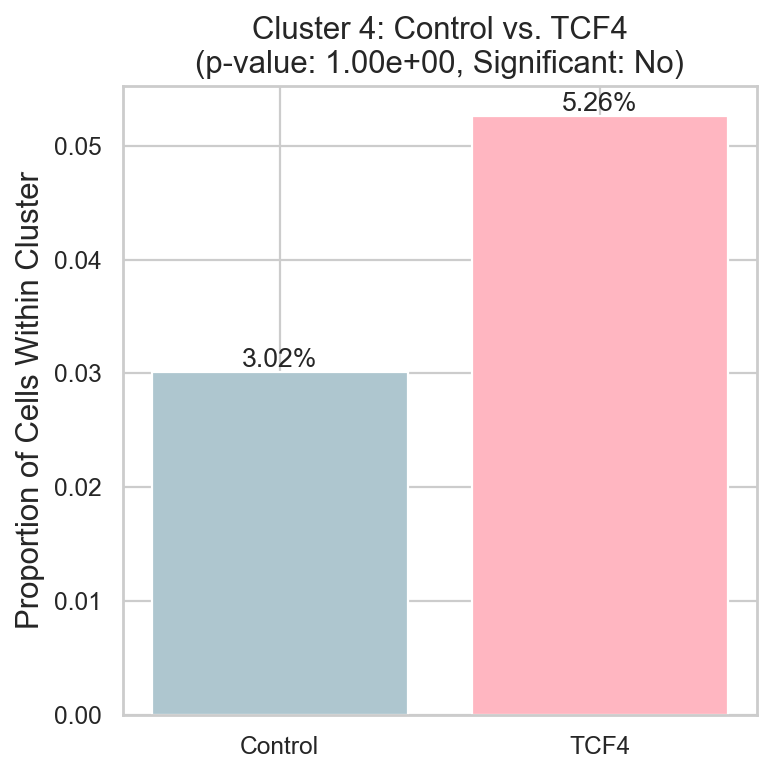

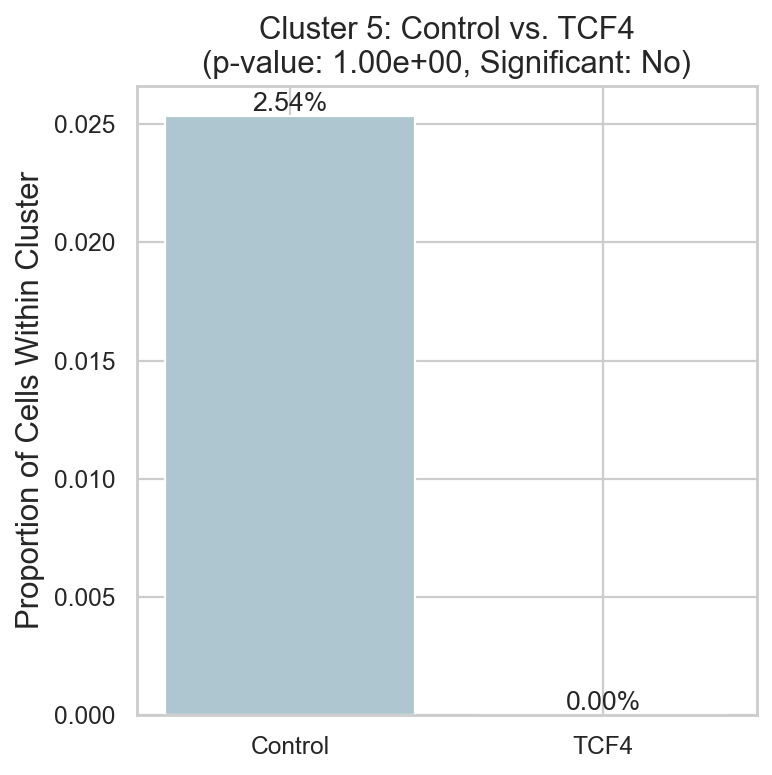

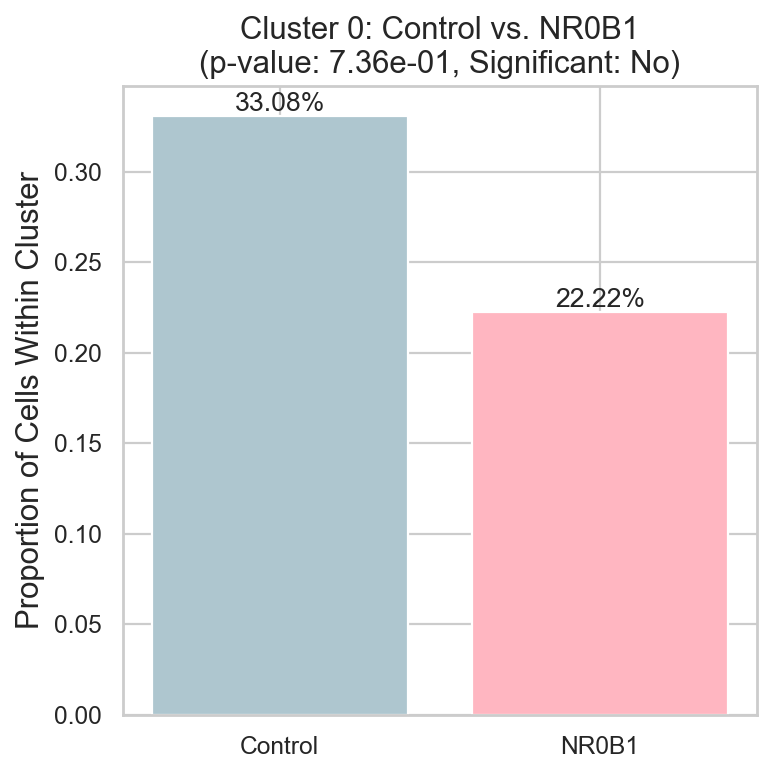

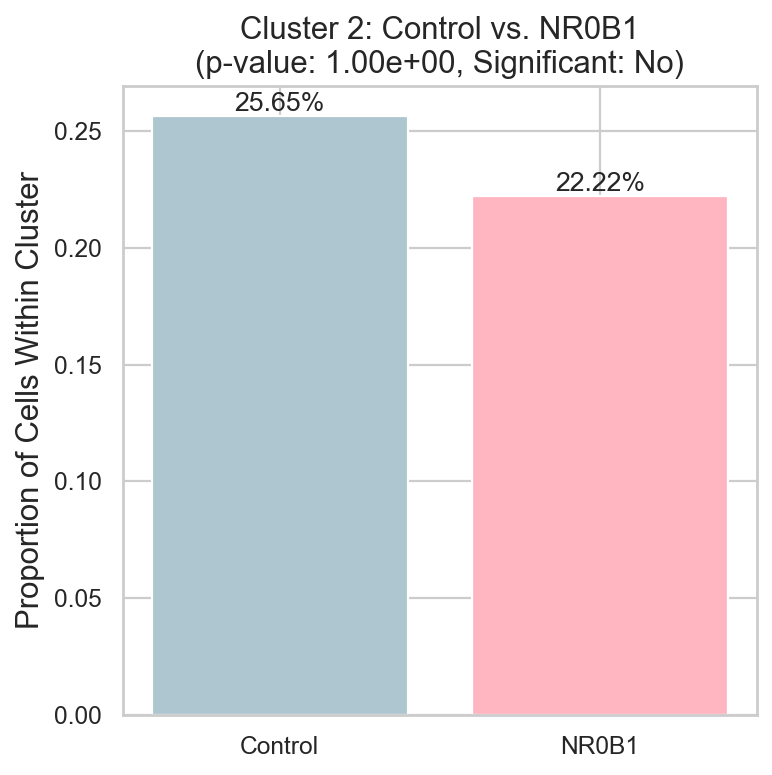

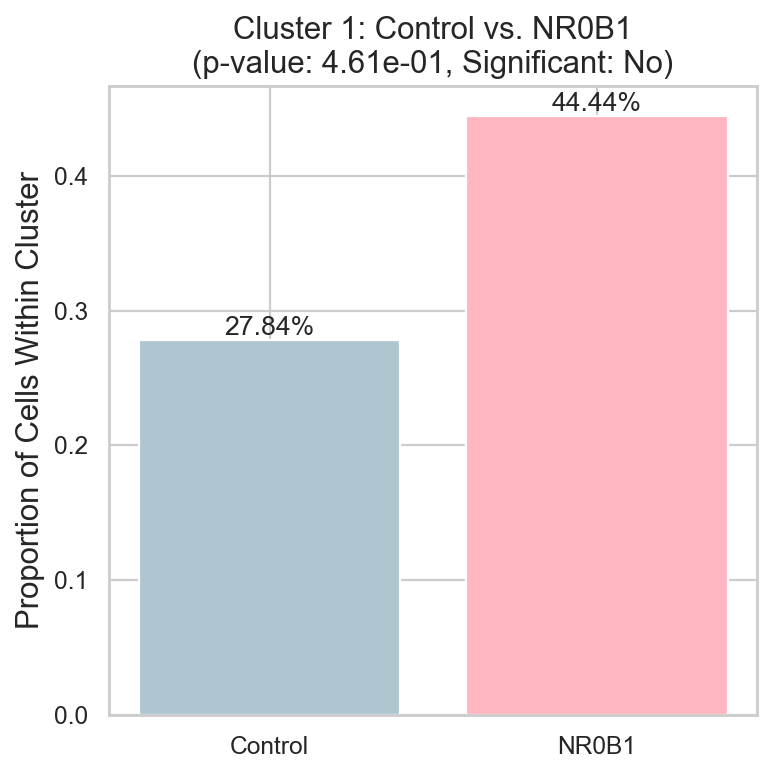

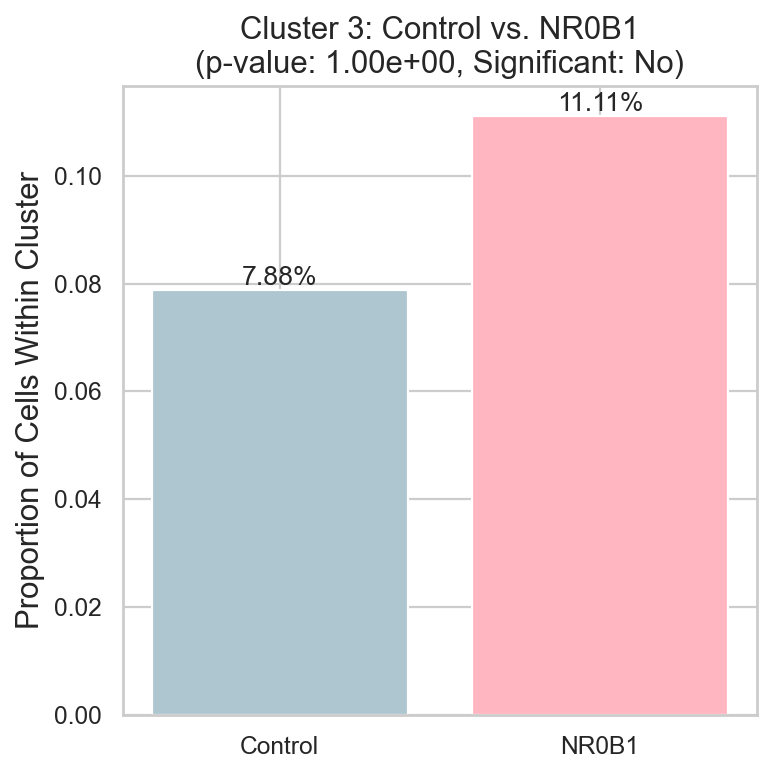

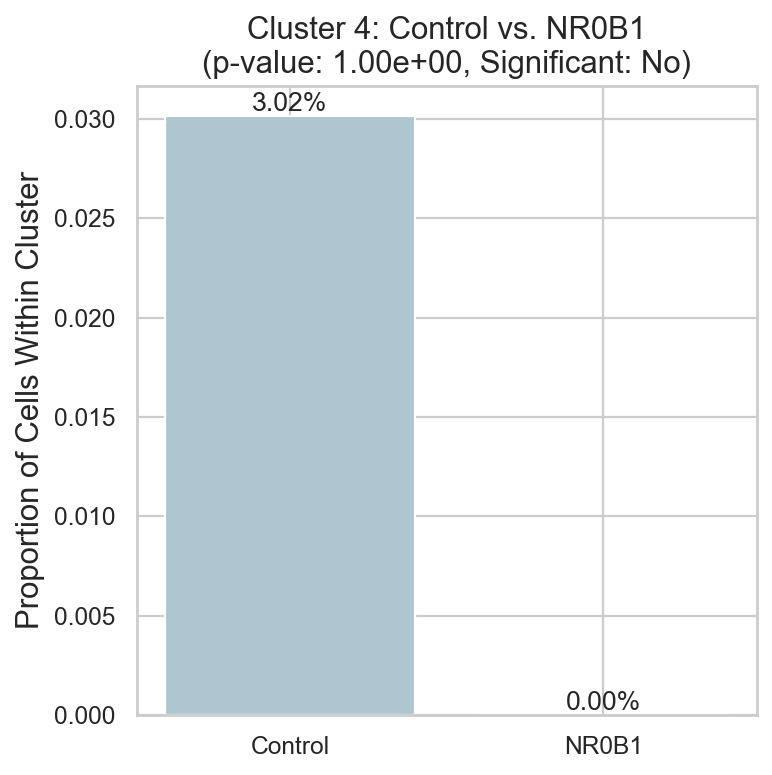

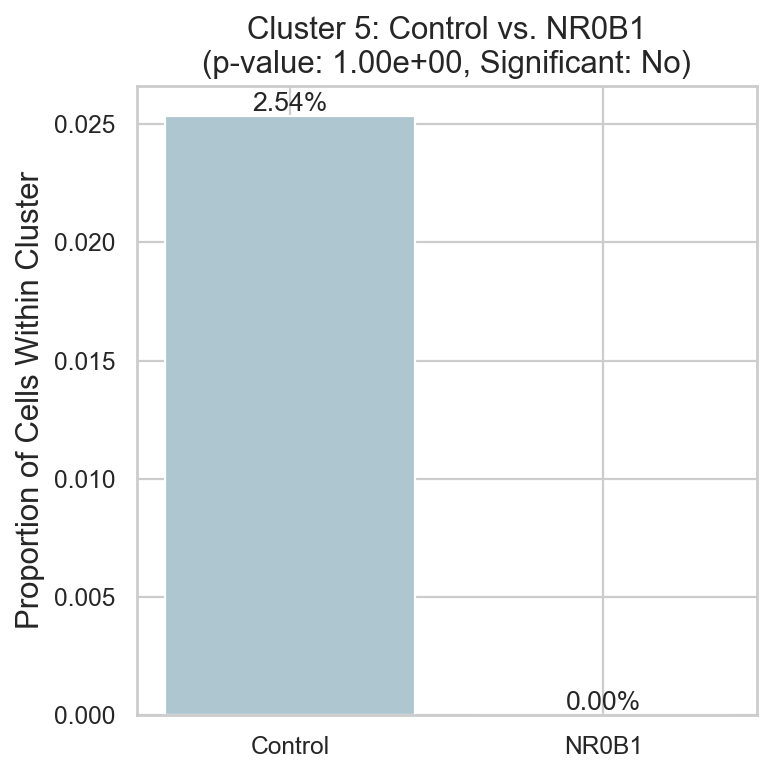

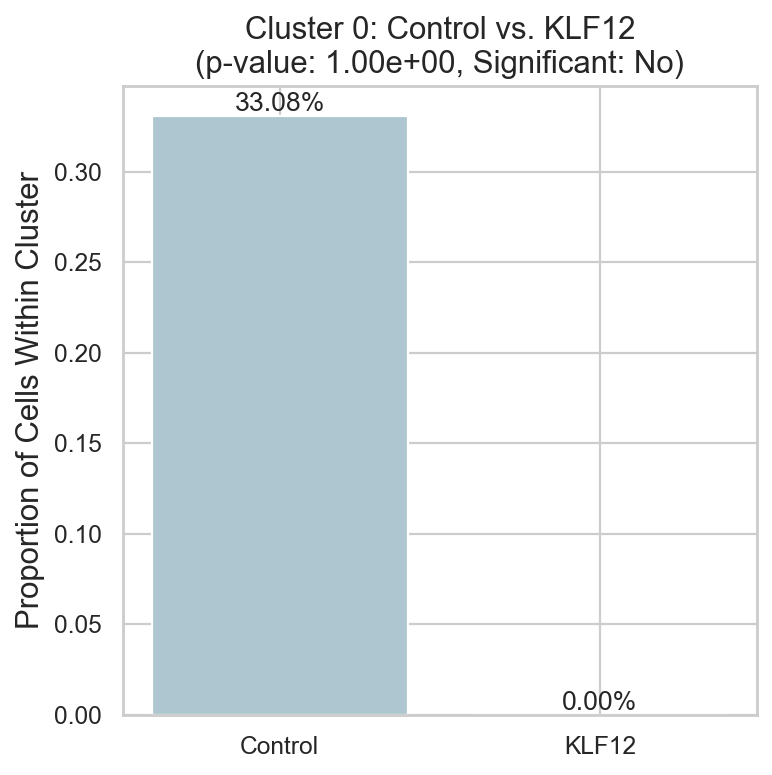

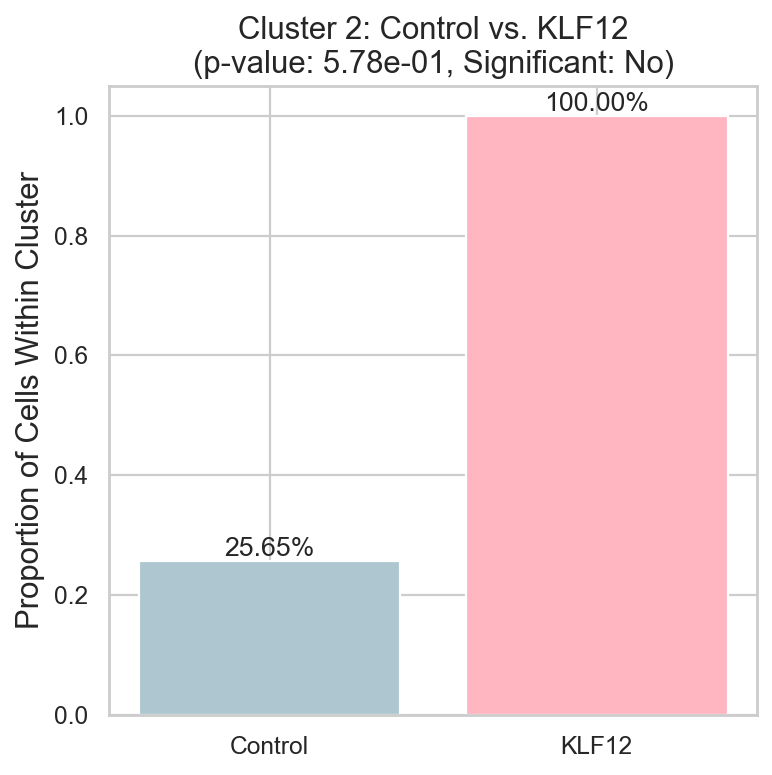

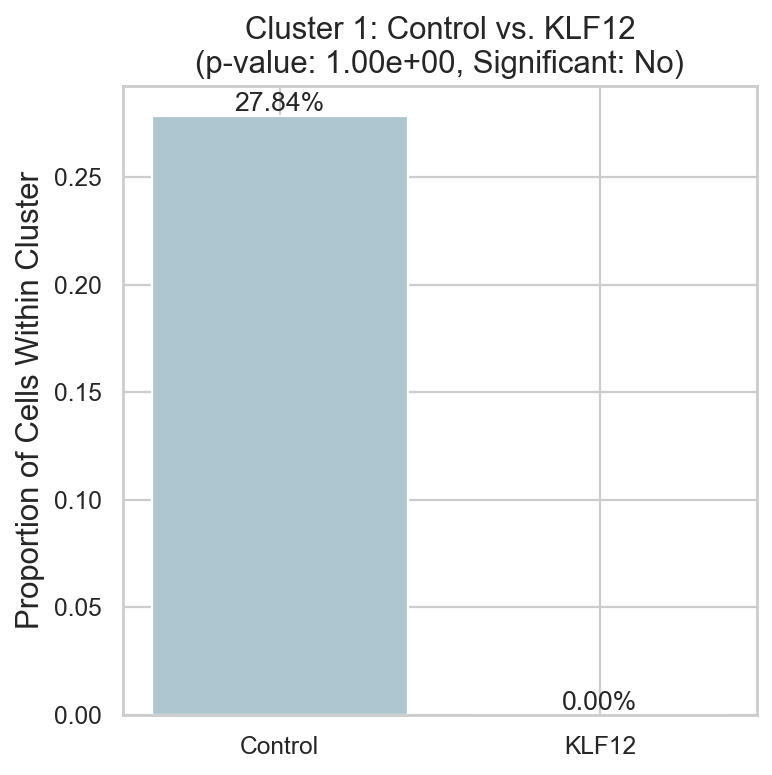

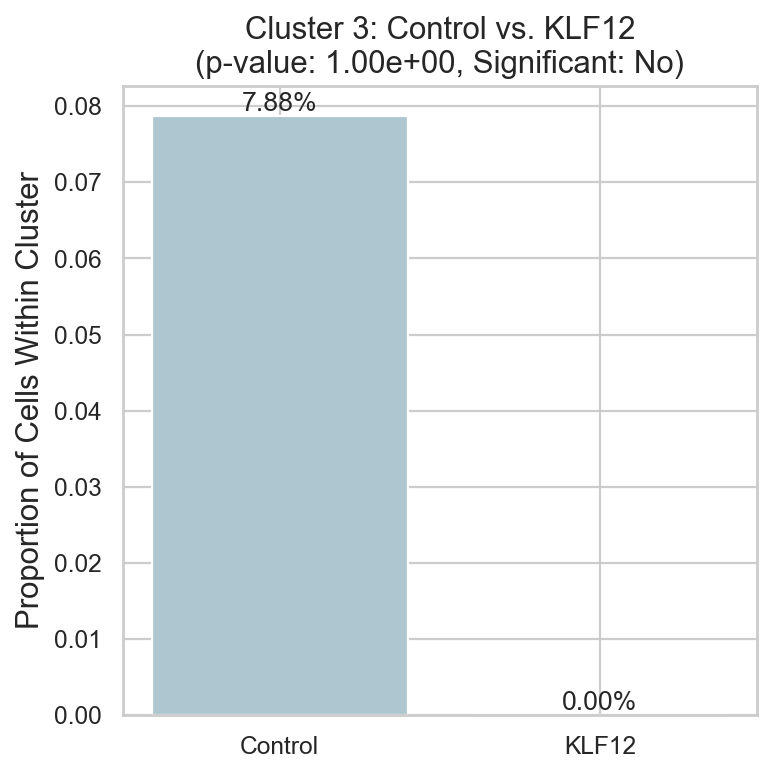

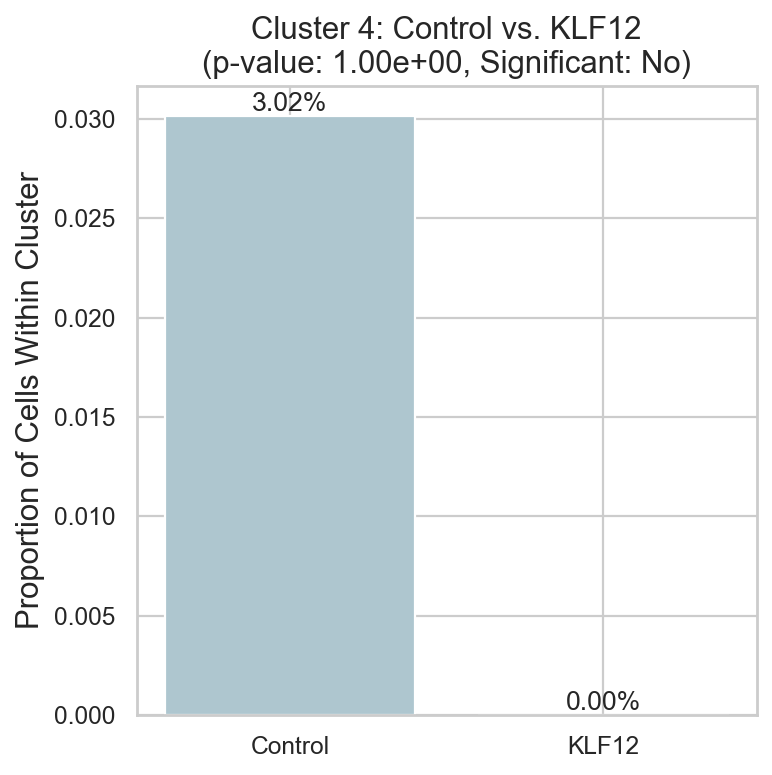

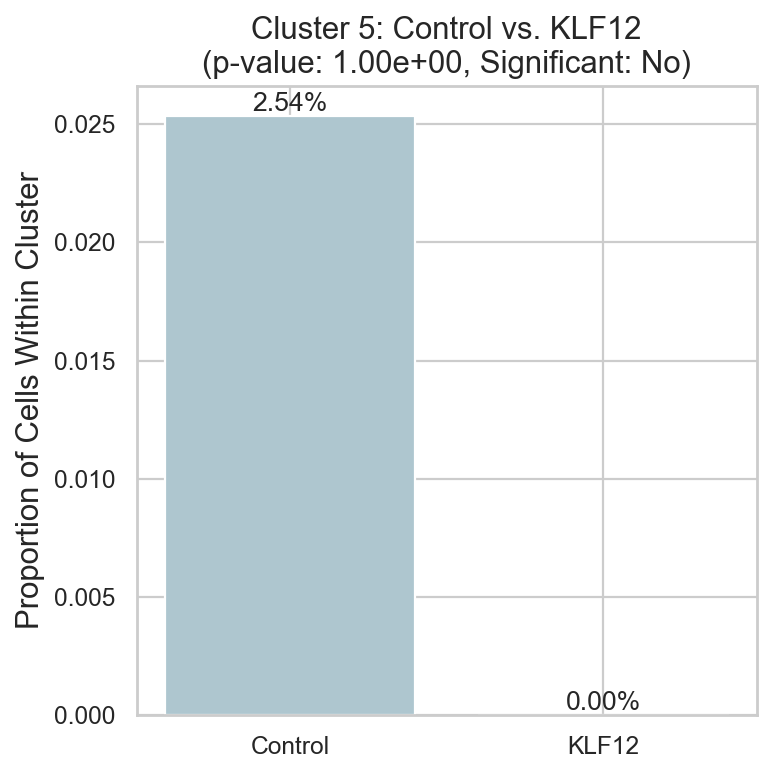

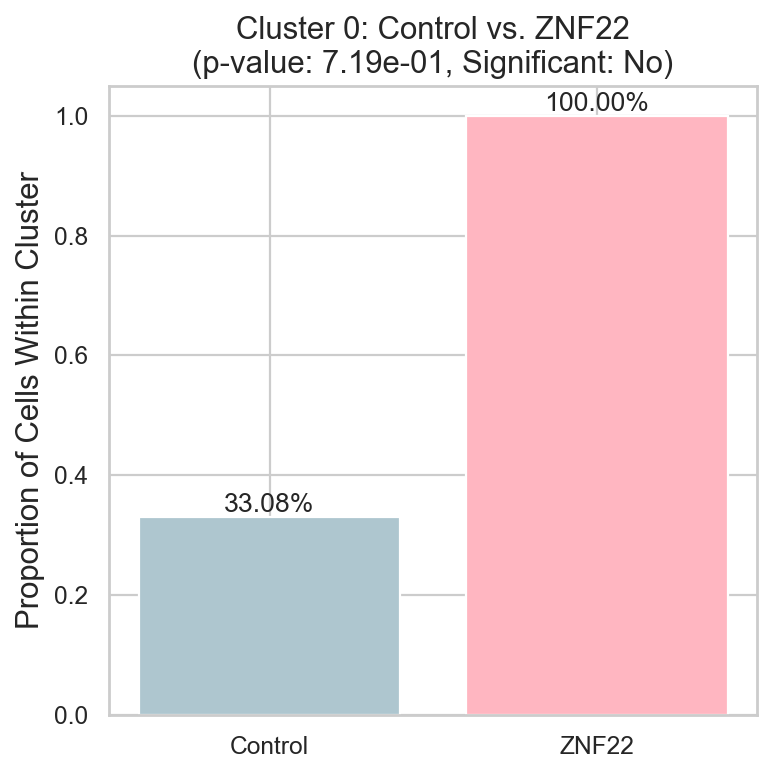

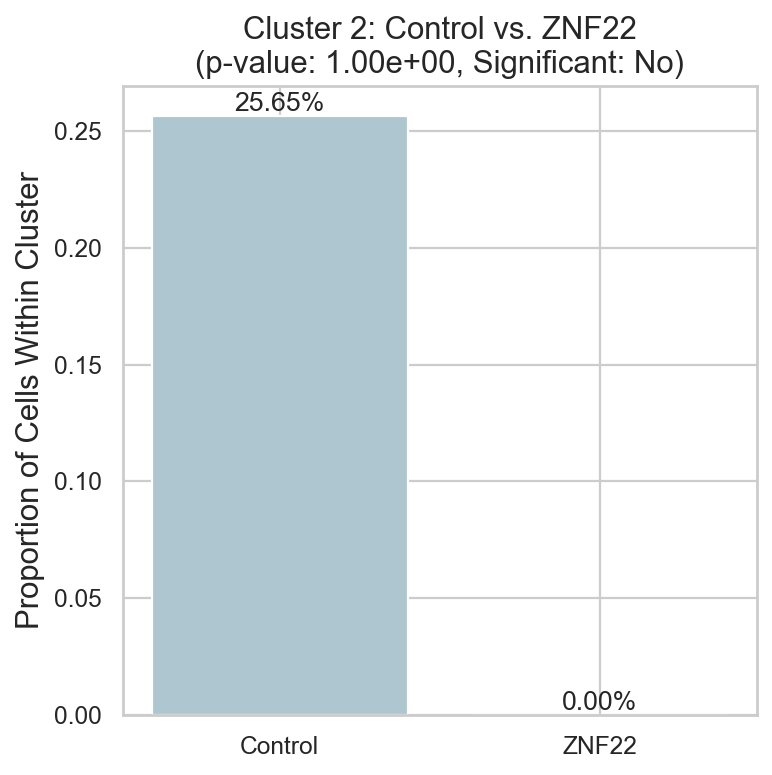

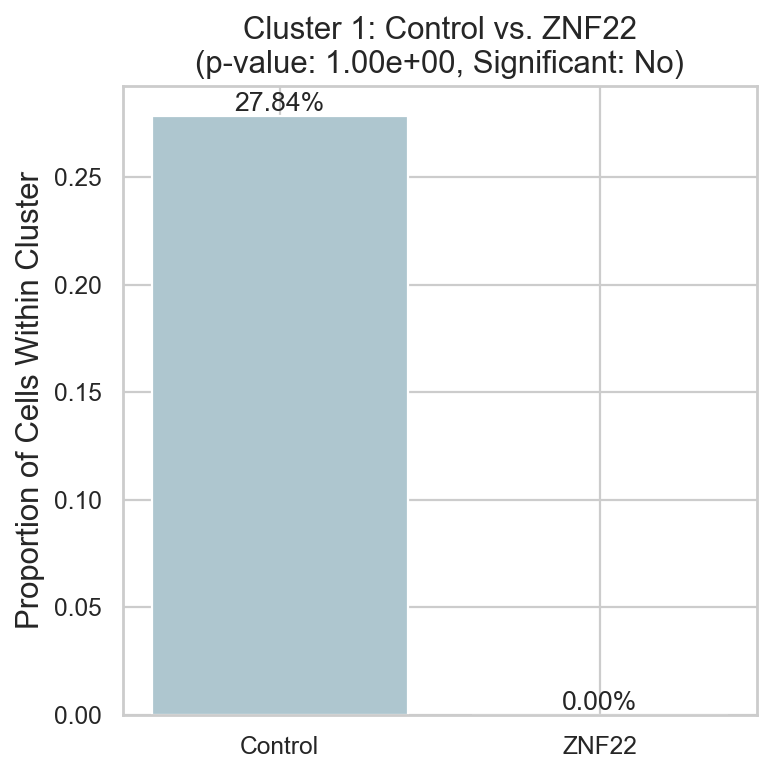

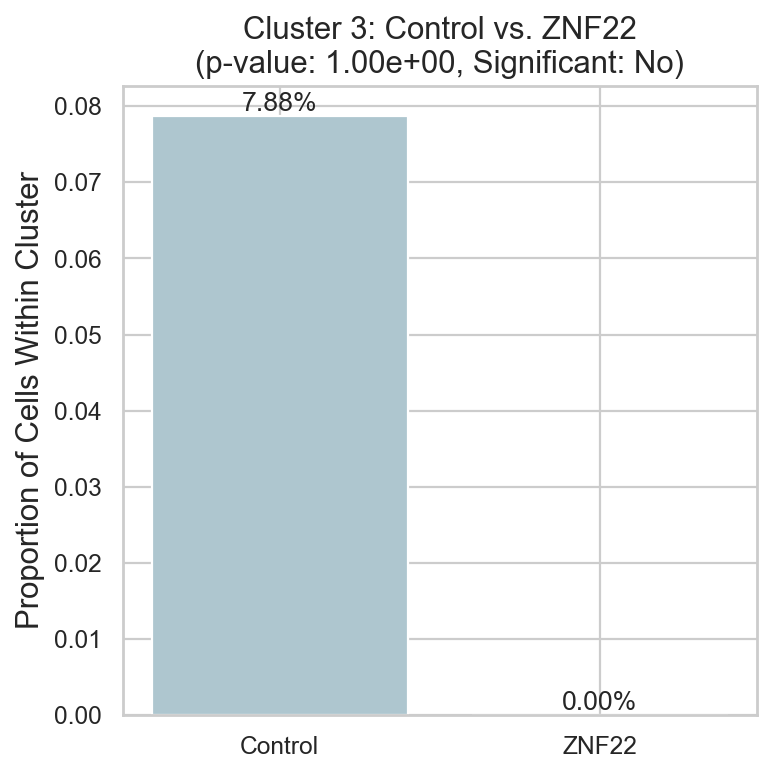

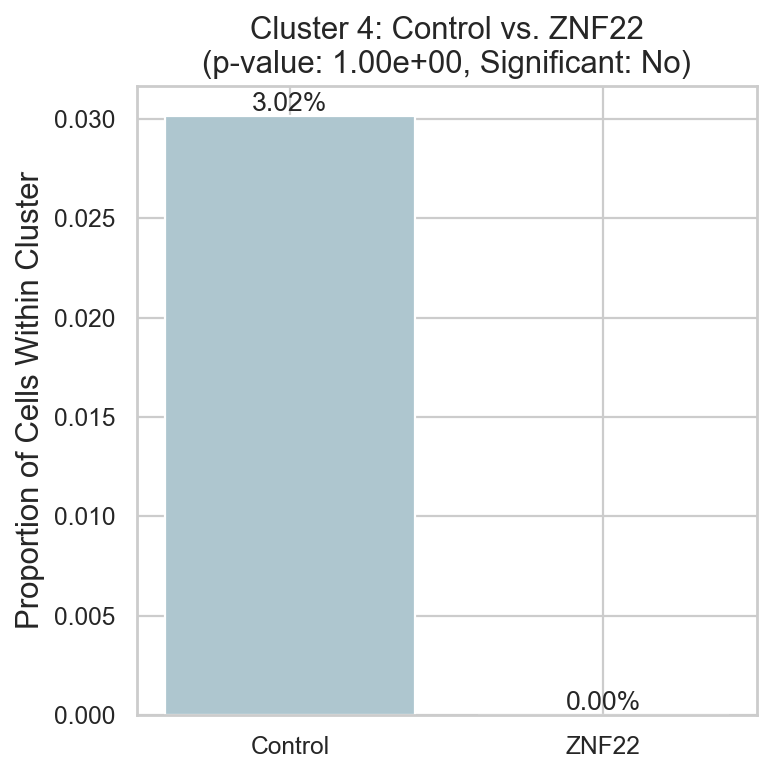

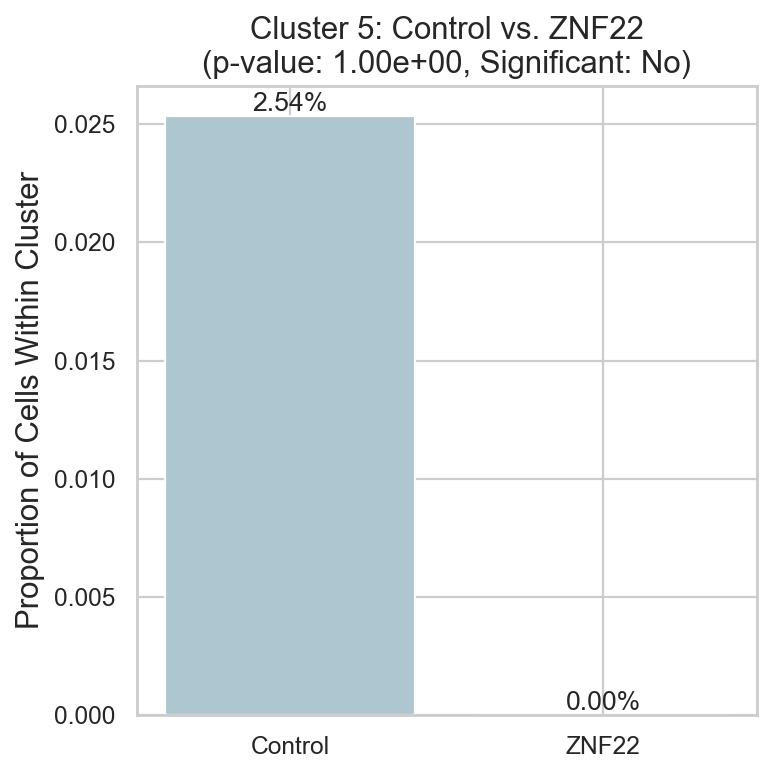

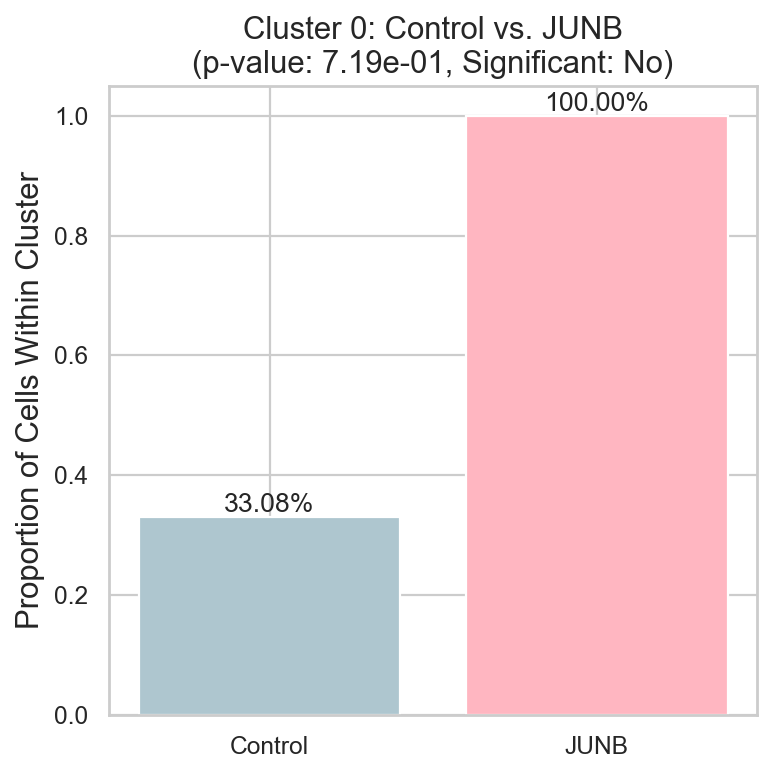

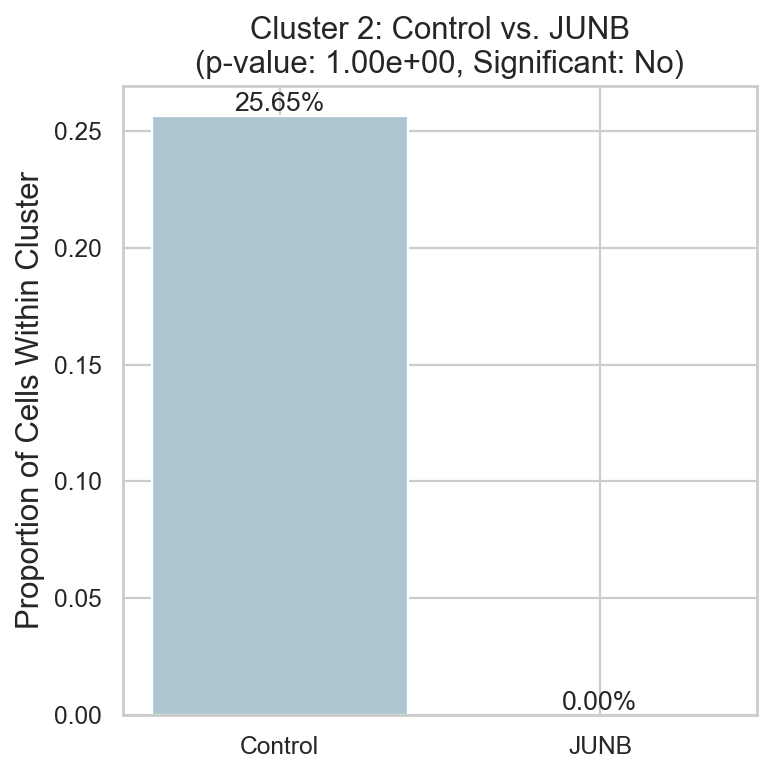

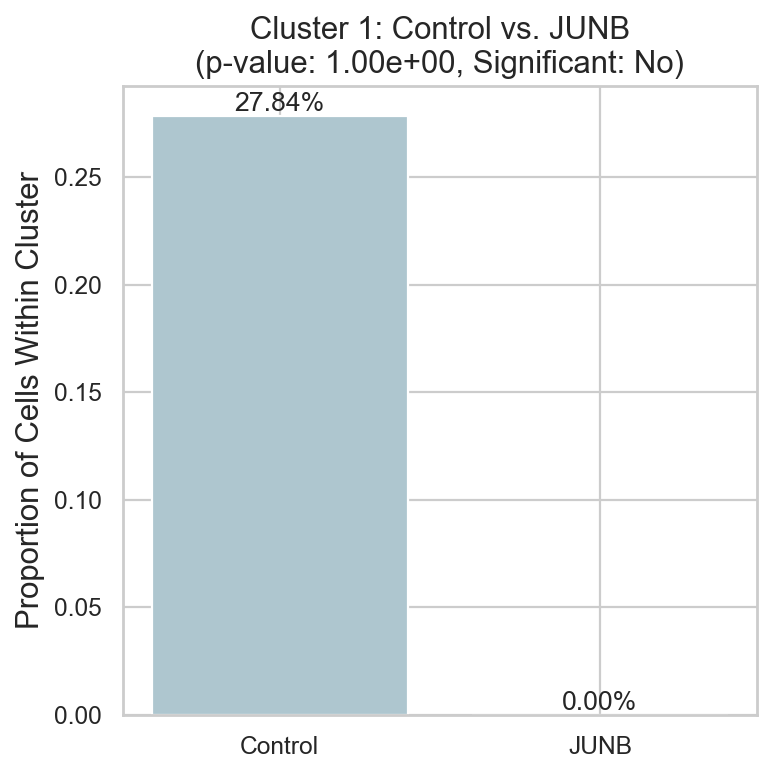

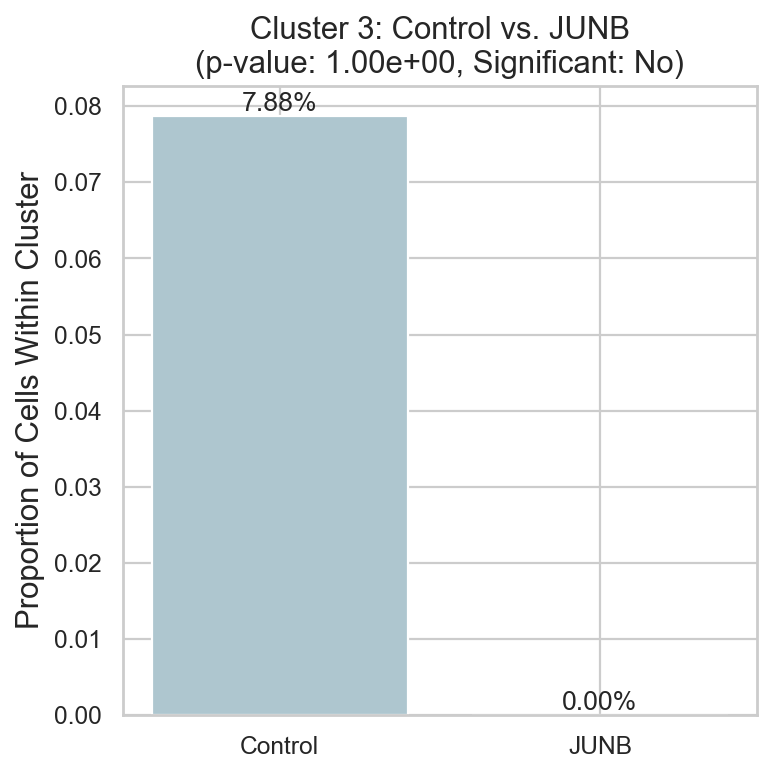

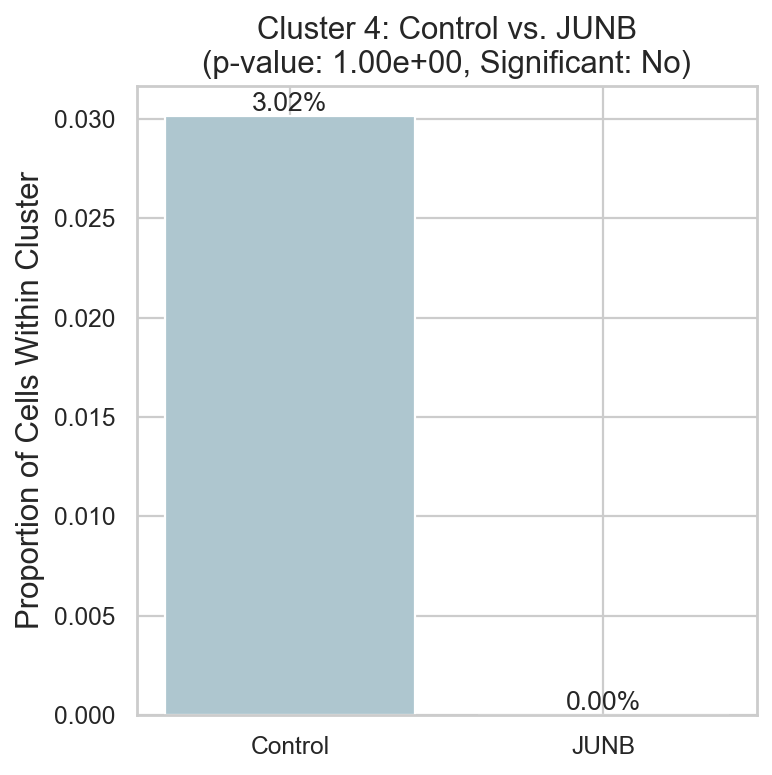

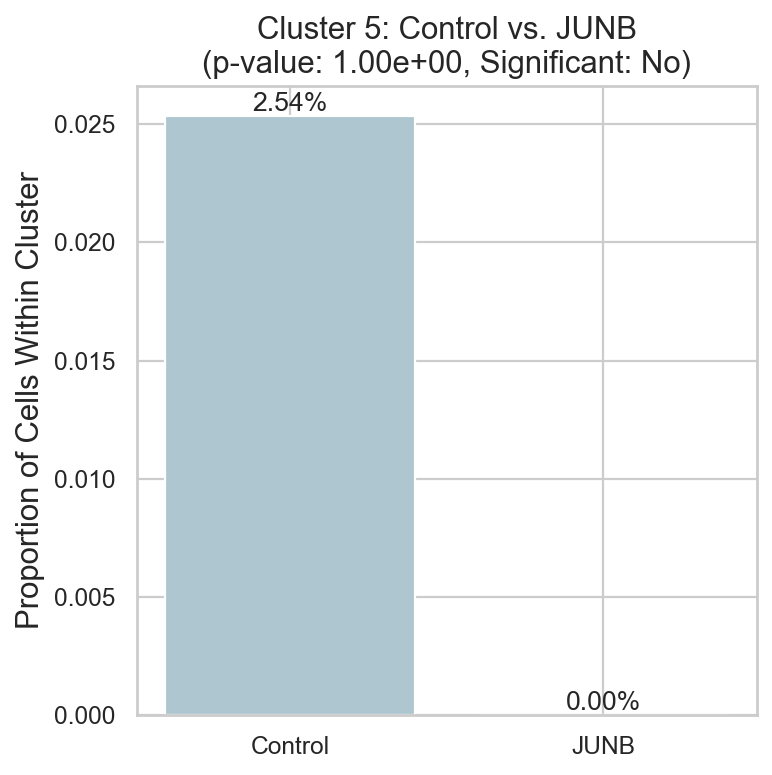

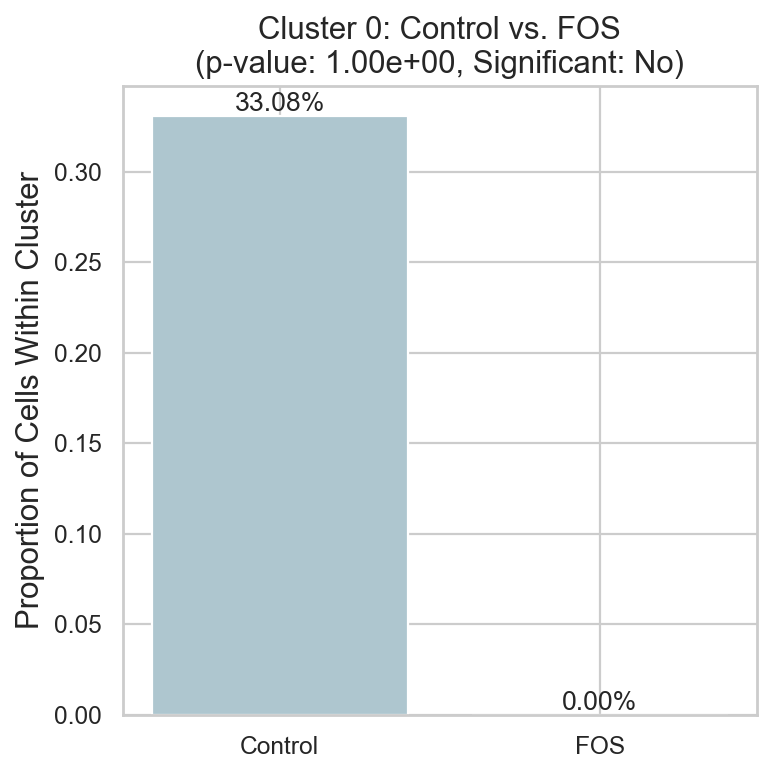

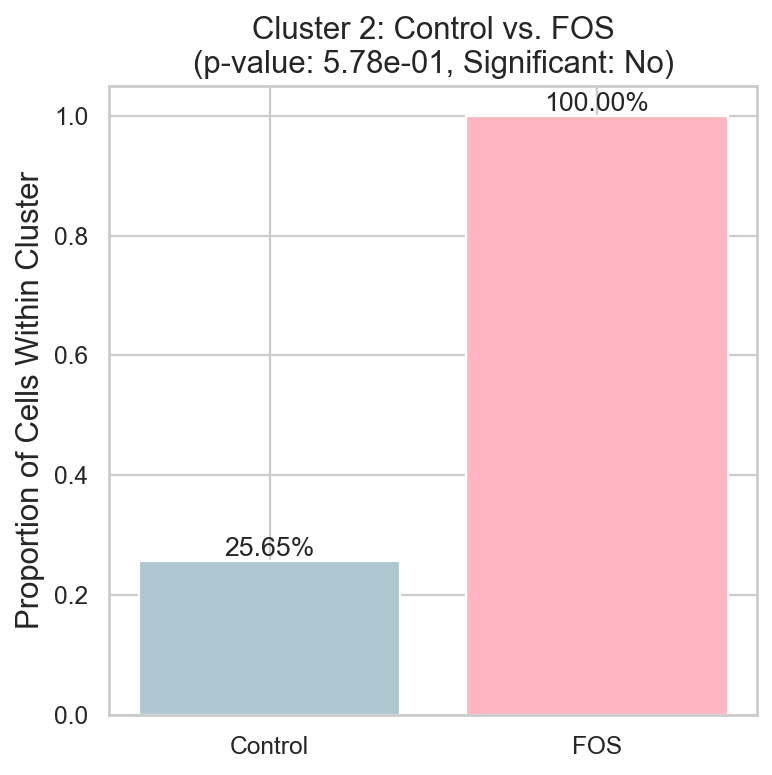

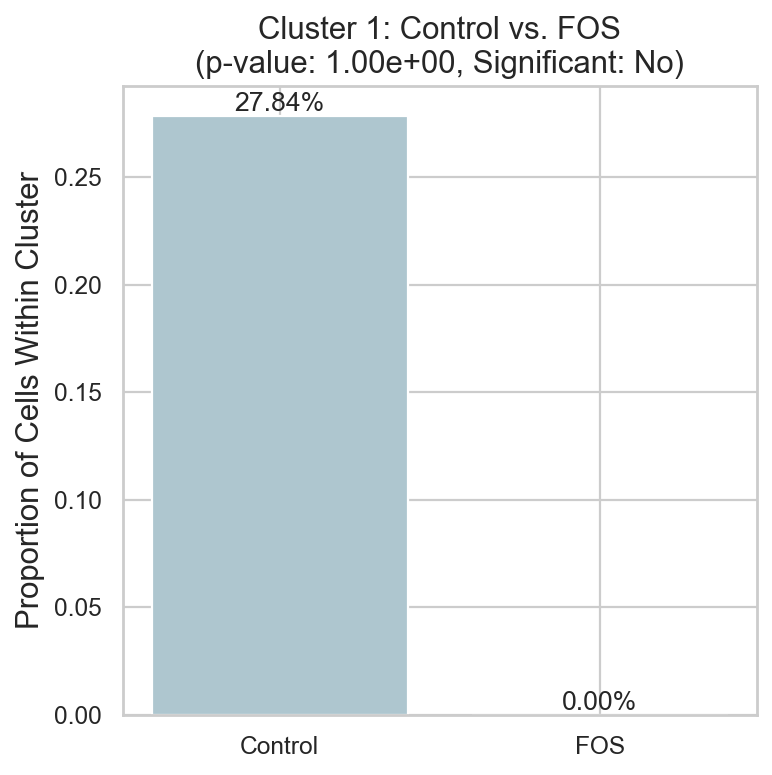

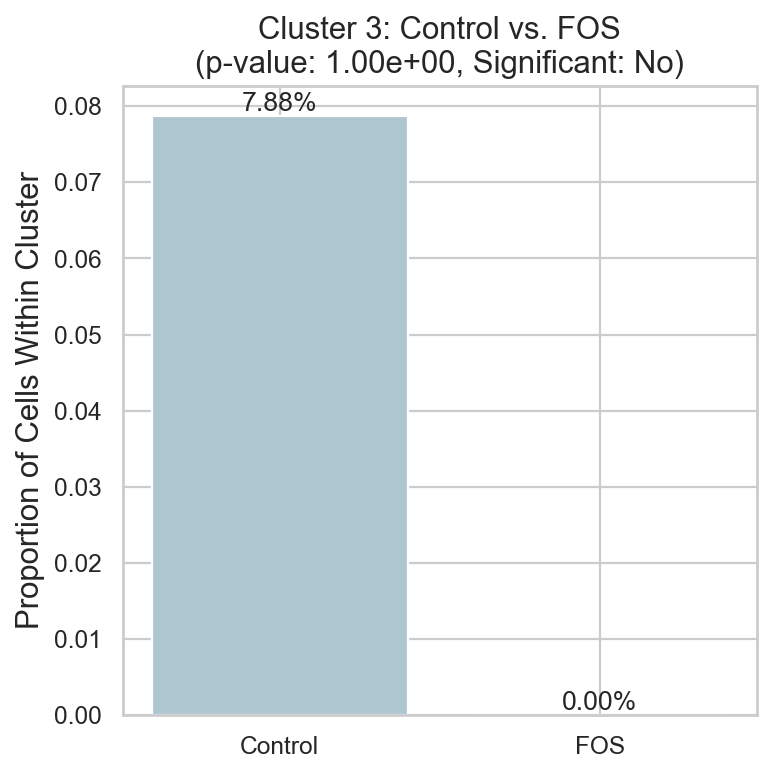

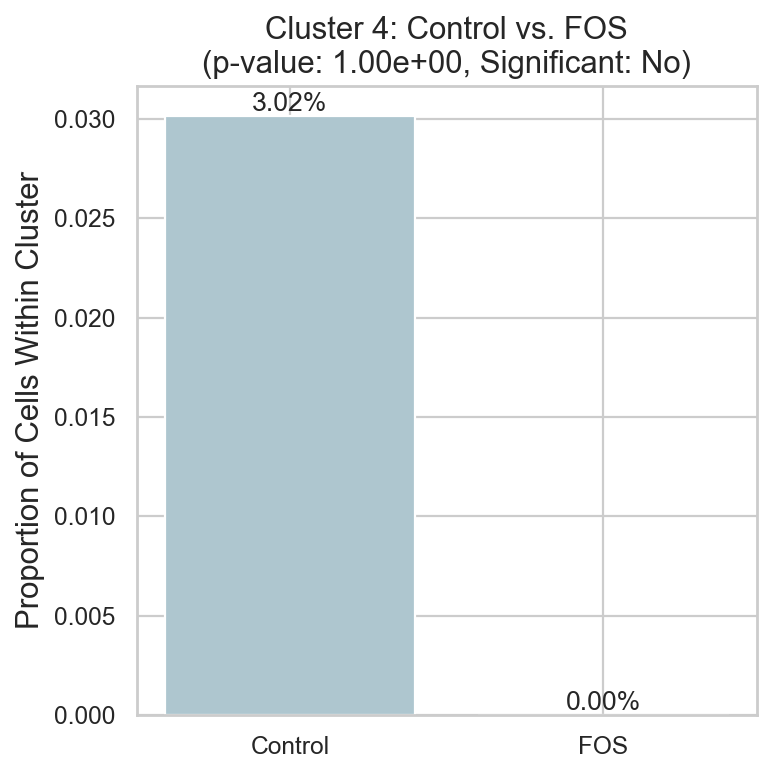

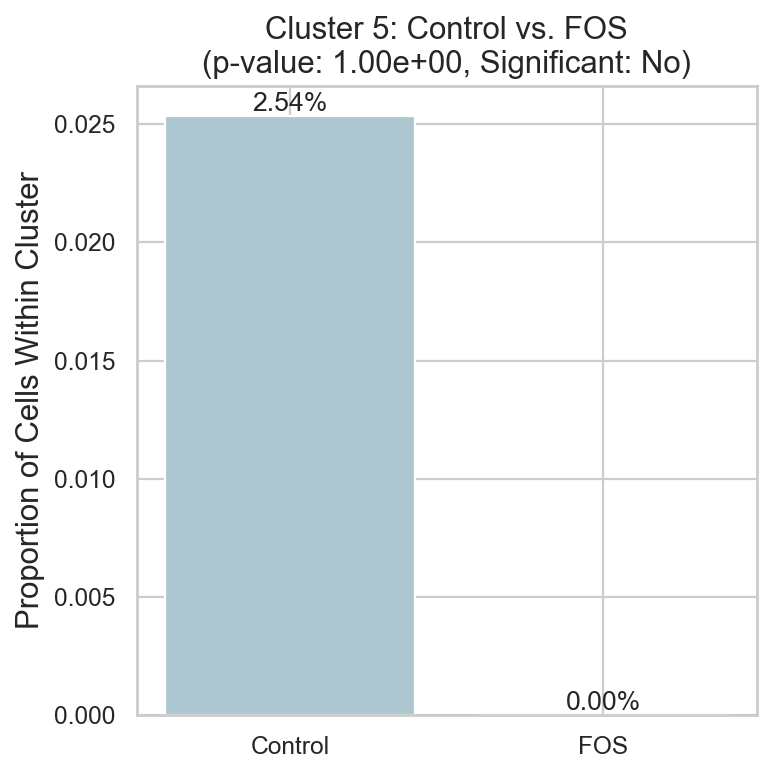

In [51]:
# Set a significance threshold
significance_threshold = 0.05

# Unique genes excluding 'control'
unique_genes = adata.obs['Gene'].unique()
unique_genes = unique_genes[unique_genes != 'control']

# Iterate over each unique gene
for gene in unique_genes:
    # Iterate over each cluster
    for cluster in adata.obs['leiden'].unique():
        # Construct a contingency table
        contingency_table = pd.DataFrame(
            [
                # Cells with current gene in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] != cluster)).sum(),
                ],
                # Control cells in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] != cluster)).sum(),
                ],
            ],
            index=[f"{gene}", "Control"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )

        # Adjust for zeros if necessary
        epsilon = 1e-10
        contingency_table += epsilon

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold
        # Cells for the gene of interest within and outside the cluster
        gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
        gene_total = (adata.obs['Gene'] == gene).sum()
        prop_gene_in_cluster = gene_in_cluster / gene_total

        # Cells for the control within and outside the cluster
        control_in_cluster = ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] == cluster)).sum()
        control_total = (adata.obs['Gene'] == 'control').sum()
        prop_control_in_cluster = control_in_cluster / control_total

        # Plotting
        categories = ['Control', gene]
        proportions = [prop_control_in_cluster, prop_gene_in_cluster]
        plt.figure(figsize=(5, 5))
        bars = plt.bar(categories, proportions, color=['#aec6cf', '#ffb6c1'])

        plt.ylabel('Proportion of Cells Within Cluster', fontsize=14)
        plt.title(f'Cluster {cluster}: Control vs. {gene}\n(p-value: {p:.2e}, Significant: {"Yes" if is_significant else "No"})', fontsize=14)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()


running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


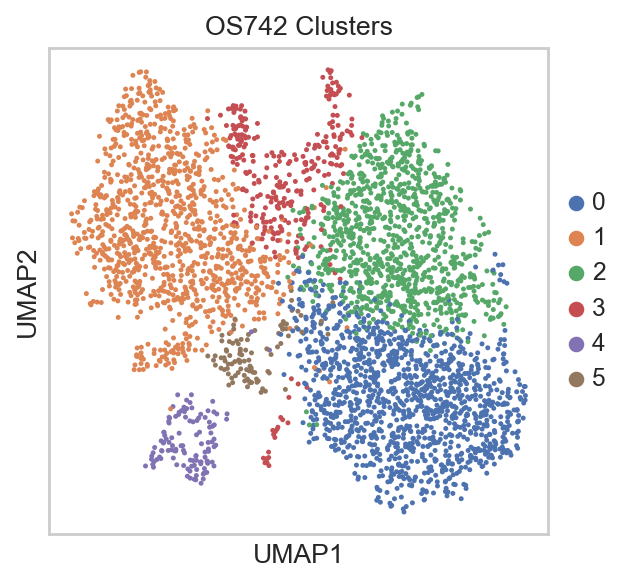

In [42]:
sc.tl.leiden(adata, resolution = 0.4)

sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 perturbseq - control cells",
    size = 20
)

In [28]:
# Saving the indices for filtering on wynton
modified_index = adata.obs.index.to_series().str.replace('-1', '')

# Save the modified index to a text file
modified_index.to_csv('OS384_cell_barcodes.txt', index=False, header=False)

In [2]:
# website for this specific dataset: 
adata = sc.read_10x_h5('/Users/brendamelano/Desktop/perturb_seq_practice/SC3_v3_NextGem_DI_CRISPR_A549_5K_SC3_v3_NextGem_DI_CRISPR_A549_5K_count_sample_feature_bc_matrix.h5')


reading /Users/brendamelano/Desktop/perturb_seq_practice/SC3_v3_NextGem_DI_CRISPR_A549_5K_SC3_v3_NextGem_DI_CRISPR_A549_5K_count_sample_feature_bc_matrix.h5
 (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata

AnnData object with n_obs × n_vars = 5867 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
adata.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGCTGAGCA-1, AAACCCAAGCTGTCCG-1, AAACCCACACAAATGA-1, AAACCCAGTATCTTCT-1, AAACCCAGTCGATTCA-1, AAACGAACAAATTGCC-1, AAACGAACAGGTTCGC-1, AAACGAAGTATTTCCT-1, AAACGAAGTCTTGAAC-1, AAACGAATCTCTGGTC-1, AAACGCTAGAGTGAAG-1, AAACGCTAGTCACTGT-1, AAAGAACAGAAACTGT-1, AAAGAACCAAAGGCGT-1, AAAGAACCACAAACGG-1, AAAGAACCAGTCAACT-1, AAAGAACCATTGTCGA-1, AAAGAACGTACCTAAC-1, AAAGAACGTCGGCTAC-1, AAAGAACGTTCAGCGC-1, AAAGAACTCAAACGAA-1, AAAGAACTCACATACG-1, AAAGAACTCTAGCATG-1, AAAGAACTCTGCCCTA-1, AAAGGATAGAAACTCA-1, AAAGGATCAAGCTACT-1, AAAGGATCACGCAAAG-1, AAAGGATGTACGGTTT-1, AAAGGATTCGGACCAC-1, AAAGGGCAGGAACGAA-1, AAAGGGCAGGTTACCT-1, AAAGGGCCAAACTAGA-1, AAAGGGCCAAATCAGA-1, AAAGGGCTCAATCTCT-1, AAAGGTACACGGTAGA-1, AAAGGTATCAAAGAAC-1, AAAGGTATCATACGGT-1, AAAGTCCAGTCGCTAT-1, AAAGTCCCAGGTCAAG-1, AAAGTCCGTAACGGTG-1, AAAGTCCGTTCCAAAC-1, AAAGTCCTCTGAGAGG-1, AAAGTGAAGACCAACG-1, AAAGTGAAGAGCCATG-1, AAAGTGAAGCTCTTCC-1, AAAGTGACAGGAATAT-1, AAAGTGAGTACGATGG-1, AAAGTGAGTCAGTTTG-1, AAAGTGAGTGTCGATT-1, AAAGTGATCACTGTTT-1, AAATGGACATGAAGCG-1, AAATGGAGTGAATGAT-1, AAATGGAGTGAGTAGC-1, AAATGGAGTTCGCGTG-1, AAATGGATCCTCACTG-1, AACAAAGAGATTGTGA-1, AACAAAGAGTTGCGCC-1, AACAAAGCACACCGAC-1, AACAAAGGTGGTTTAC-1, AACAAAGTCAAGAAAC-1, AACAAAGTCACGGAGA-1, AACAACCAGGAAGAAC-1, AACAACCAGGCTAACG-1, AACAACCCAGCAGTGA-1, AACAACCGTTTACGAC-1, AACAACCGTTTCTATC-1, AACAAGAAGAGAGTTT-1, AACAAGAAGAGCAGAA-1, AACAAGAAGGCATCAG-1, AACAAGAAGTAGAGTT-1, AACAAGAAGTTCATGC-1, AACAAGACACTGCATA-1, AACAAGACAGGAATAT-1, AACAAGAGTAATTAGG-1, AACAAGAGTGTTACAC-1, AACAAGAGTTATGACC-1, AACAAGATCGCCTATC-1, AACAAGATCGGTGTTA-1, AACACACCAGAGCTAG-1, AACAGGGAGACTAGAT-1, AACAGGGAGCGGATCA-1, AACAGGGAGCGTATGG-1, AACAGGGAGTTGCCTA-1, AACAGGGCAGAAGTTA-1, AACAGGGCAGCACAAG-1, AACAGGGGTCGACTTA-1, AACAGGGGTTAGAGAT-1, AACAGGGTCATTCACT-1, AACCAACAGCTGGCCT-1, AACCAACAGTAAGAGG-1, AACCAACGTCAAGGCA-1, AACCAACGTGGAAATT-1, AACCAACGTTGGCTAT-1, AACCAACTCGATGCAT-1, AACCACAAGCTCACTA-1, AACCACAGTGCGCTCA-1, AACCACAGTTGAGTCT-1, AACCATGAGGATATAC-1, AACCATGCAAACTCTG-1, AACCATGCATACTTTC-1, ...]

[5867 rows x 0 columns]

# Adding the guide information

In [ ]:
molecule_info_path = '/Users/brendamelano/Desktop/OS742_scRNAseq_LT_feature_ref/molecule_info.h5'

# Function to print all datasets in an HDF5 file
def print_datasets(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)

# Open the HDF5 file and list datasets
with h5py.File(molecule_info_path, 'r') as f:
    f.visititems(print_datasets)
    
with h5py.File(molecule_info_path, 'r') as f:
# Extract gRNA information. Adjust the keys as necessary based on your Cell Ranger version
feature_ids = f['features/id'][:]
feature_types = f['features/feature_type'][:]
cell_barcodes = f['barcodes'][:]
umi_counts = f['umi'][:]
barcode_idx = f['barcode_idx'][:]
feature_idx = f['feature_idx'][:]
sequence = f['features/sequence'][:]


cell_barcodes = pd.DataFrame({
    'cell_barcodes': cell_barcodes
})

# Resetting the index and renaming the index column
cell_barcodes = cell_barcodes.reset_index()
cell_barcodes = cell_barcodes.rename(columns={'index': 'barcode_idx'})



feature_id_sequences = pd.DataFrame({
    'sequence': sequence,
    'feature_ids': feature_ids
})


# Resetting the index and renaming the index column
feature_id_sequences = feature_id_sequences.reset_index()
feature_id_sequences = feature_id_sequences.rename(columns={'index': 'feature_idx'})


barcode_data = pd.DataFrame({
    'barcode_idx': barcode_idx,
    'feature_idx': feature_idx,
    'umi_counts': umi_counts
})

# Merge the dataframes
merged_data = barcode_data.merge(feature_id_sequences, on='feature_idx', how='left')


merged_data = merged_data.merge(cell_barcodes, on='barcode_idx', how='left')

# Convert 'feature_ids' column to string
merged_data['feature_ids'] = merged_data['feature_ids'].astype(str)

# Filter rows where 'feature_ids' column contains the string "LT"
filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]


# Filter for gRNA features
is_barcode = feature_types == b'CRISPR Guide Capture'  # Adjust if your gRNA feature type is named differently
barcode_ids = feature_ids[is_barcode]

# Filter gRNA data
barcode_data = barcode_data[barcode_data['feature_idx'].isin(barcode_ids)]

# Aggregate UMIs per cell barcode for each gRNA
barcode_counts = barcode_data.groupby(['barcode_idx', 'feature_idx']).umi_counts.sum().unstack(fill_value=0)


# Map indices to actual barcode and gRNA IDs
barcode_counts.index = [cell_barcodes[i].decode('utf-8') for i in barcode_counts.index]
barcode_counts.columns = [barcode_ids[i].decode('utf-8') for i in barcode_counts.columns]


# Integrate gRNA counts into AnnData
for gRNA_id in gRNA_counts.columns:
    adata.obs[gRNA_id] = gRNA_counts[gRNA_id].reindex(adata.obs_names, fill_value=0)
